In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates
import warnings
import seaborn as sns

warnings.filterwarnings('ignore') 
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [2]:
data = pd.read_csv('Project1Data.csv')

#### 1. Merging of duplicate variable 'Category_Face Care' Variable

In [3]:
columns_to_sum = data.filter(like="Category_Face Care").columns

data[columns_to_sum[0]] = data[columns_to_sum].sum(axis=1)

data = data.drop(columns=columns_to_sum[1:])

In [4]:
data.duplicated().sum()

0

#### 2. Delete any unrelated variables

In [5]:
unrelated_var = ['Has_Transaction_Nov23_May24','Post Code']
data.drop(data[unrelated_var], axis=1, inplace=True)

#### 3. Outliers (time-related variable)

In [6]:
detect_outliers_columns= ['Total_Spent_Nov23_May24', 'Total_Spent_1M', 'Transaction_Count_1M',
       'Total_Spent_3M', 'Transaction_Count_3M', 'Total_Spent_6M',
       'Transaction_Count_6M', 'Total_Spent_9M', 'Transaction_Count_9M',
       'Total_Spent_12M', 'Transaction_Count_12M', 'Total_Spent_AllTime',
       'Transaction_Count_AllTime']

In [7]:
def calculate_threholds(column):
    Q1=data[column].quantile(0.25)
    Q3=data[column].quantile(0.75)
    IQR=Q3-Q1
    lower_bound = Q1- 1.5*IQR
    upper_bound = Q3 +1.5*IQR
    return lower_bound, upper_bound

In [8]:
threholds = {col: calculate_threholds(col) for col in detect_outliers_columns}

In [9]:
data= data.copy()
for col, (lower, upper) in threholds.items():
    data_outliers = data[(data[col]<lower) | (data[col]>upper)]

In [10]:
outliers=data_outliers[detect_outliers_columns].reset_index(drop=True)

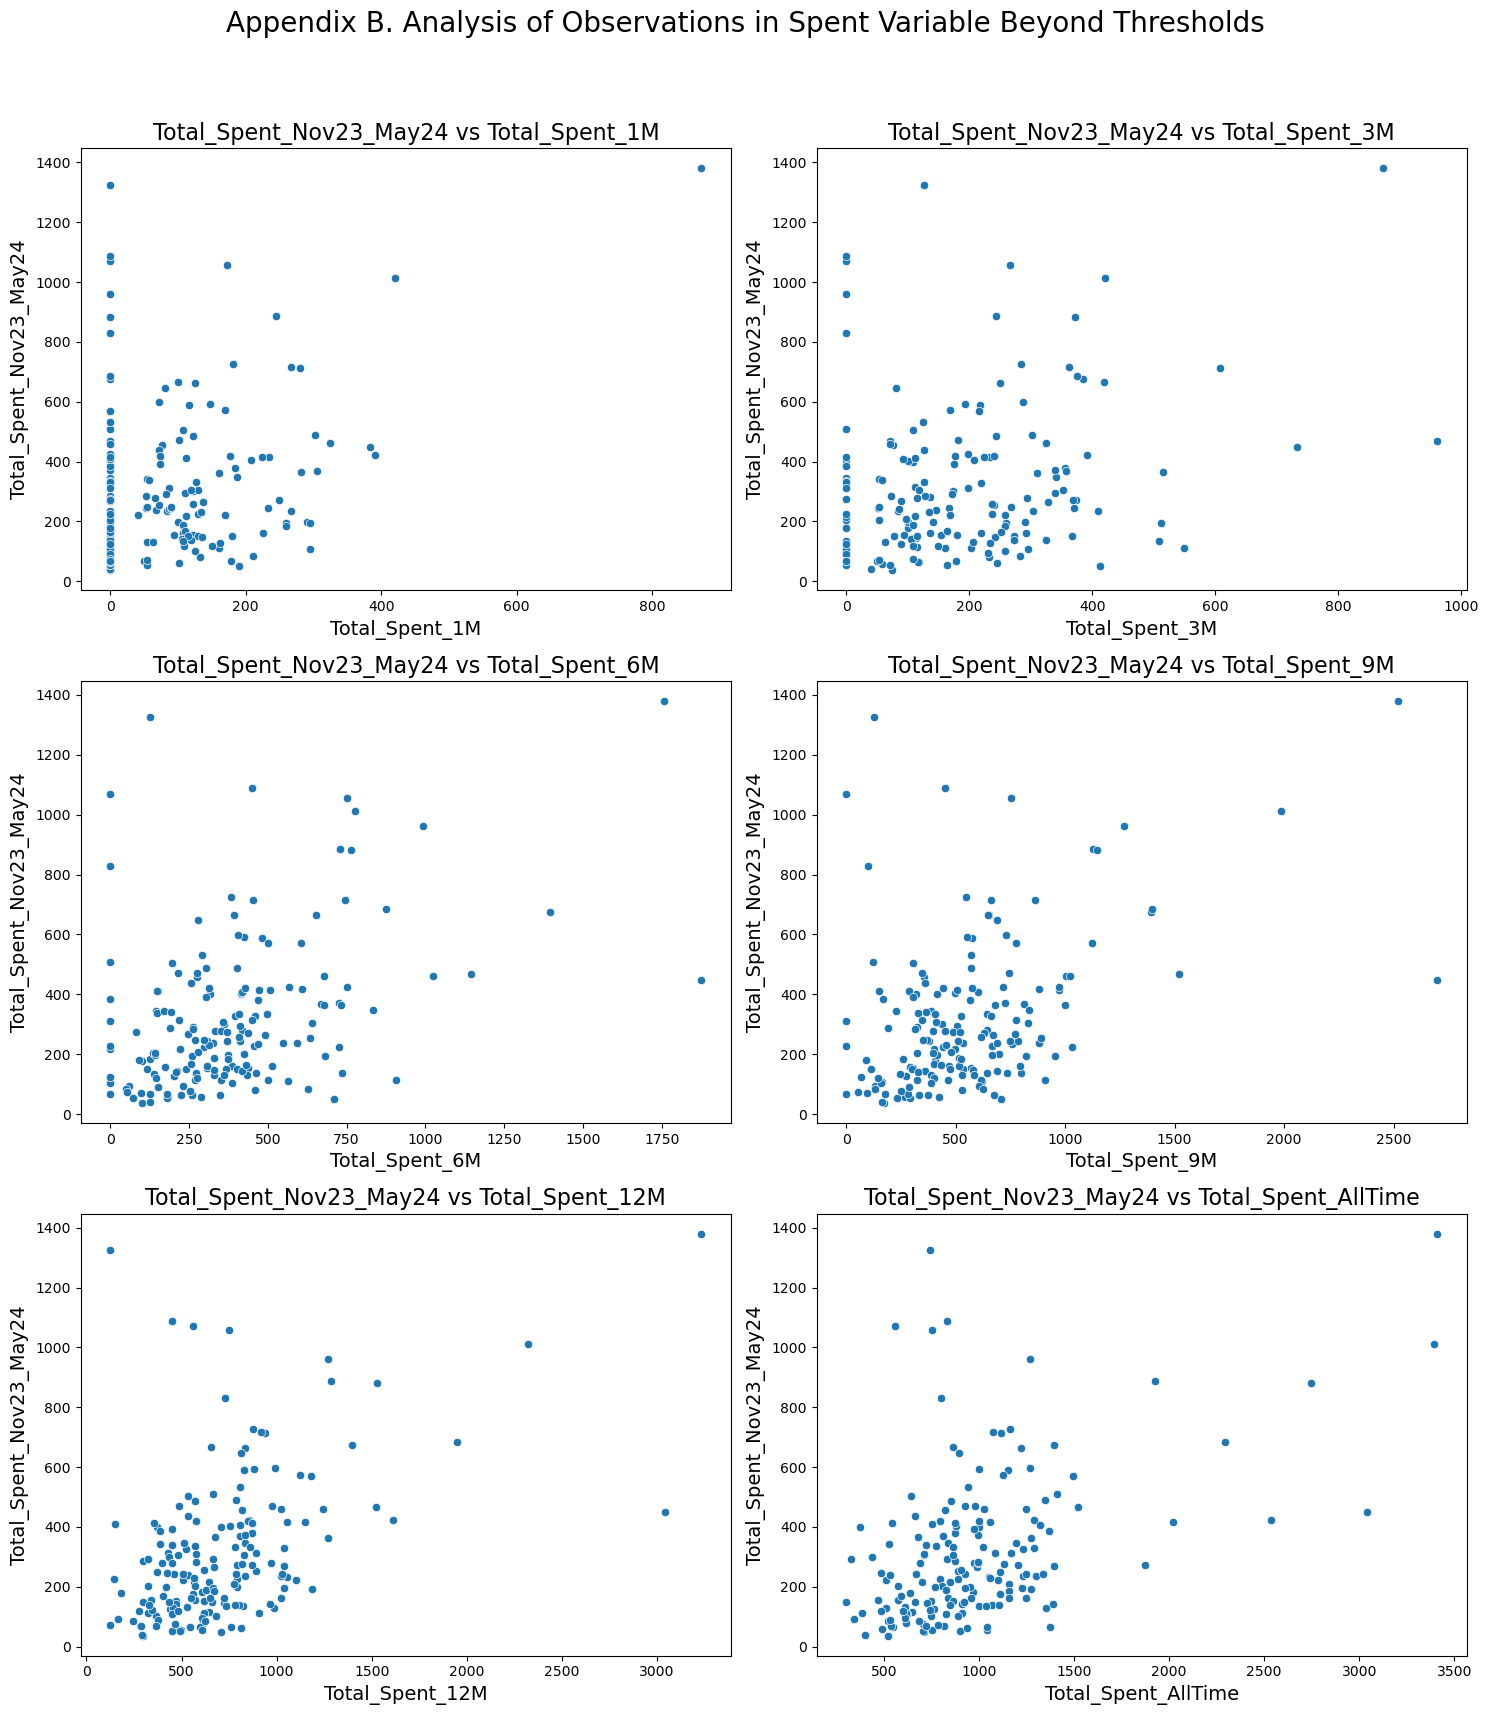

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()  
columns_spent = ['Total_Spent_1M',
       'Total_Spent_3M', 'Total_Spent_6M', 'Total_Spent_9M', 
       'Total_Spent_12M', 'Total_Spent_AllTime']
target_variable='Total_Spent_Nov23_May24' 
for i, column in enumerate(columns_spent):
    sns.scatterplot(x=outliers[column], y=outliers[target_variable], ax=axes[i])
    axes[i].set_title(f'{target_variable} vs {column}', size=16)
    axes[i].set_xlabel(column, size=14)
    axes[i].set_ylabel(target_variable, size=14)

plt.suptitle('Appendix B. Analysis of Observations in Spent Variable Beyond Thresholds', size=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('Appendix B. Analysis of Observations in Spent Variable Beyond Thresholds.png')
plt.show()

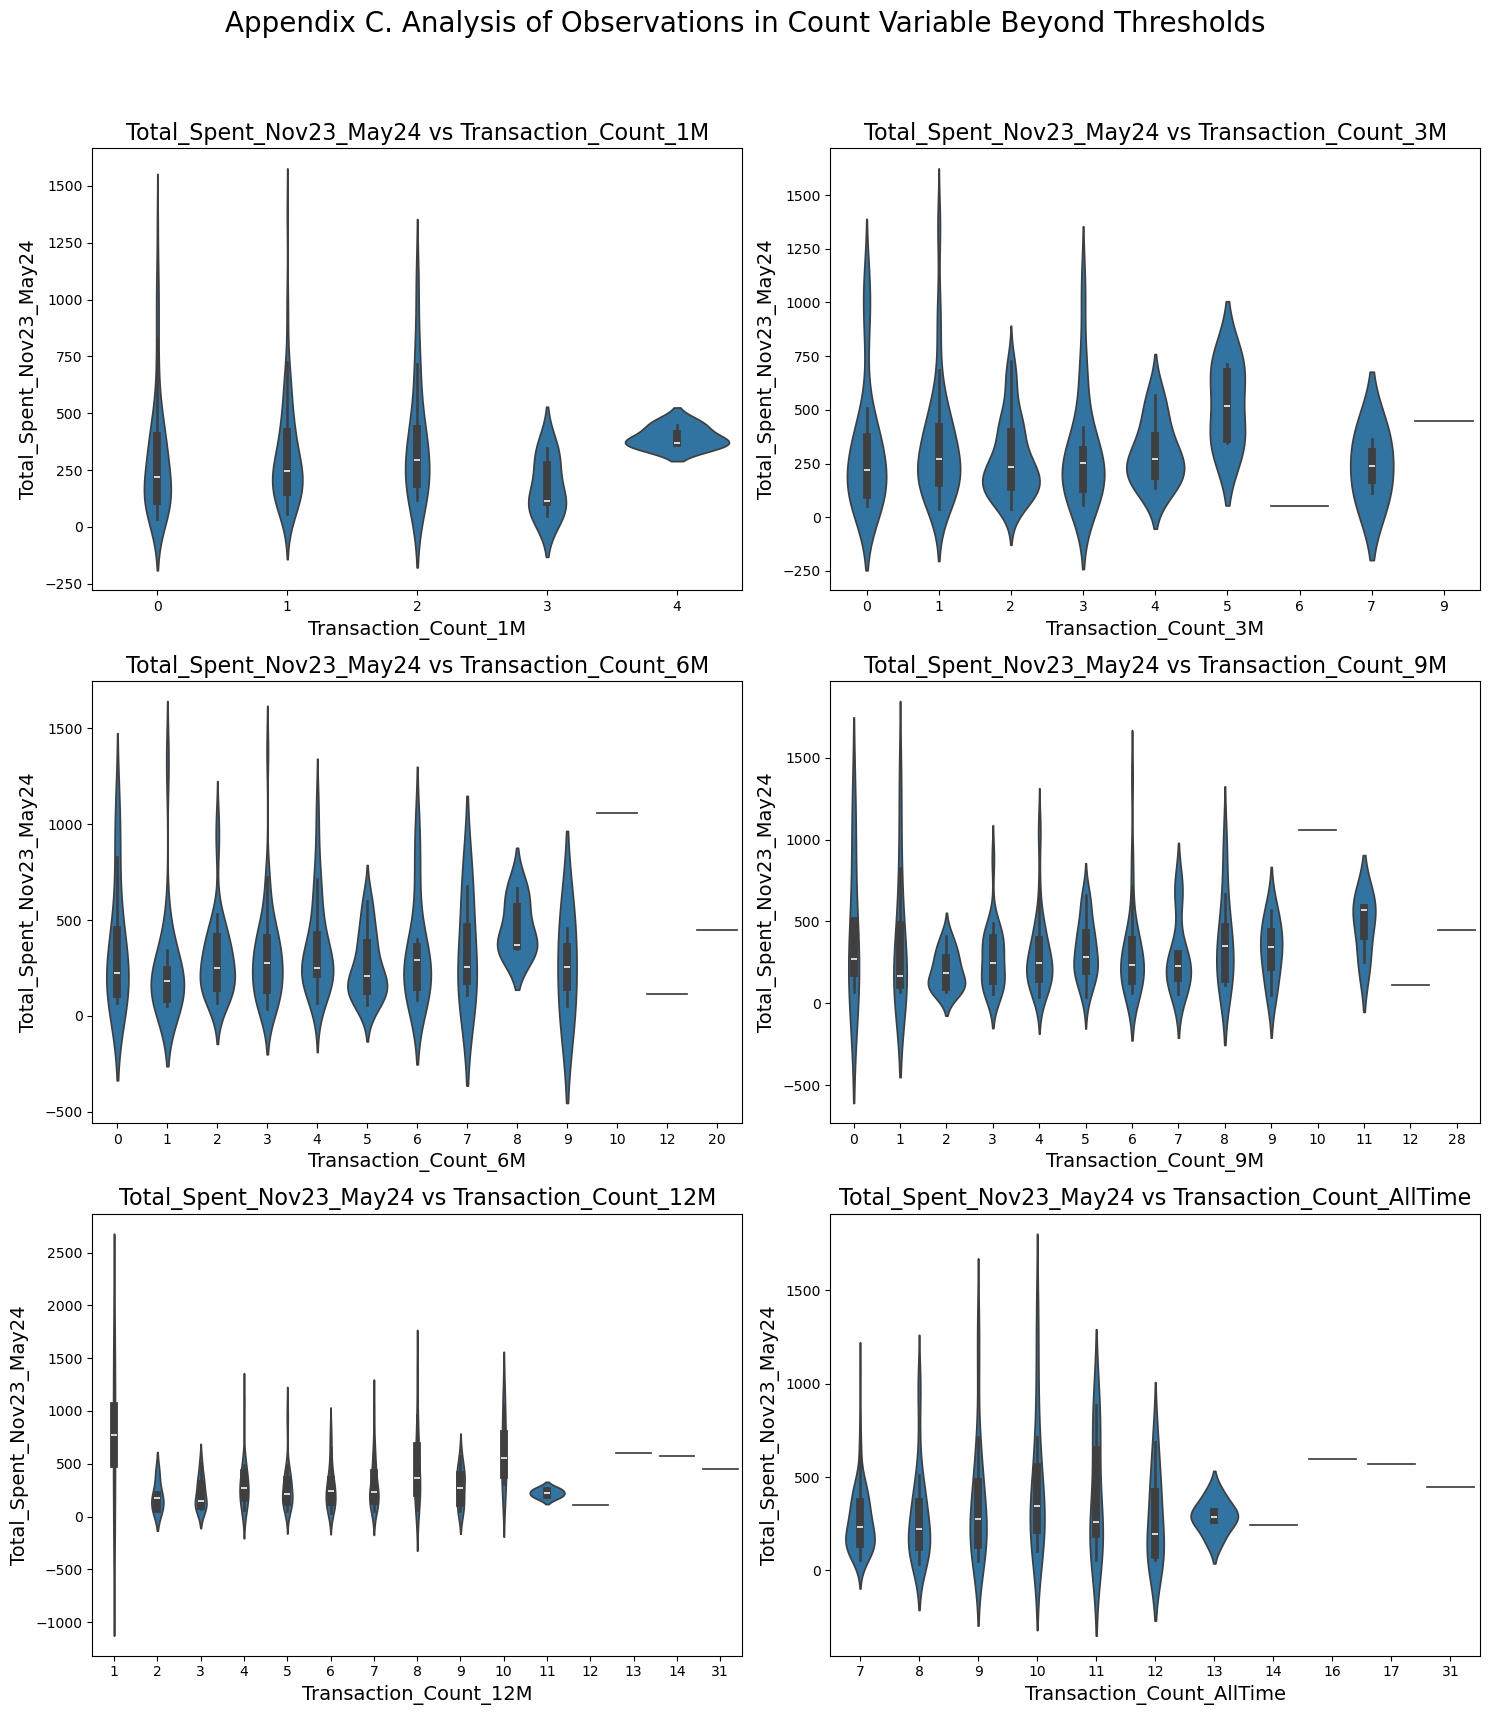

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()  
columns_count=['Transaction_Count_1M','Transaction_Count_3M',
               'Transaction_Count_6M', 'Transaction_Count_9M',
               'Transaction_Count_12M', 'Transaction_Count_AllTime']
target_variable='Total_Spent_Nov23_May24'
for i, column in enumerate(columns_count):
    sns.violinplot(x=outliers[column], y=outliers[target_variable], ax=axes[i])
    axes[i].set_title(f'{target_variable} vs {column}', size=16)
    axes[i].set_xlabel(column, size=14)
    axes[i].set_ylabel(target_variable, size=14)

plt.suptitle('Appendix C. Analysis of Observations in Count Variable Beyond Thresholds', size=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('Appendix C. Analysis of Observations in Count Variable Beyond Thresholds.png')
plt.show()

## EDA Analysis

### 1. Analysis of Target Variable ('Total_Spent_Nov23_May24')

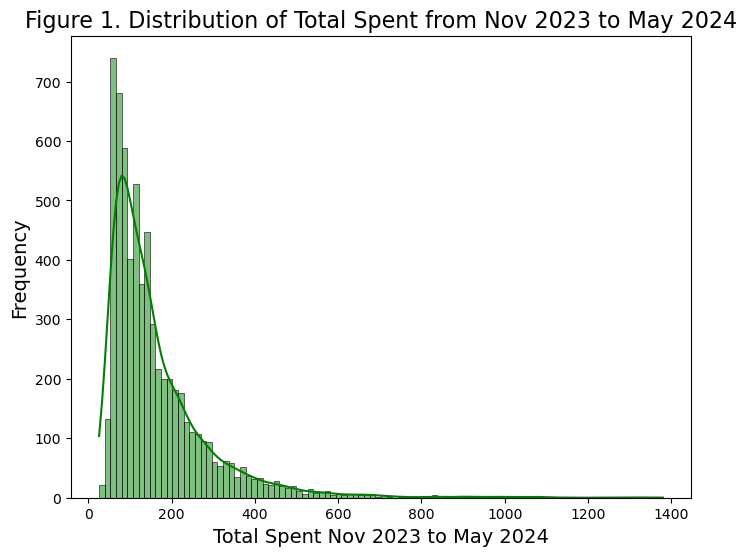

In [13]:
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='Total_Spent_Nov23_May24', bins=100, kde=True, color='green')

plt.title('Figure 1. Distribution of Total Spent from Nov 2023 to May 2024', fontsize=16)
plt.xlabel('Total Spent Nov 2023 to May 2024', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.savefig('Figure 1. Distribution of Total Spent from Nov 2023 to May 2024.png')
plt.show()

### 2. Train Test split

In [14]:
train_indices, test_indices = train_test_split(np.array(data.index), test_size=0.2, random_state=0)

data_train = data.loc[train_indices].copy()
data_test = data.loc[test_indices].copy()

y_train_nolog = data_train[target_variable].to_numpy()
y_test_nolog = data_test[target_variable].to_numpy()

data_rfm_train = data_train.copy()
data_rfm_test = data_test.copy()

### 3. Target Variable with Quantile Transformation

In [15]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

target_variable='Total_Spent_Nov23_May24'
transformer = QuantileTransformer(output_distribution='normal')
transformed_target_variable_train = transformer.fit_transform(data_train[target_variable].values.reshape(-1, 1))
transformed_target_variable_test = transformer.transform(data_test[target_variable].values.reshape(-1, 1))

data_train['transformed_target_variable'] = transformed_target_variable_train
data_test['transformed_target_variable'] = transformed_target_variable_test

### 4. Univariate EDA

In [16]:
data_train.describe()

Total_Spent_Nov23_May24  Total_Spent_1M  Transaction_Count_1M  \
count              5120.000000     5120.000000            5120.00000   
mean                162.725945       33.702346               0.28750   
std                 125.813520       67.983669               0.51559   
min                  28.660000        0.000000               0.00000   
25%                  80.720000        0.000000               0.00000   
50%                 124.660000        0.000000               0.00000   
75%                 199.947500       53.920000               1.00000   
max                1248.520000      764.800000               6.00000   

       Total_Spent_3M  Transaction_Count_3M  Total_Spent_6M  \
count     5120.000000           5120.000000     5120.000000   
mean        61.429041              0.535937      114.264762   
std         94.057440              0.724827      135.495831   
min          0.000000              0.000000        0.000000   
25%          0.000000              0.000000        0.000000   
50%          0.000000              0.000000       83.920000   
75%        106.395000              1.000000      162.655000   
max        960.930000              9.000000     1875.750000   

       Transaction_Count_6M  Total_Spent_9M  Transaction_Count_9M  \
count           5120.000000     5120.000000           5120.000000   
mean               1.005469      155.603053              1.380273   
std                1.052430      163.369290              1.267396   
min                0.000000        0.000000              0.000000   
25%                0.000000       57.520000              1.000000   
50%                1.000000      115.120000              1.000000   
75%                1.000000      209.340000              2.000000   
max               20.000000     2698.770000             28.000000   

       Total_Spent_12M  ...  EAN_TolerianeMoisturiser40ml  \
count      5120.000000  ...                   5120.000000   
mean        185.094793  ...                      0.132031   
std         183.375209  ...                      0.554290   
min           0.000000  ...                      0.000000   
25%          71.900000  ...                      0.000000   
50%         135.850000  ...                      0.000000   
75%         240.495000  ...                      0.000000   
max        3042.470000  ...                      8.000000   

       EAN_HyaluB5Serum30ml  EAN_EffaclarMoisturiser40ml  \
count           5120.000000                  5120.000000   
mean               0.170703                     0.250195   
std                0.482717                     0.669793   
min                0.000000                     0.000000   
25%                0.000000                     0.000000   
50%                0.000000                     0.000000   
75%                0.000000                     0.000000   
max                6.000000                    10.000000   

       EAN_VitaminC10Serum30ml  EAN_RetinolB3Serum30ml  EAN_EffaclarSerum30ml  \
count              5120.000000             5120.000000            5120.000000   
mean                  0.149219                0.166406               0.089258   
std                   0.447693                0.475256               0.324854   
min                   0.000000                0.000000               0.000000   
25%                   0.000000                0.000000               0.000000   
50%                   0.000000                0.000000               0.000000   
75%                   0.000000                0.000000               0.000000   
max                   5.000000                4.000000               5.000000   

       EAN_AntheliosInvisibleSunscreen50ml  EAN_Pure10NiacinamideSerum  \
count                          5120.000000                 5120.000000   
mean                              0.204687                    0.130859   
std                               0.525477                    0.444700   
min                               0.000000         

#### 4.1 Numerical variable skewness analysis

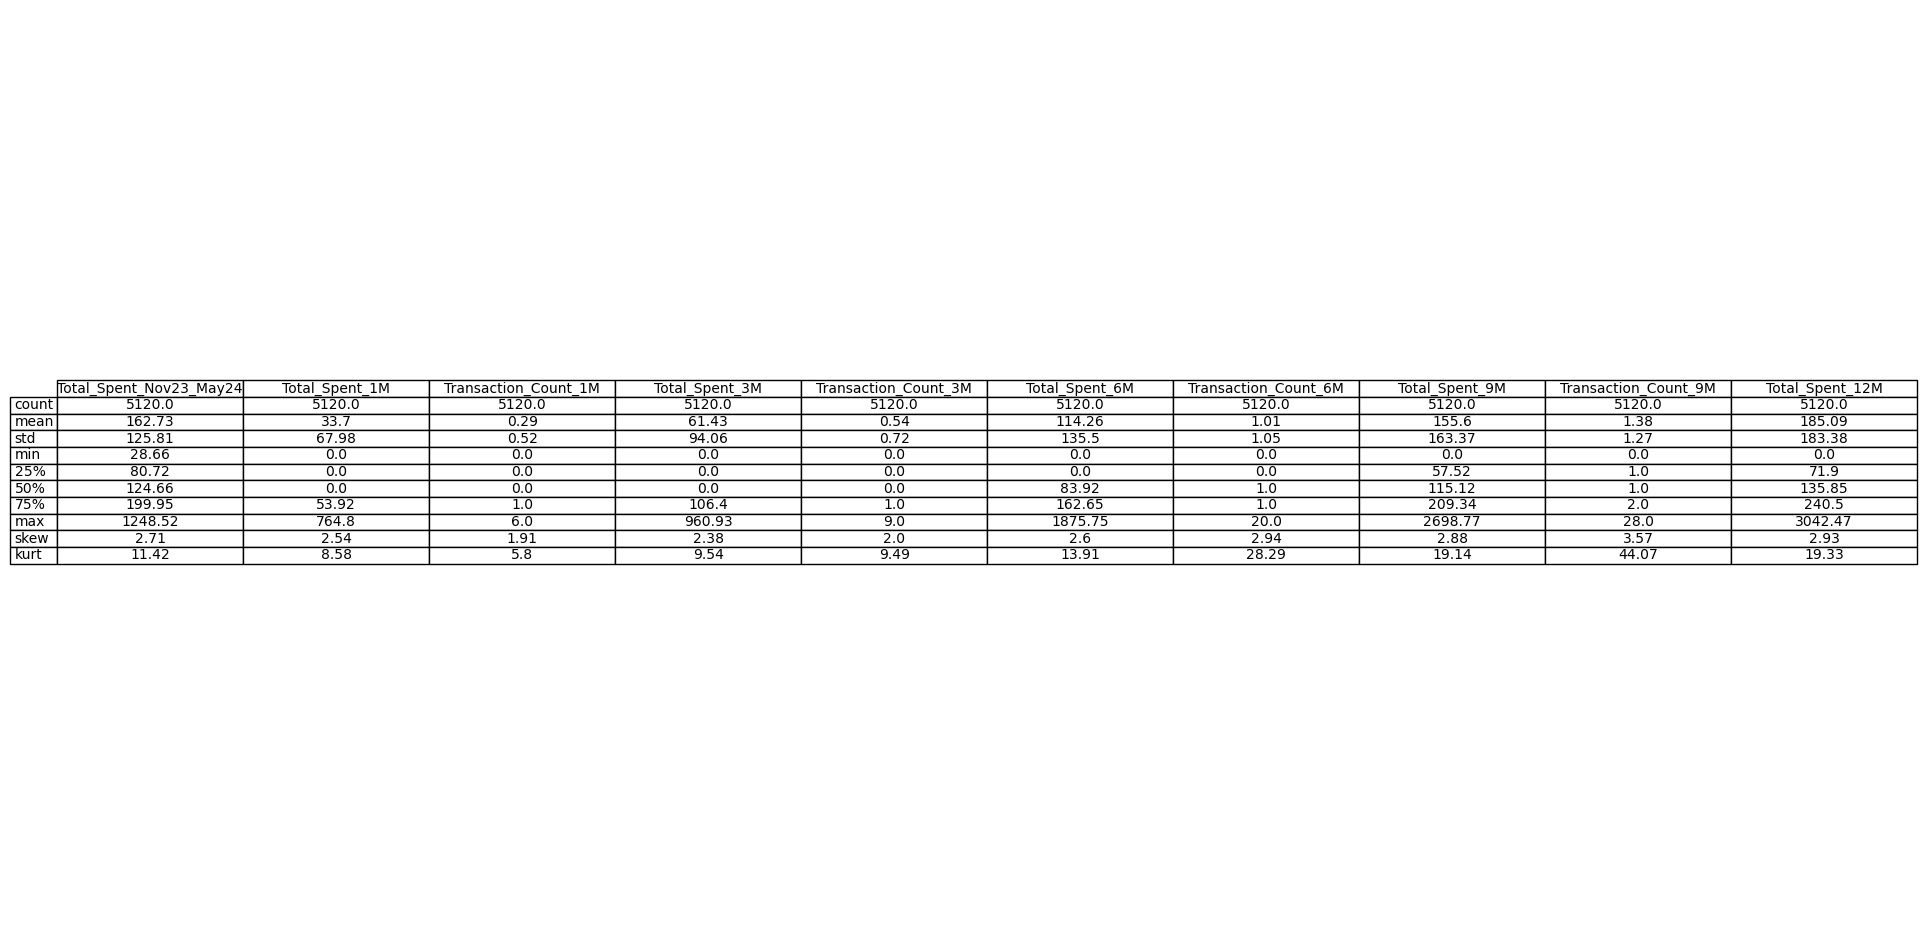

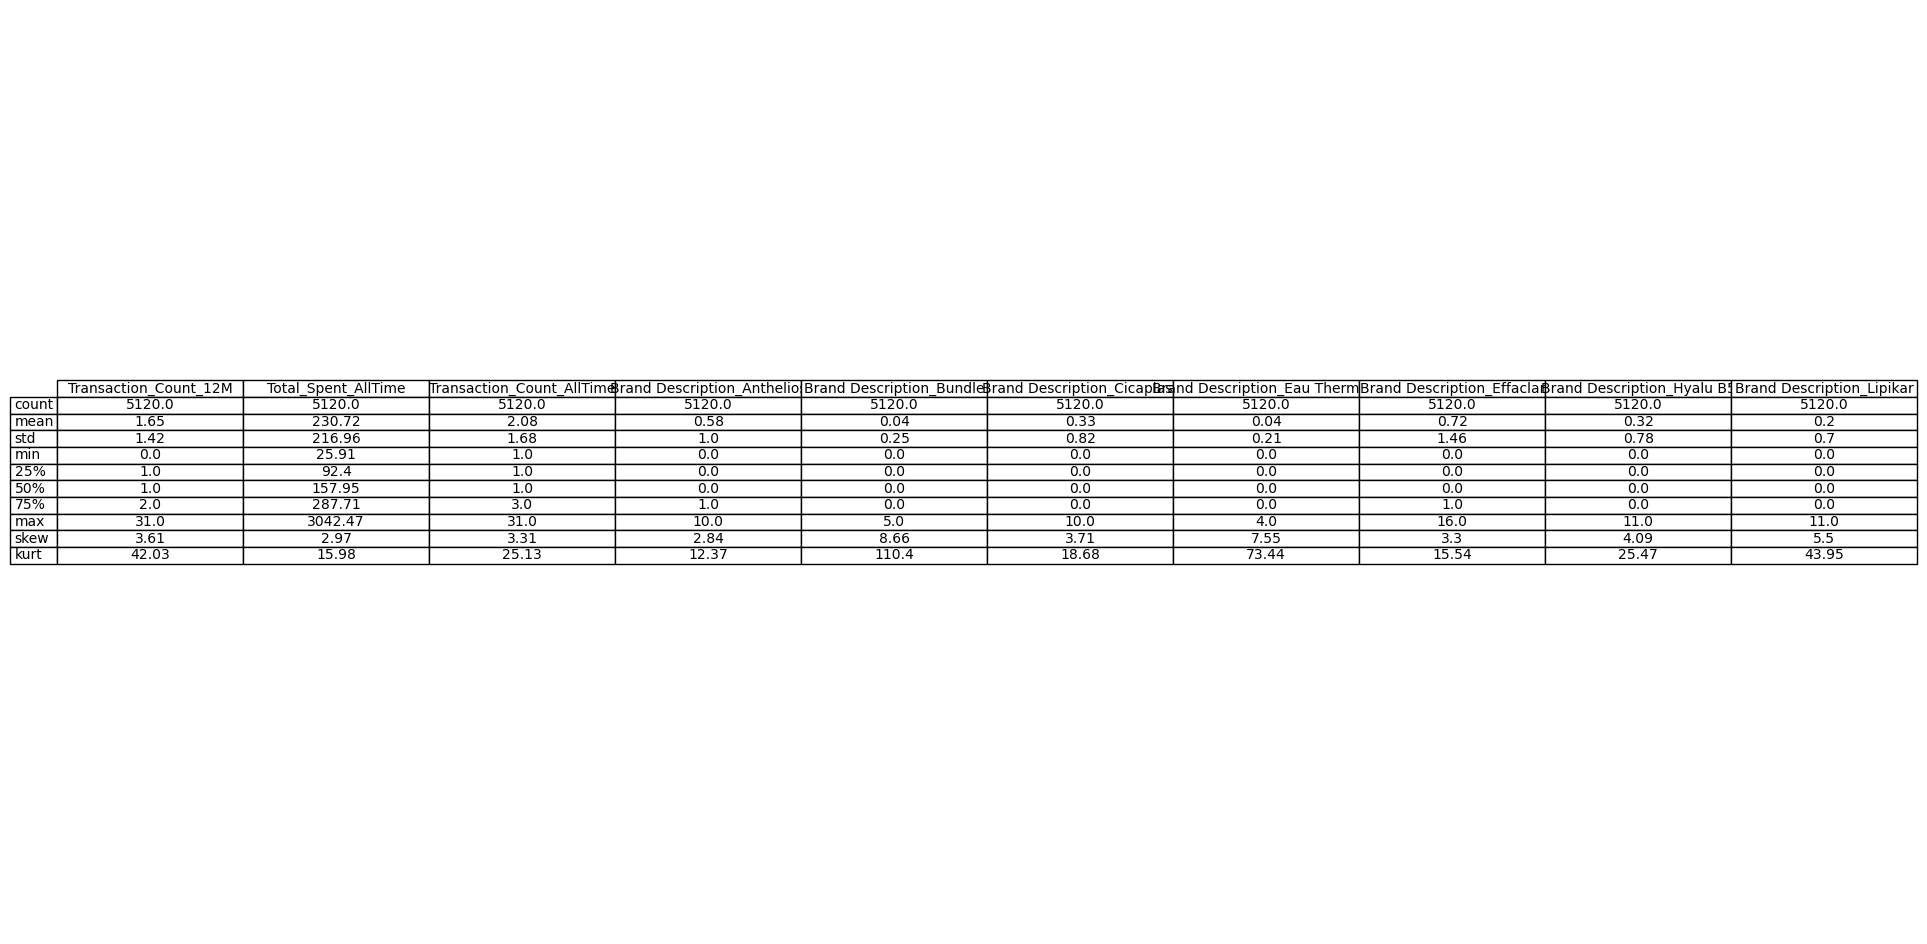

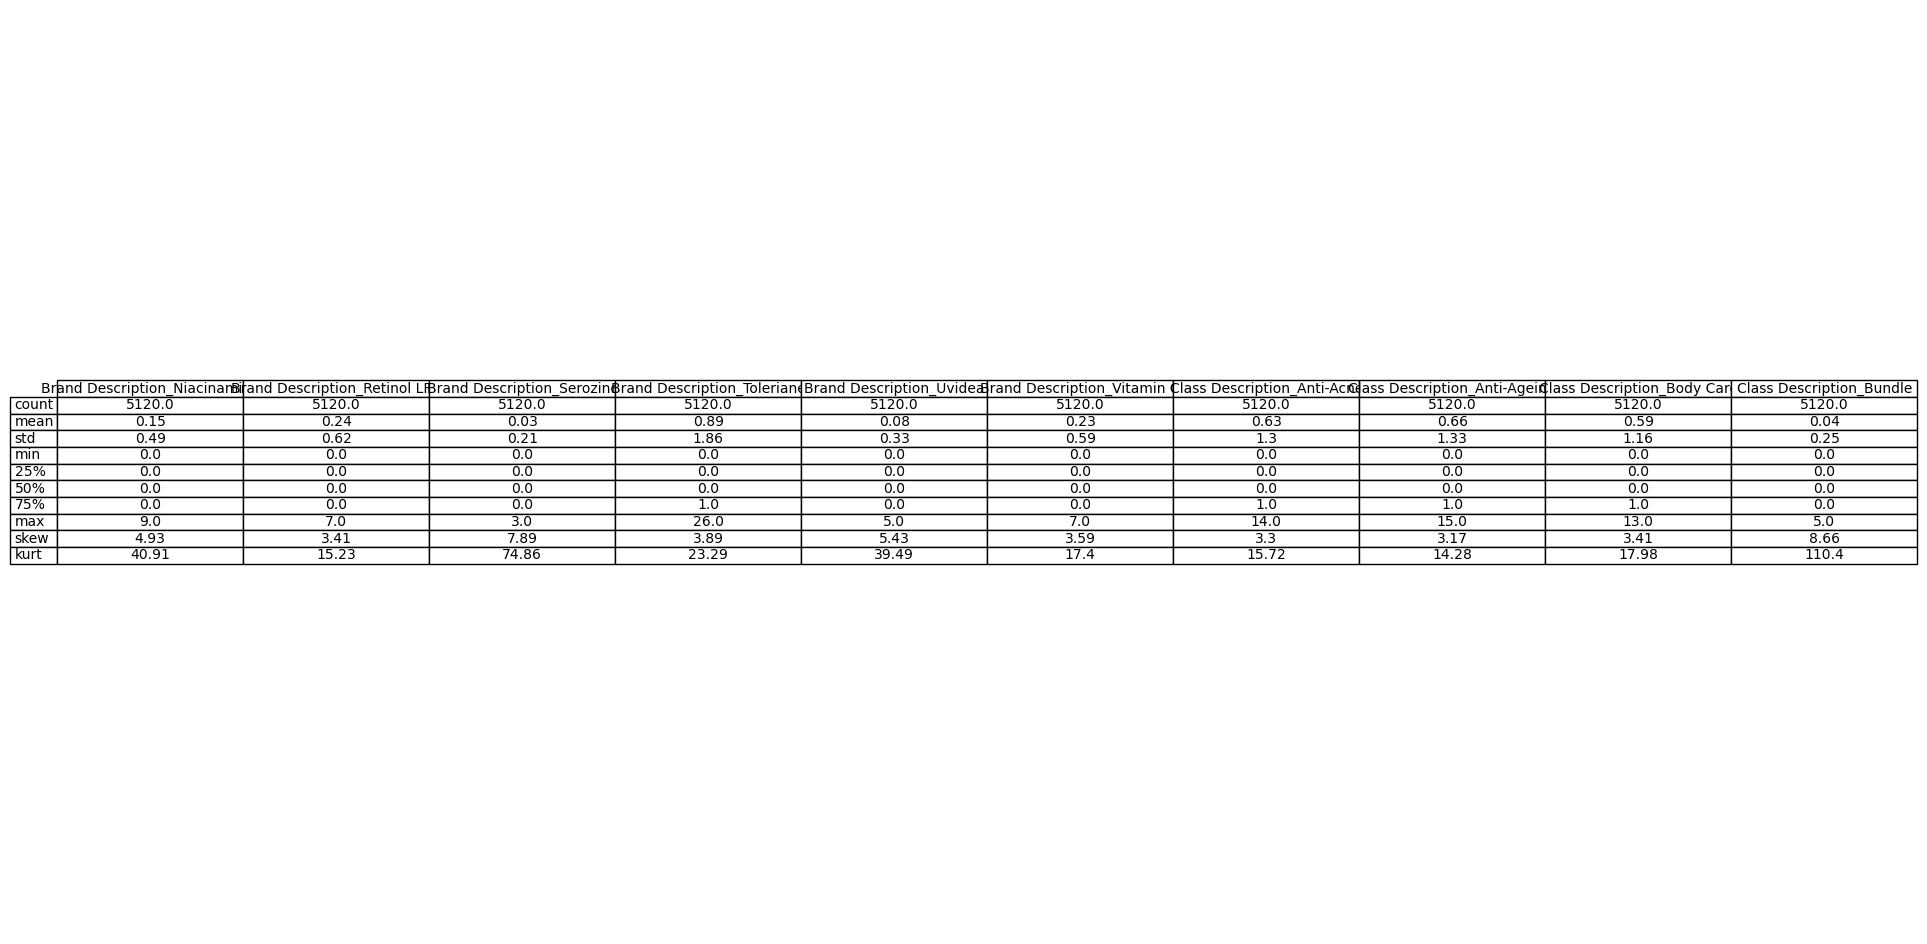

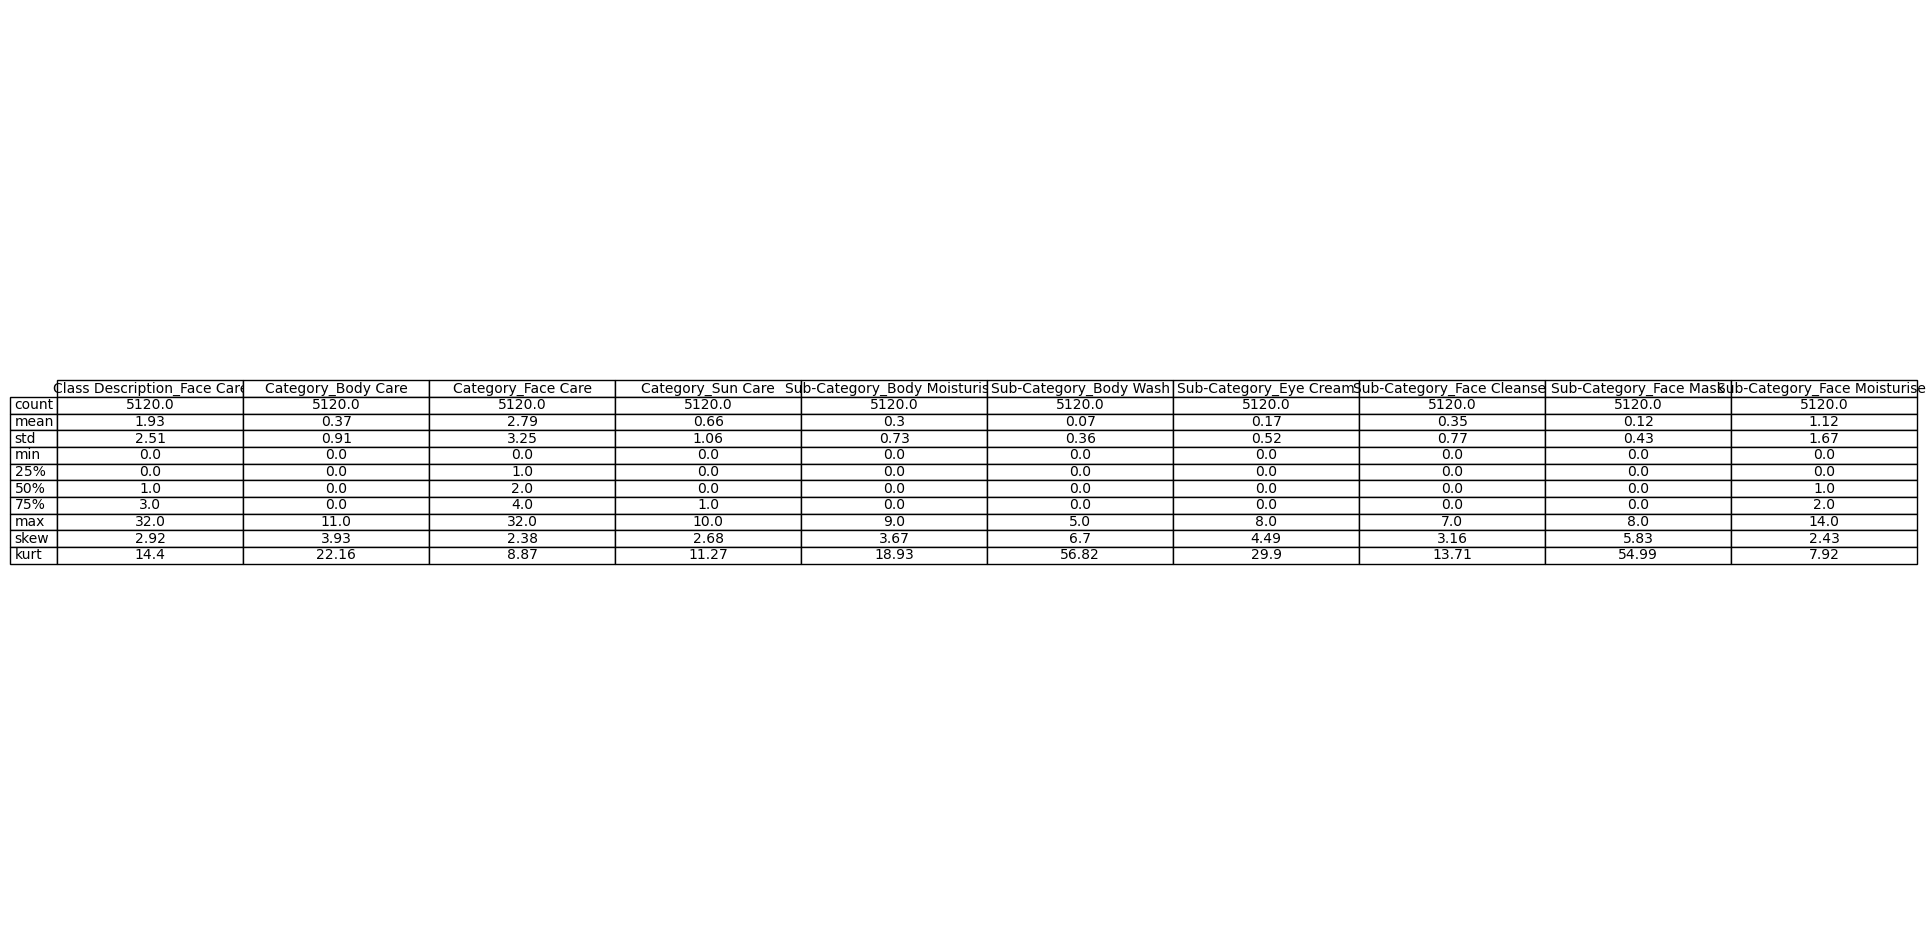

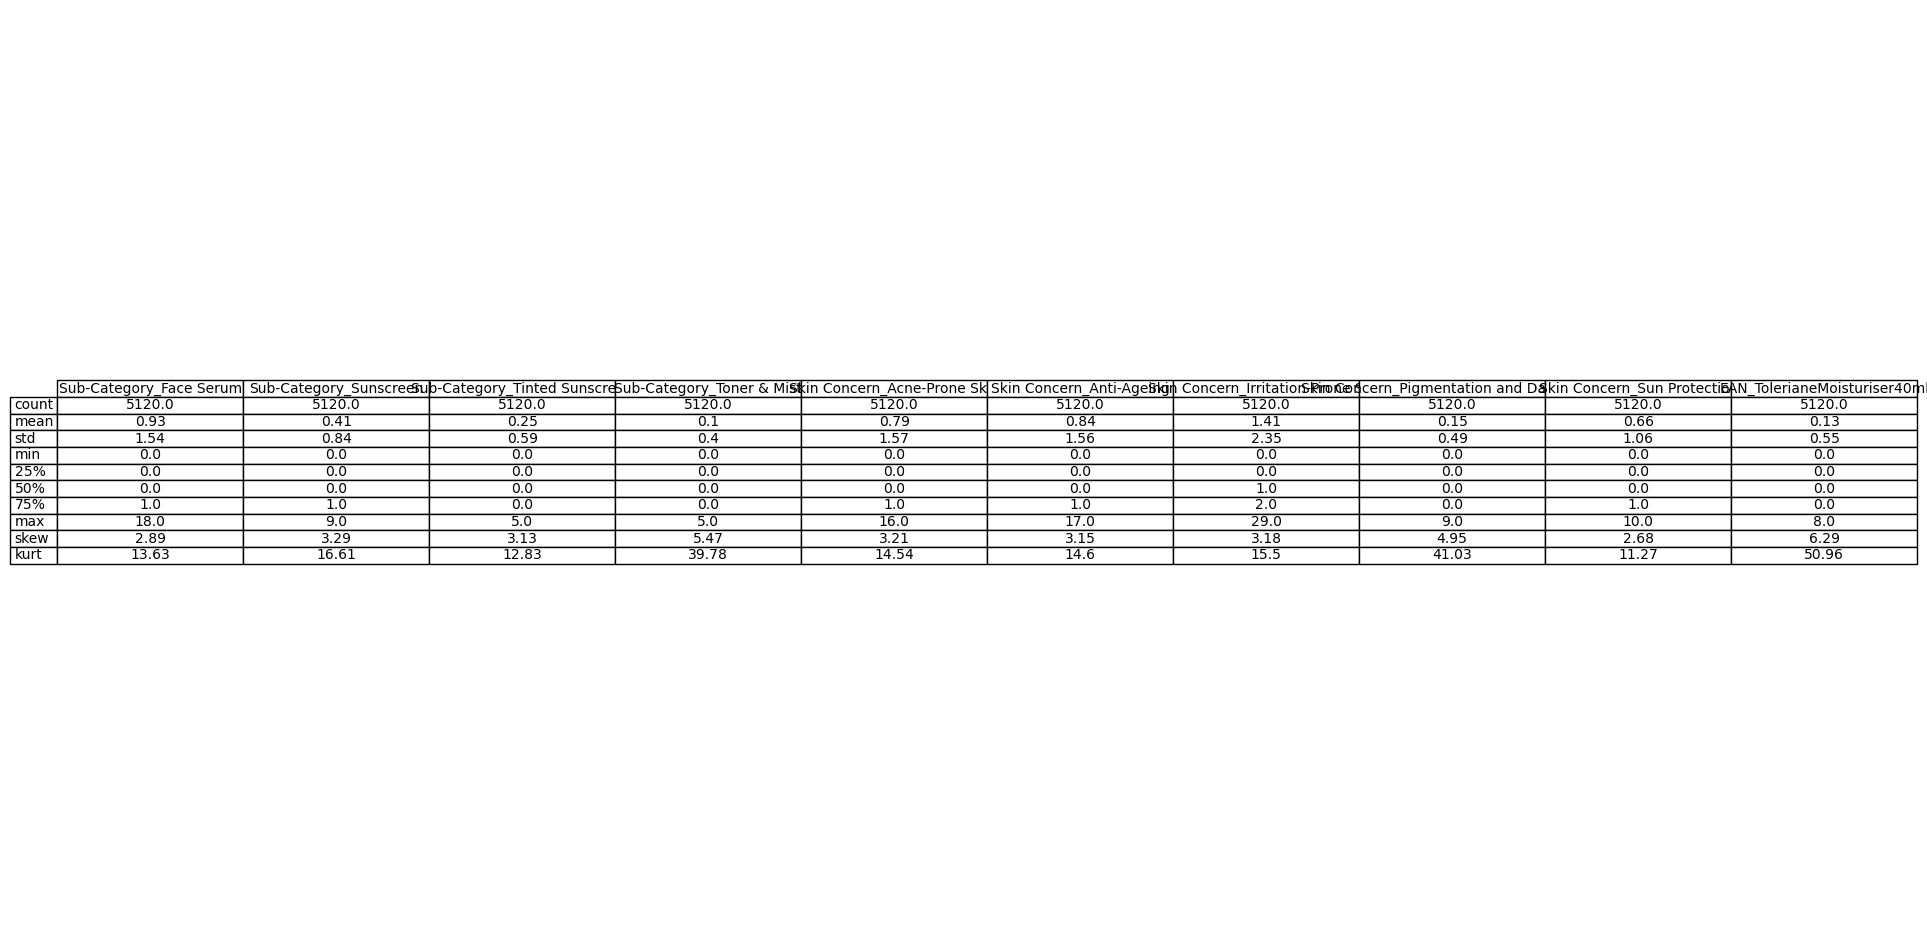

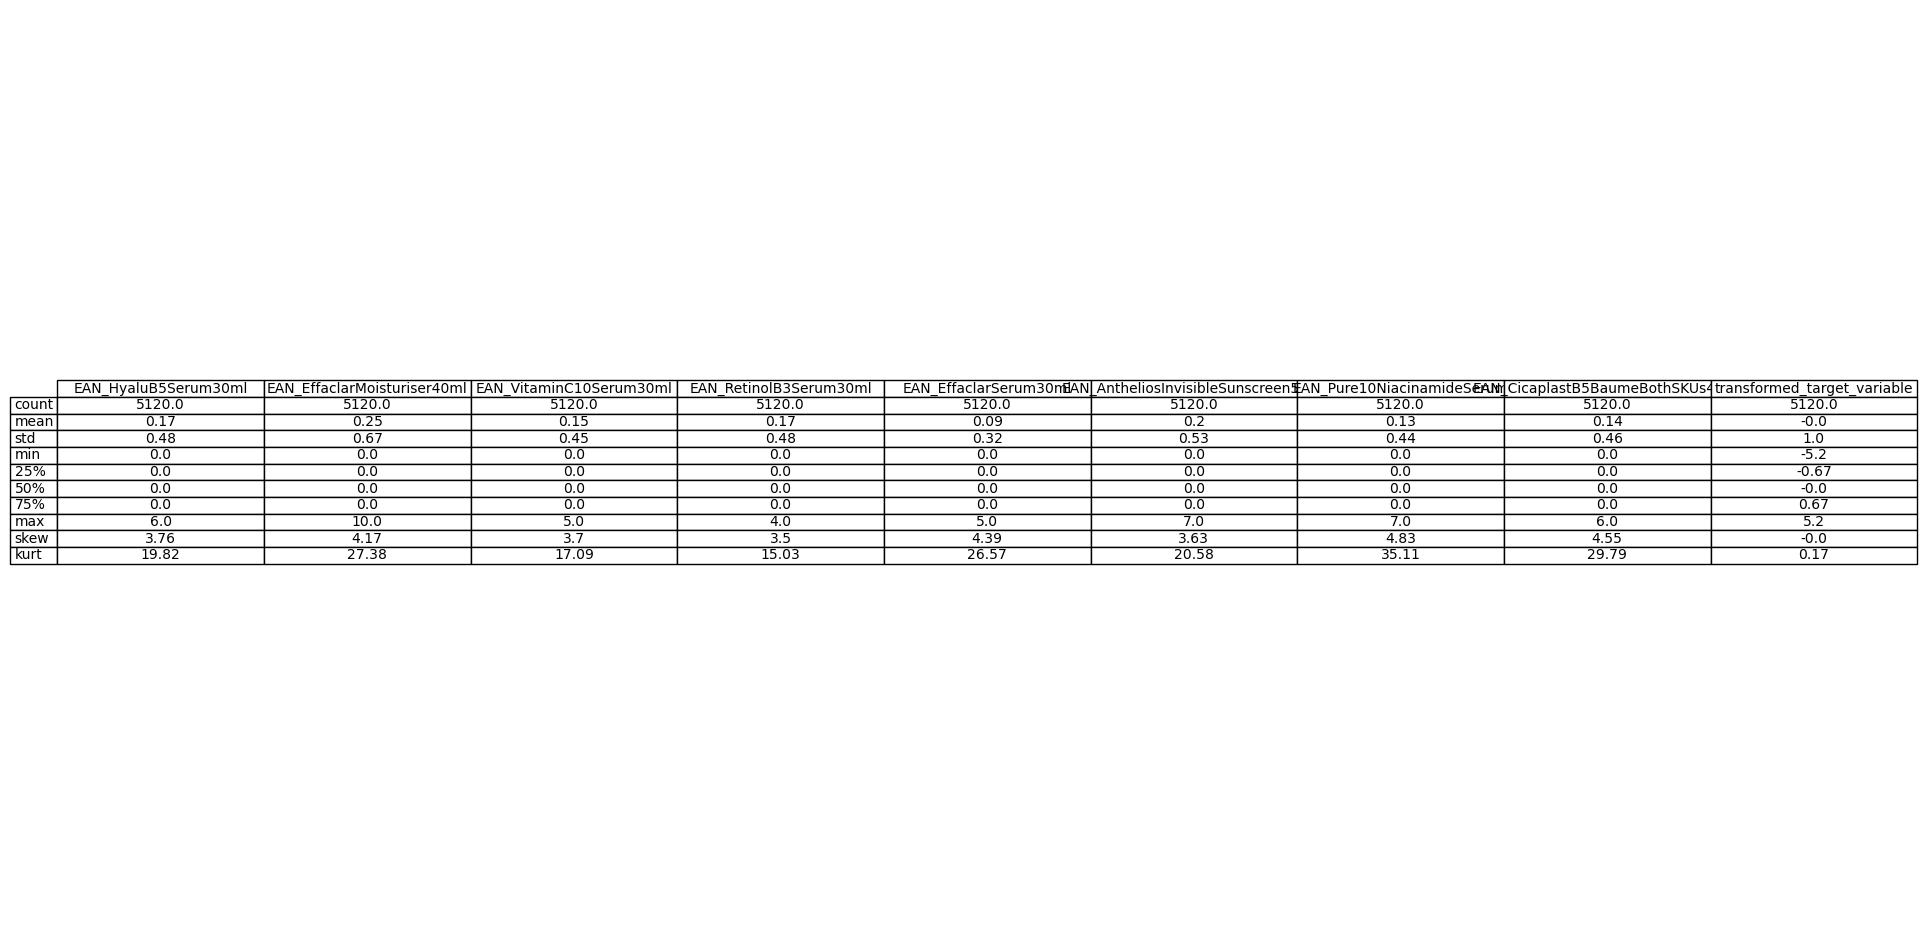

In [17]:
desc = data_train.describe().round(2)
desc.loc['skew'] = data_train.skew().round(2)
desc.loc['kurt'] = data_train.kurt().round(2)
chunk_size =10
# Split the DataFrame into smaller chunks (e.g., 10 columns per chunk)
chunks = [desc.iloc[:, i:i+chunk_size] for i in range(0, desc.shape[1], chunk_size)]

# Plot each chunk as a separate table without saving to reduce processing time
for idx, chunk in enumerate(chunks):
    fig, ax = plt.subplots(figsize=(24, 12))  # Adjust size as needed
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=chunk.values, colLabels=chunk.columns, rowLabels=chunk.index, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    
    # Display the table
    plt.show()

### 5. Bivariate EDA

#### 5.1 Time-related variables

#### 5.1.1 Distribution analysis of Time-related variables 

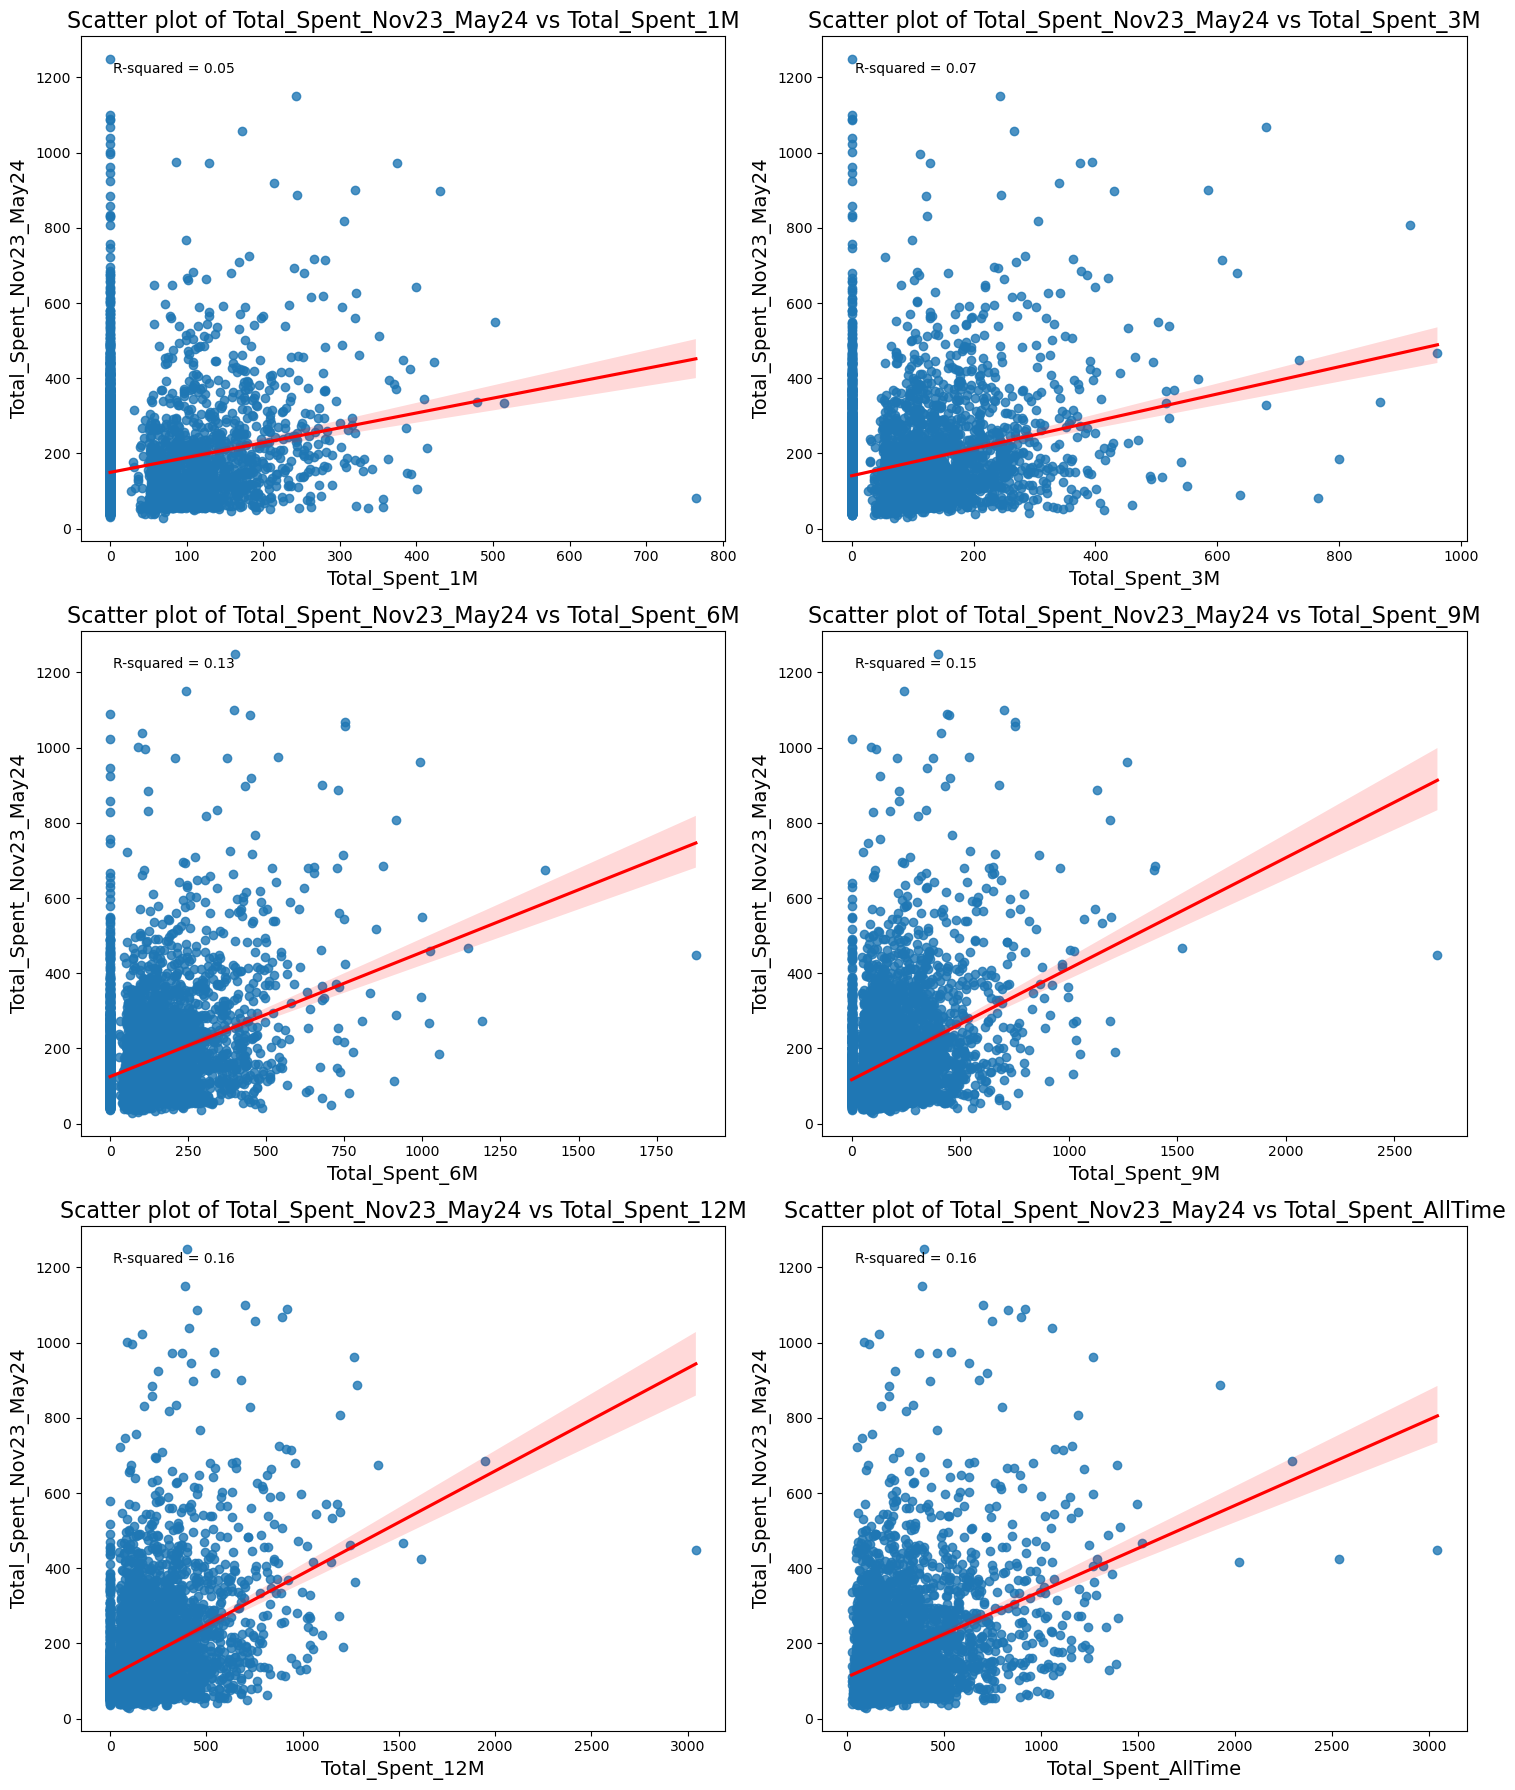

In [18]:
import statsmodels.api as sm
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()  
columns_spent = ['Total_Spent_1M',
       'Total_Spent_3M', 'Total_Spent_6M', 'Total_Spent_9M', 
       'Total_Spent_12M', 'Total_Spent_AllTime']
for i, column in enumerate(columns_spent):
        sns.regplot(x=data_train[column], y=data_train[target_variable], line_kws={"color": "red"}, ax=axes[i])
        X = data_train[column]
        y = data_train[target_variable]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        r_squared = model.rsquared
        
        axes[i].text(0.05, 0.95, f'R-squared = {r_squared:.2f}', ha='left', va='top', transform=axes[i].transAxes)
        axes[i].set_title(f'Scatter plot of {target_variable} vs {column}', size=16)
        axes[i].set_xlabel(column, size=14)
        axes[i].set_ylabel(target_variable, size=14)

plt.tight_layout()
plt.savefig('Appendix H')
plt.show()

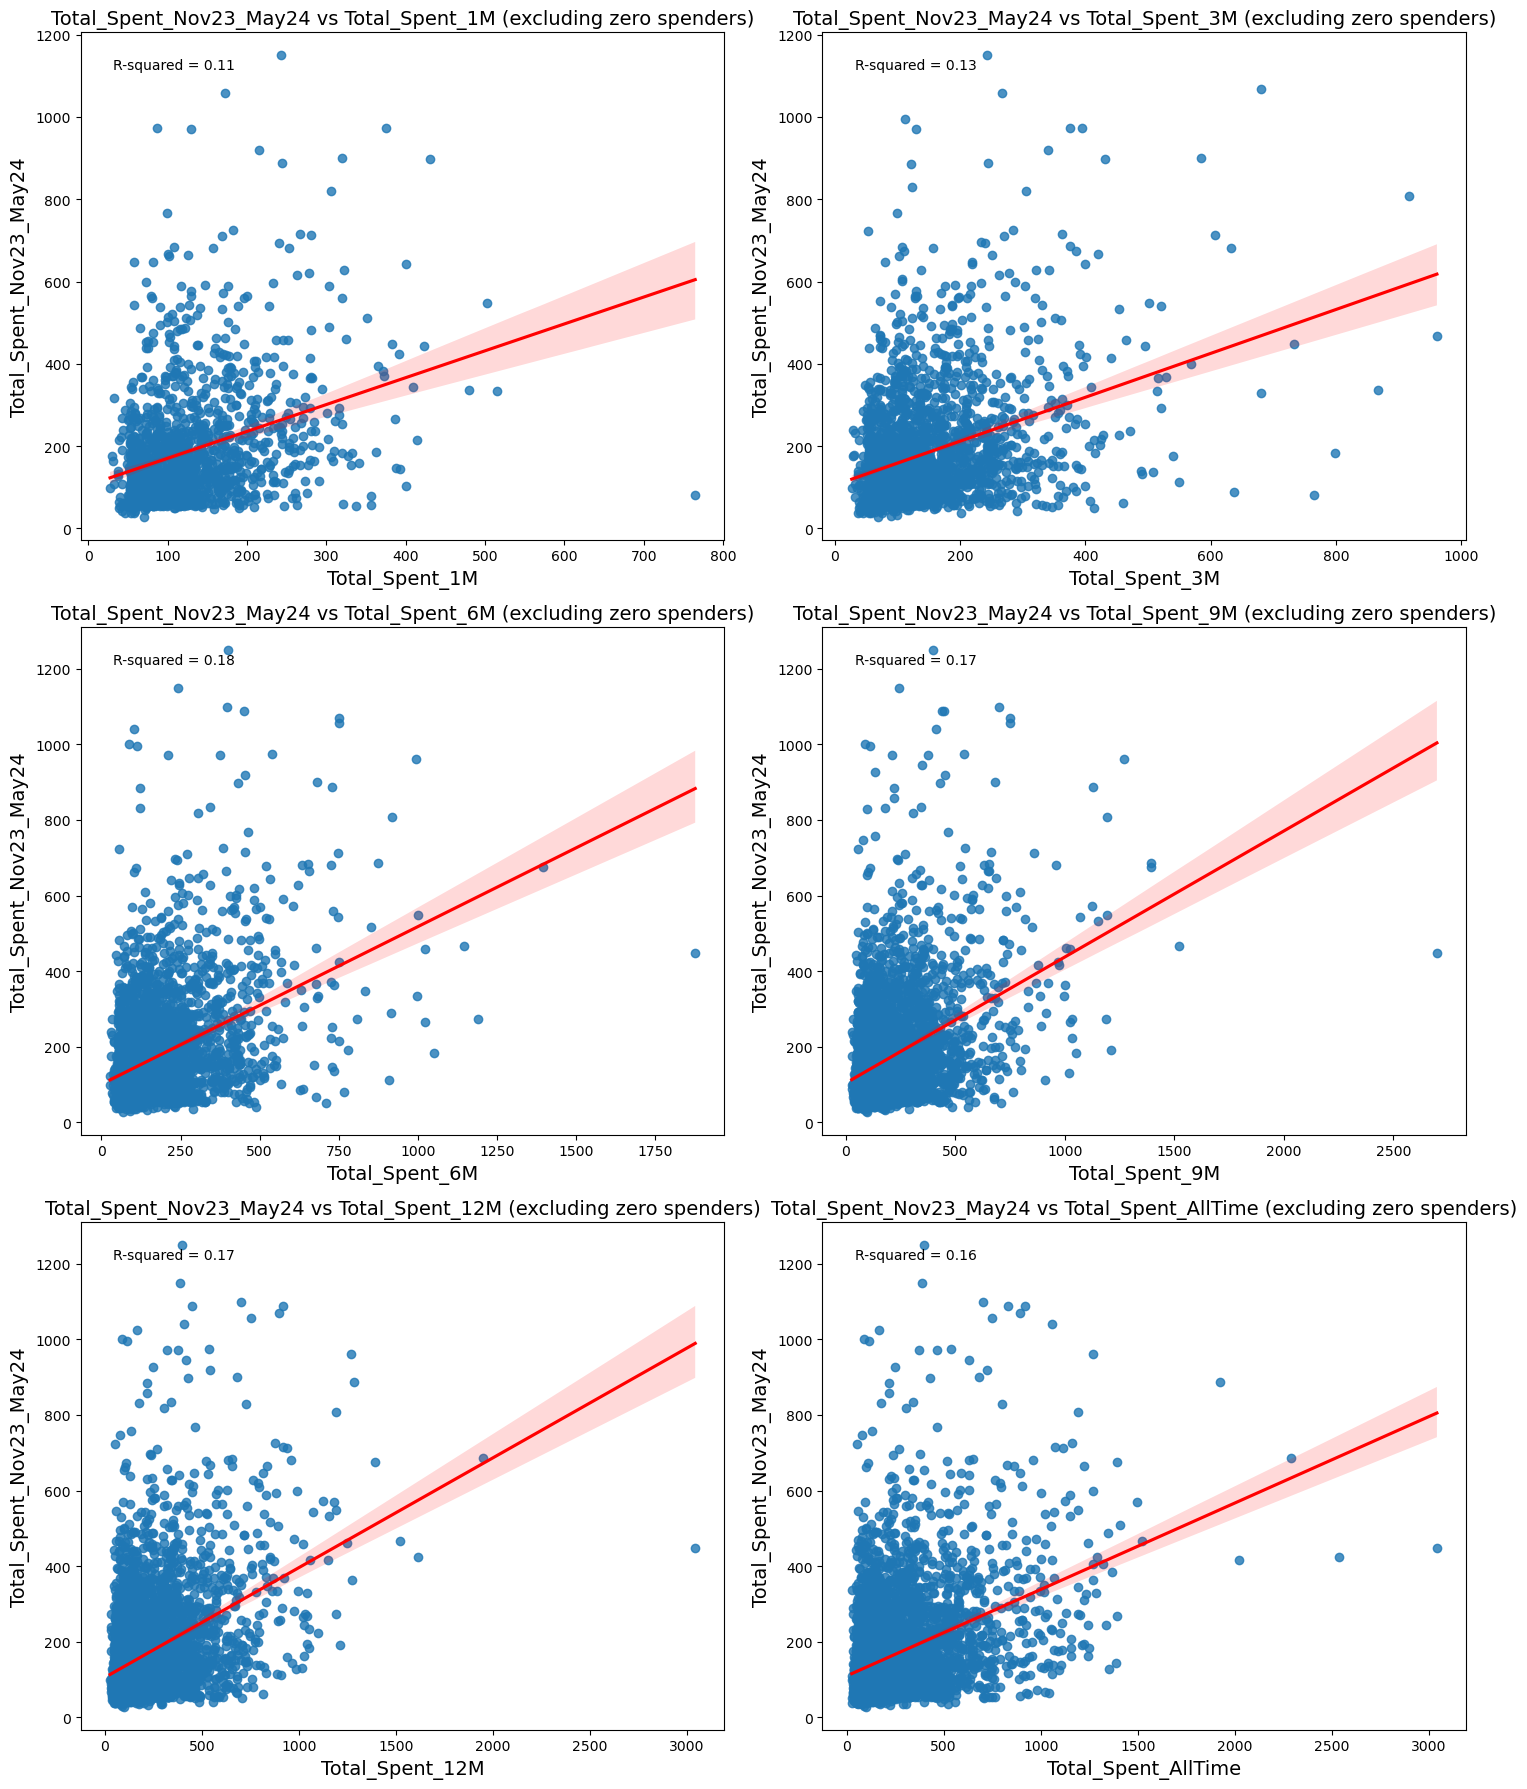

In [19]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

columns_spent = ['Total_Spent_1M', 'Total_Spent_3M', 'Total_Spent_6M', 
                 'Total_Spent_9M', 'Total_Spent_12M', 'Total_Spent_AllTime']

fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()


for i, column in enumerate(columns_spent):
    filtered_data = data_train[data_train[column] > 0]
    X = filtered_data[column]
    y = filtered_data[target_variable]
    
    sns.regplot(x=X, y=y, line_kws={"color": "red"}, ax=axes[i])
    
    X_with_constant = sm.add_constant(X)
    model = sm.OLS(y, X_with_constant).fit()
    r_squared = model.rsquared
    
    axes[i].text(0.05, 0.95, f'R-squared = {r_squared:.2f}', ha='left', va='top', transform=axes[i].transAxes)
    
    axes[i].set_title(f'{target_variable} vs {column} (excluding zero spenders)', size=14)
    axes[i].set_xlabel(column, size=14)
    axes[i].set_ylabel(target_variable, size=14)

plt.tight_layout()
plt.savefig('Appendix I')
plt.show()

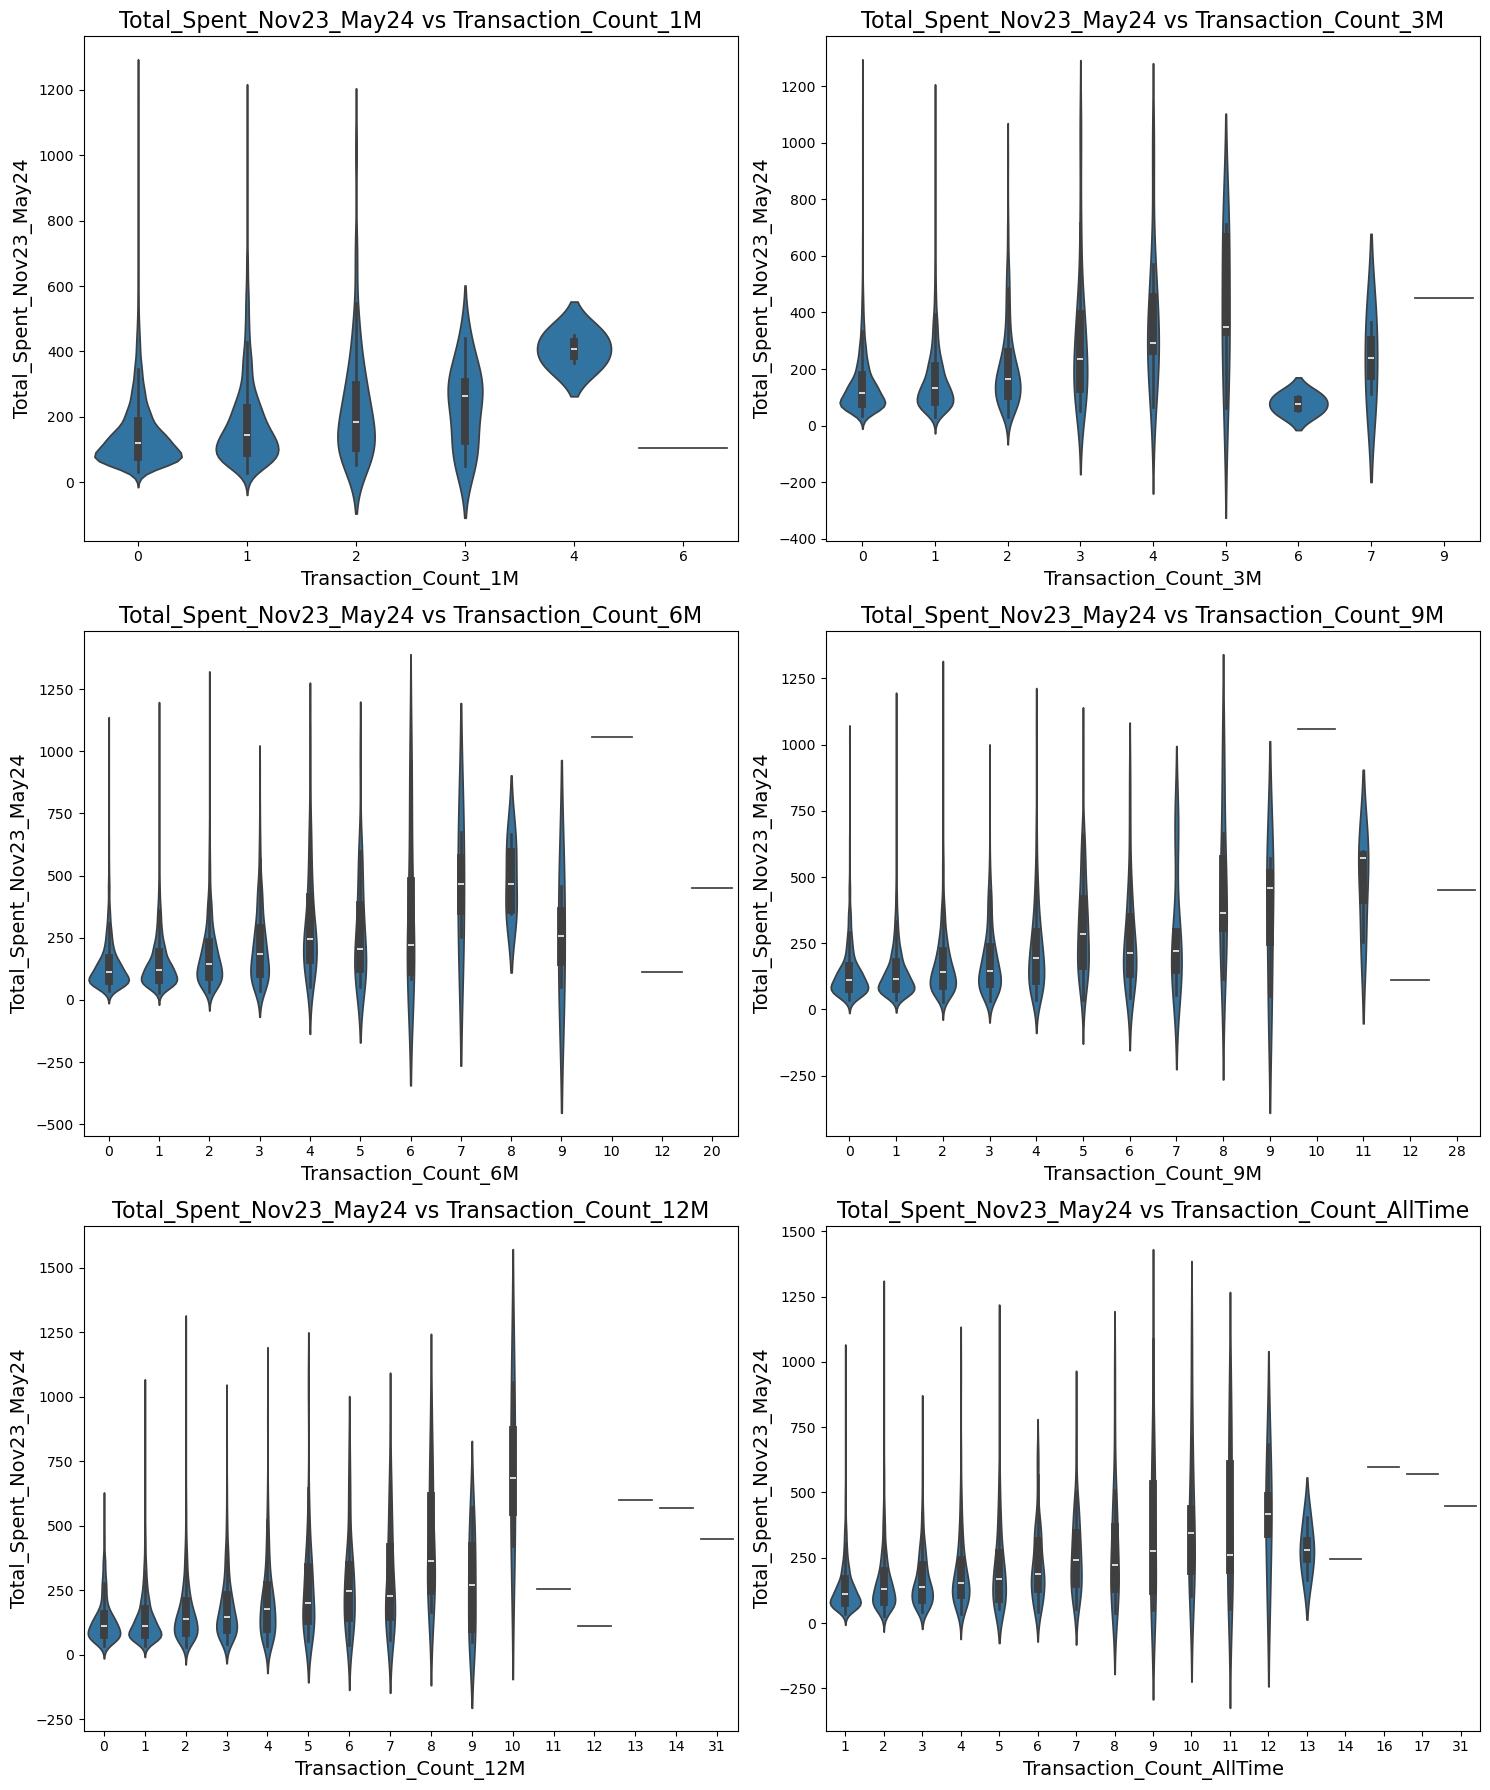

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()  
columns_count=['Transaction_Count_1M','Transaction_Count_3M',
               'Transaction_Count_6M', 'Transaction_Count_9M',
               'Transaction_Count_12M', 'Transaction_Count_AllTime']
target_variable='Total_Spent_Nov23_May24'
for i, column in enumerate(columns_count):
    sns.violinplot(x=data_train[column], y=data_train[target_variable], ax=axes[i])
    axes[i].set_title(f'{target_variable} vs {column}', size=16)
    axes[i].set_xlabel(column, size=14)
    axes[i].set_ylabel(target_variable, size=14)

plt.tight_layout()
plt.savefig('Appendix G')
plt.show()

#### 5.2 Time Pattern Analysis

In [21]:
data_train['Spent_Change_6M_to_3M'] = data_train['Total_Spent_6M'] - data_train['Total_Spent_3M']
data_train['Spent_Change_9M_to_6M'] = data_train['Total_Spent_9M'] - data_train['Total_Spent_6M']
data_train['Spent_Change_12M_to_9M'] = data_train['Total_Spent_12M'] - data_train['Total_Spent_9M']

data_train['Count_Change_6M_to_3M'] = data_train['Transaction_Count_6M'] - data_train['Transaction_Count_3M']
data_train['Count_Change_9M_to_6M'] = data_train['Transaction_Count_9M'] - data_train['Transaction_Count_6M']
data_train['Count_Change_12M_to_9M'] = data_train['Transaction_Count_12M'] - data_train['Transaction_Count_9M']

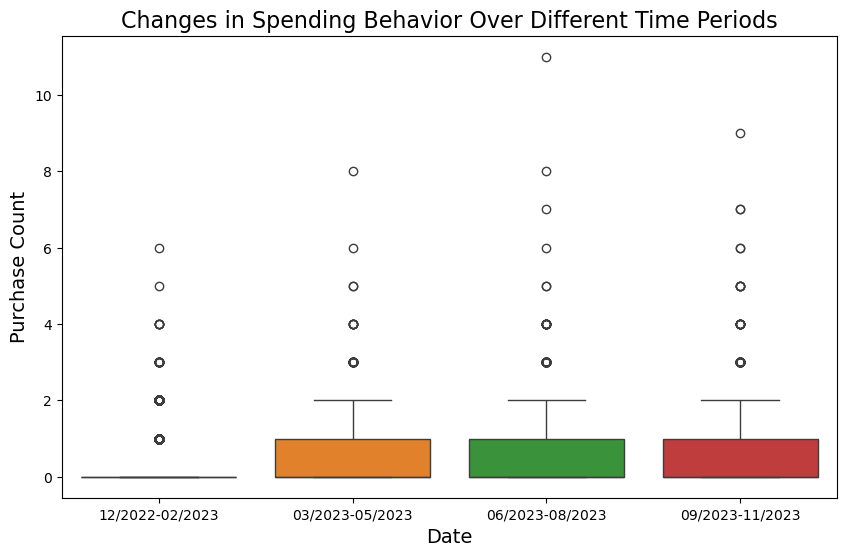

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=[data_train['Count_Change_12M_to_9M'],data_train['Count_Change_9M_to_6M'],
                 data_train['Count_Change_6M_to_3M'],data_train['Transaction_Count_3M']])

plt.xticks([0, 1, 2, 3], ['12/2022-02/2023',
                             '03/2023-05/2023',
                             '06/2023-08/2023',
                             '09/2023-11/2023']) 

plt.title('Changes in Spending Behavior Over Different Time Periods', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Purchase Count', fontsize=14)
plt.savefig('Changes in Spending Behavior Over Different Time Periods.png')
plt.show()

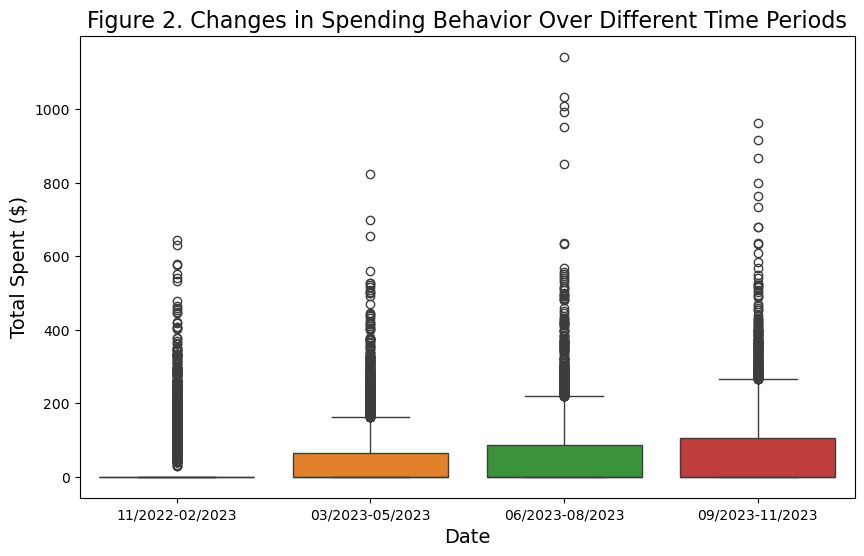

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=[data_train['Spent_Change_12M_to_9M'],data_train['Spent_Change_9M_to_6M'],
                 data_train['Spent_Change_6M_to_3M'],data_train['Total_Spent_3M']])

plt.xticks([0, 1, 2, 3], ['11/2022-02/2023',
                             '03/2023-05/2023',
                             '06/2023-08/2023',
                             '09/2023-11/2023']) 

plt.title('Figure 2. Changes in Spending Behavior Over Different Time Periods', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Spent ($)', fontsize=14)
plt.savefig('Figure 2. Changes in Spending Behavior Over Different Time Periods.png')
plt.show()

#### 5.2.3 Comparison of High and Low Spending Customers by Brand and Season

In [24]:
data_train['average_spent_inspring']=data_train.apply(
    lambda row: row['Total_Spent_3M'] / row['Transaction_Count_3M'] if row['Transaction_Count_3M'] > 0 else 0, 
    axis=1
)

data_train['average_spent_insummer']=data_train.apply(
    lambda row: row['Spent_Change_12M_to_9M'] / row['Count_Change_12M_to_9M'] if row['Count_Change_12M_to_9M'] > 0 else 0, 
    axis=1
)

data_train['average_spent_inautumn']=data_train.apply(
    lambda row: row['Spent_Change_9M_to_6M'] / row['Count_Change_9M_to_6M'] if row['Count_Change_9M_to_6M'] > 0 else 0, 
    axis=1
)

data_train['average_spent_inwinter']=data_train.apply(
    lambda row: row['Spent_Change_6M_to_3M'] / row['Count_Change_6M_to_3M'] if row['Count_Change_6M_to_3M'] > 0 else 0, 
    axis=1
)

In [25]:
data_train.columns

Index(['CustomerID', 'Total_Spent_Nov23_May24', 'Total_Spent_1M',
       'Transaction_Count_1M', 'Total_Spent_3M', 'Transaction_Count_3M',
       'Total_Spent_6M', 'Transaction_Count_6M', 'Total_Spent_9M',
       'Transaction_Count_9M', 'Total_Spent_12M', 'Transaction_Count_12M',
       'Total_Spent_AllTime', 'Transaction_Count_AllTime',
       'Brand Description_Anthelios', 'Brand Description_Bundle',
       'Brand Description_Cicaplast', 'Brand Description_Eau Thermale',
       'Brand Description_Effaclar', 'Brand Description_Hyalu B5',
       'Brand Description_Lipikar', 'Brand Description_Niacinamide',
       'Brand Description_Retinol LRP', 'Brand Description_Serozinc',
       'Brand Description_Toleriane', 'Brand Description_Uvidea',
       'Brand Description_Vitamin C', 'Class Description_Anti-Acne',
       'Class Description_Anti-Ageing', 'Class Description_Body Care',
       'Class Description_Bundle', 'Class Description_Face Care',
       'Category_Body Care', 'Category_Face 

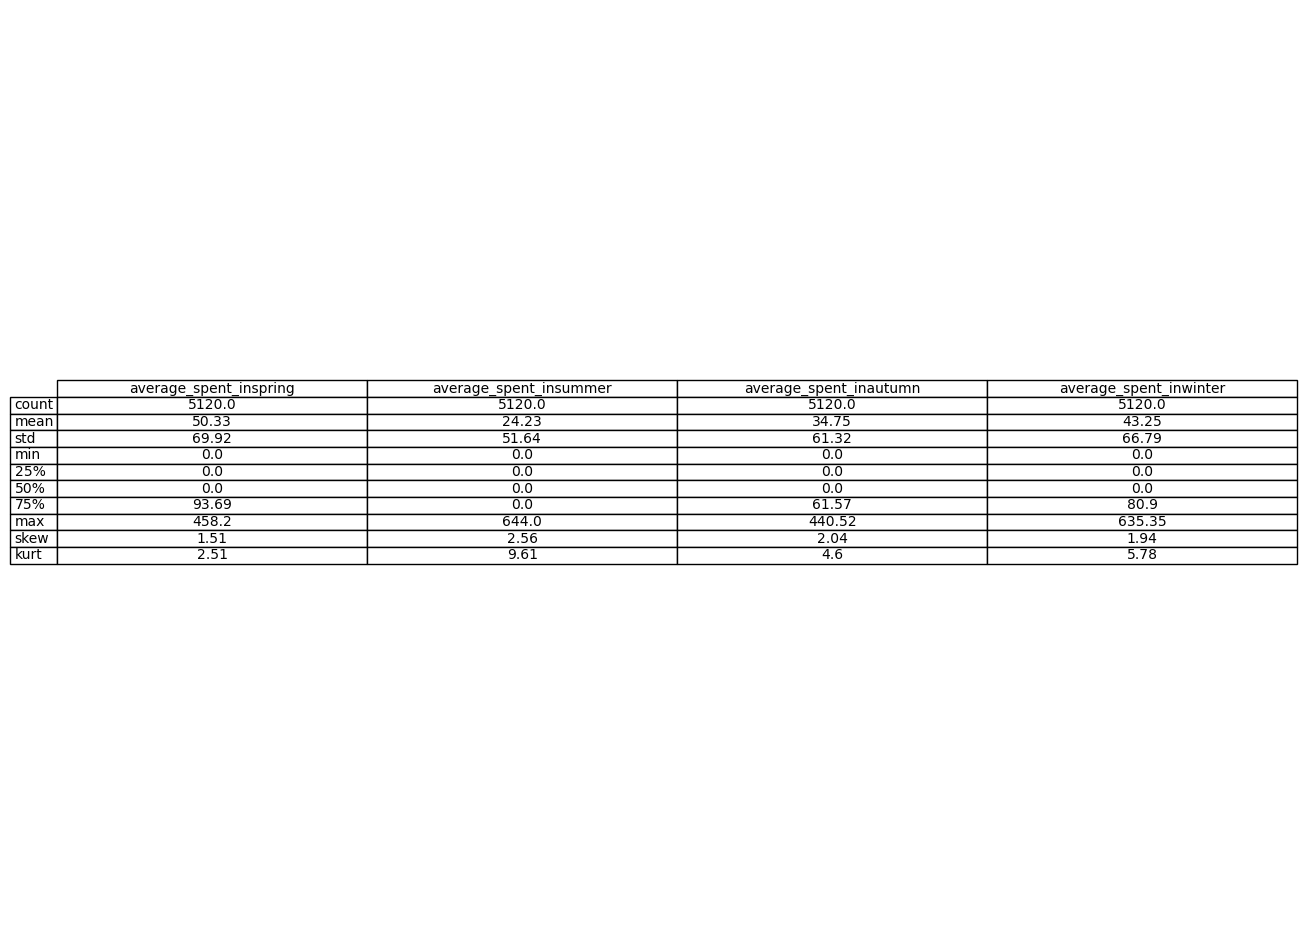

In [26]:
desc = data_train[['average_spent_inspring',
       'average_spent_insummer', 'average_spent_inautumn',
       'average_spent_inwinter']].describe().round(2)
desc.loc['skew'] = data_train.skew().round(2)
desc.loc['kurt'] = data_train.kurt().round(2)
chunk_size =4
# Split the DataFrame into smaller chunks (e.g., 10 columns per chunk)
chunks = [desc.iloc[:, i:i+chunk_size] for i in range(0, desc.shape[1], chunk_size)]

# Plot each chunk as a separate table without saving to reduce processing time
for idx, chunk in enumerate(chunks):
    fig, ax = plt.subplots(figsize=(16, 12))  # Adjust size as needed
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=chunk.values, colLabels=chunk.columns, rowLabels=chunk.index, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    
    # Display the table
    plt.show()

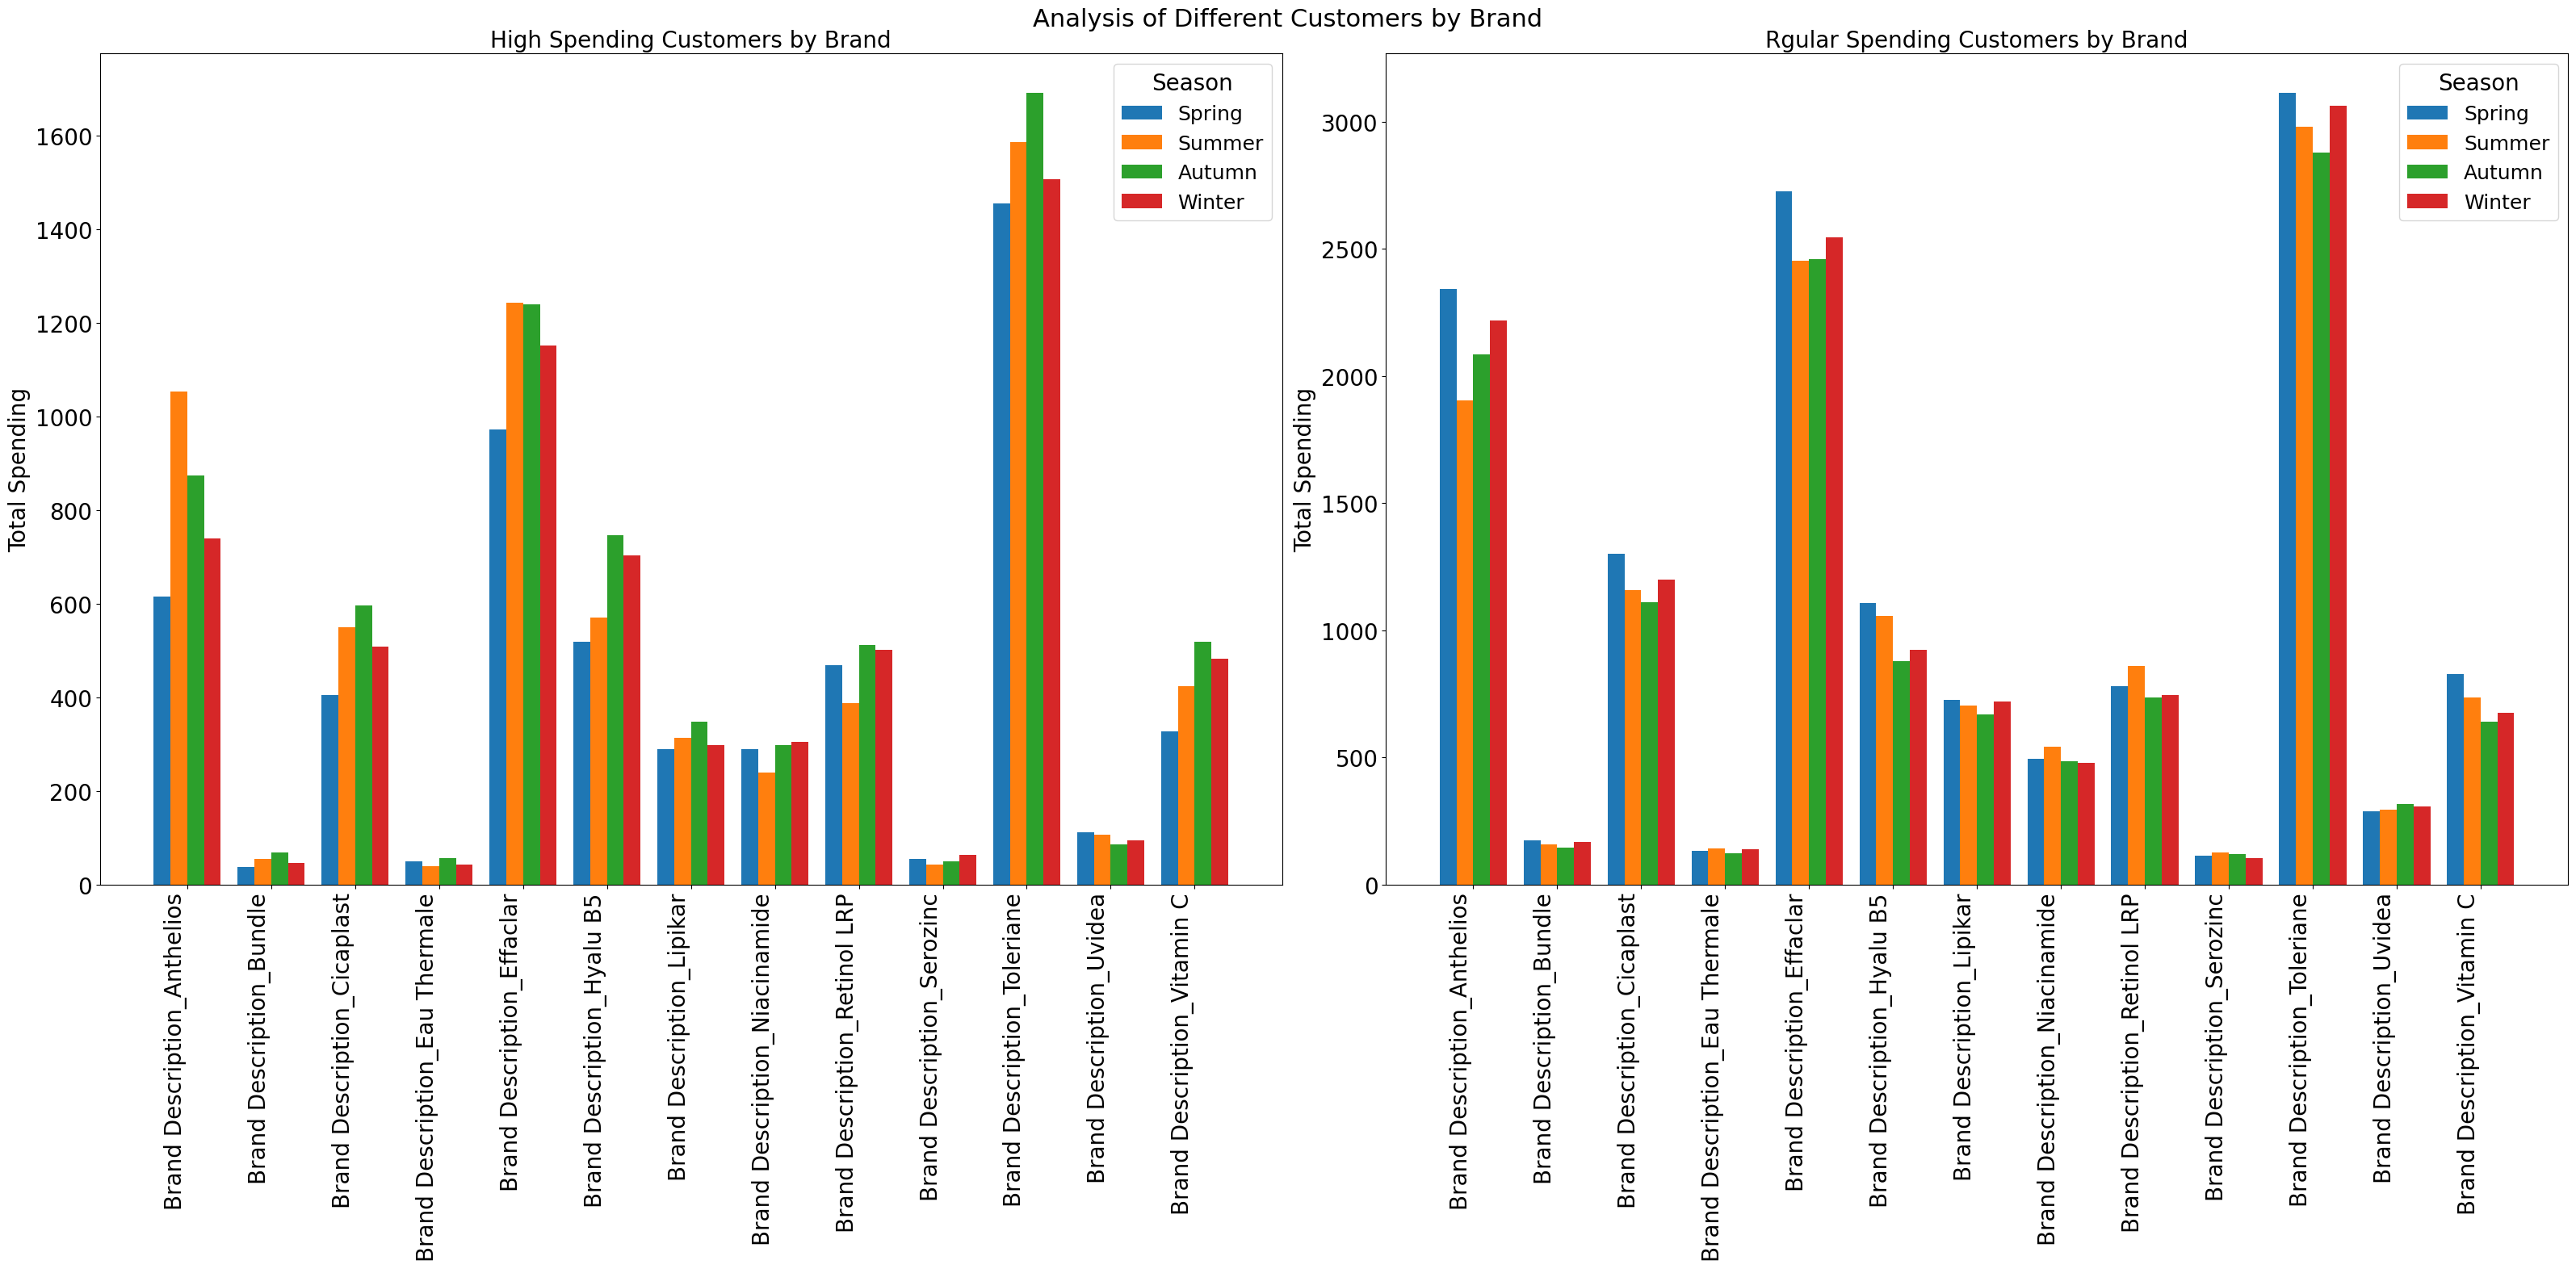

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

high_spent_spring = data_train[data_train['average_spent_inspring'] > 108]
low_spent_spring = data_train[data_train['average_spent_inspring'] <= 108]

high_spent_summer = data_train[data_train['average_spent_insummer'] > 60]
low_spent_summer = data_train[data_train['average_spent_insummer'] <= 60]

high_spent_autumn = data_train[data_train['average_spent_inautumn'] > 80]
low_spent_autumn = data_train[data_train['average_spent_inautumn'] <= 80]

high_spent_winter = data_train[data_train['average_spent_inwinter'] > 95]
low_spent_winter = data_train[data_train['average_spent_inwinter'] <= 95]


brands = ['Brand Description_Anthelios', 'Brand Description_Bundle', 
          'Brand Description_Cicaplast', 'Brand Description_Eau Thermale', 
          'Brand Description_Effaclar', 'Brand Description_Hyalu B5', 
          'Brand Description_Lipikar', 'Brand Description_Niacinamide', 
          'Brand Description_Retinol LRP', 'Brand Description_Serozinc', 
          'Brand Description_Toleriane', 'Brand Description_Uvidea', 
          'Brand Description_Vitamin C']

def calculate_brand_spending(df, brands):
    return df[brands].sum()

seasons = ['spring', 'summer', 'autumn', 'winter']
high_spending = [
    calculate_brand_spending(high_spent_spring, brands),
    calculate_brand_spending(high_spent_summer, brands),
    calculate_brand_spending(high_spent_autumn, brands),
    calculate_brand_spending(high_spent_winter, brands)
]

low_spending = [
    calculate_brand_spending(low_spent_spring, brands),
    calculate_brand_spending(low_spent_summer, brands),
    calculate_brand_spending(low_spent_autumn, brands),
    calculate_brand_spending(low_spent_winter, brands)
]

seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
high_spending_df = pd.DataFrame(high_spending, index=seasons, columns=brands).T
low_spending_df = pd.DataFrame(low_spending, index=seasons, columns=brands).T

bar_width = 0.2
x = np.arange(len(brands))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16))

for i, season in enumerate(seasons):
    ax1.bar(x + i * bar_width, high_spending_df[season], bar_width, label=season)

ax1.set_title('High Spending Customers by Brand', fontsize=20)
ax1.set_xlabel('')
ax1.set_ylabel('Total Spending', fontsize=20)
ax1.set_xticks(x + bar_width * (len(seasons) / 2 - 0.5))
ax1.set_xticklabels(brands, rotation=90, ha='right',fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.legend(title='Season', loc='upper right', title_fontsize=20,prop={'size': 18})

for i, season in enumerate(seasons):
    ax2.bar(x + i * bar_width, low_spending_df[season], bar_width, label=season)

ax2.set_title('Rgular Spending Customers by Brand',fontsize=20)
ax2.set_xlabel('')
ax2.set_ylabel('Total Spending',fontsize=20)
ax2.set_xticks(x + bar_width * (len(seasons) / 2 - 0.5))
ax2.set_xticklabels(brands, rotation=90, ha='right',fontsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.legend(title='Season', loc='upper right', title_fontsize=20,prop={'size': 18})

plt.suptitle('Analysis of Different Customers by Brand', size=22)
plt.tight_layout()
plt.savefig('Different Customers by Brand.png')
plt.show()

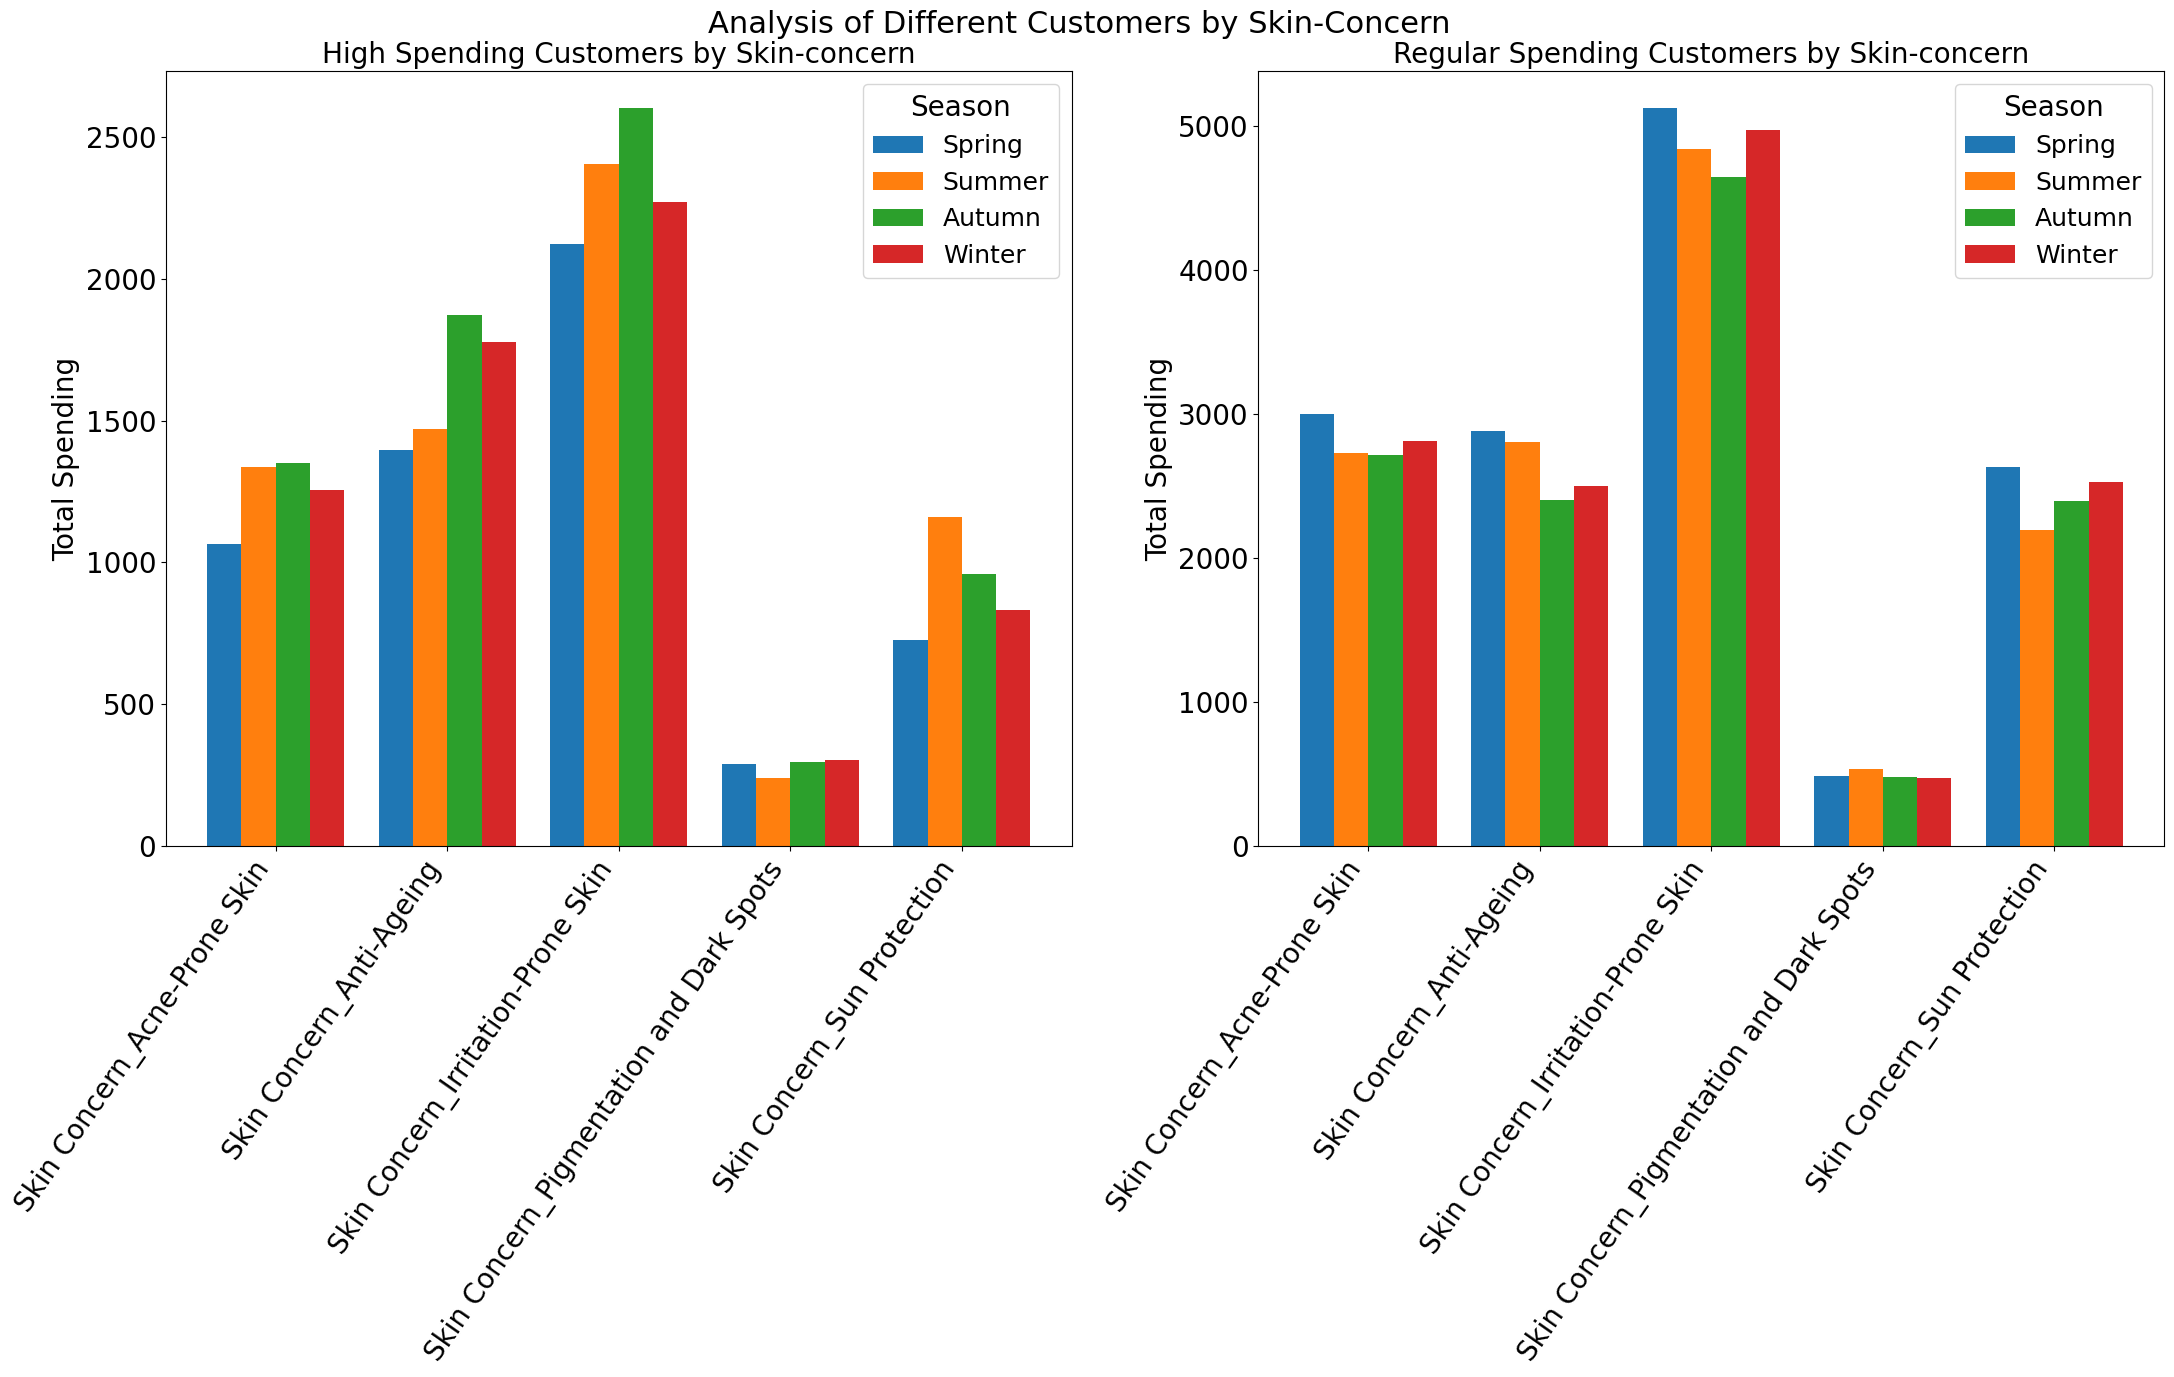

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

high_spent_spring = data_train[data_train['average_spent_inspring'] > 108]
low_spent_spring = data_train[data_train['average_spent_inspring'] <= 108]

high_spent_summer = data_train[data_train['average_spent_insummer'] > 60]
low_spent_summer = data_train[data_train['average_spent_insummer'] <= 60]

high_spent_autumn = data_train[data_train['average_spent_inautumn'] > 80]
low_spent_autumn = data_train[data_train['average_spent_inautumn'] <= 80]

high_spent_winter = data_train[data_train['average_spent_inwinter'] > 95]
low_spent_winter = data_train[data_train['average_spent_inwinter'] <= 95]

skin_concern = [
'Skin Concern_Acne-Prone Skin', 'Skin Concern_Anti-Ageing',
       'Skin Concern_Irritation-Prone Skin',
       'Skin Concern_Pigmentation and Dark Spots',
       'Skin Concern_Sun Protection'
]

def calculate_brand_spending(df, skin_concern):
    return df[skin_concern].sum()

seasons = ['spring', 'summer', 'autumn', 'winter']
high_spending = [
    calculate_brand_spending(high_spent_spring, skin_concern),
    calculate_brand_spending(high_spent_summer, skin_concern),
    calculate_brand_spending(high_spent_autumn, skin_concern),
    calculate_brand_spending(high_spent_winter, skin_concern)
]

low_spending = [
    calculate_brand_spending(low_spent_spring, skin_concern),
    calculate_brand_spending(low_spent_summer, skin_concern),
    calculate_brand_spending(low_spent_autumn, skin_concern),
    calculate_brand_spending(low_spent_winter, skin_concern)
]

seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
high_spending_df = pd.DataFrame(high_spending, index=seasons, columns=skin_concern).T
low_spending_df = pd.DataFrame(low_spending, index=seasons, columns=skin_concern).T

bar_width = 0.2
x = np.arange(len(skin_concern))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 14))

for i, season in enumerate(seasons):
    ax1.bar(x + i * bar_width, high_spending_df[season], bar_width, label=season)

ax1.set_title('High Spending Customers by Skin-concern',fontsize=20)
ax1.set_xlabel('')
ax1.set_ylabel('Total Spending',fontsize=20)
ax1.set_xticks(x + bar_width * (len(seasons) / 2 - 0.5))
ax1.set_xticklabels(skin_concern, rotation=55, ha='right',fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.legend(title='Season', loc='upper right',title_fontsize=20,prop={'size': 18})

for i, season in enumerate(seasons):
    ax2.bar(x + i * bar_width, low_spending_df[season], bar_width, label=season)

ax2.set_title('Regular Spending Customers by Skin-concern',fontsize=20)
ax2.set_xlabel('')
ax2.set_ylabel('Total Spending',fontsize=20)
ax2.set_xticks(x + bar_width * (len(seasons) / 2 - 0.5))
ax2.set_xticklabels(skin_concern, rotation=55, ha='right',fontsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.legend(title='Season', loc='upper right', title_fontsize=20, prop={'size': 18})

plt.suptitle('Analysis of Different Customers by Skin-Concern', size=22)
plt.tight_layout()
plt.savefig('Different Customers by Skin-Concern.png')
plt.show()

Product Subcategory Preferences: High vs Low Spent By Season

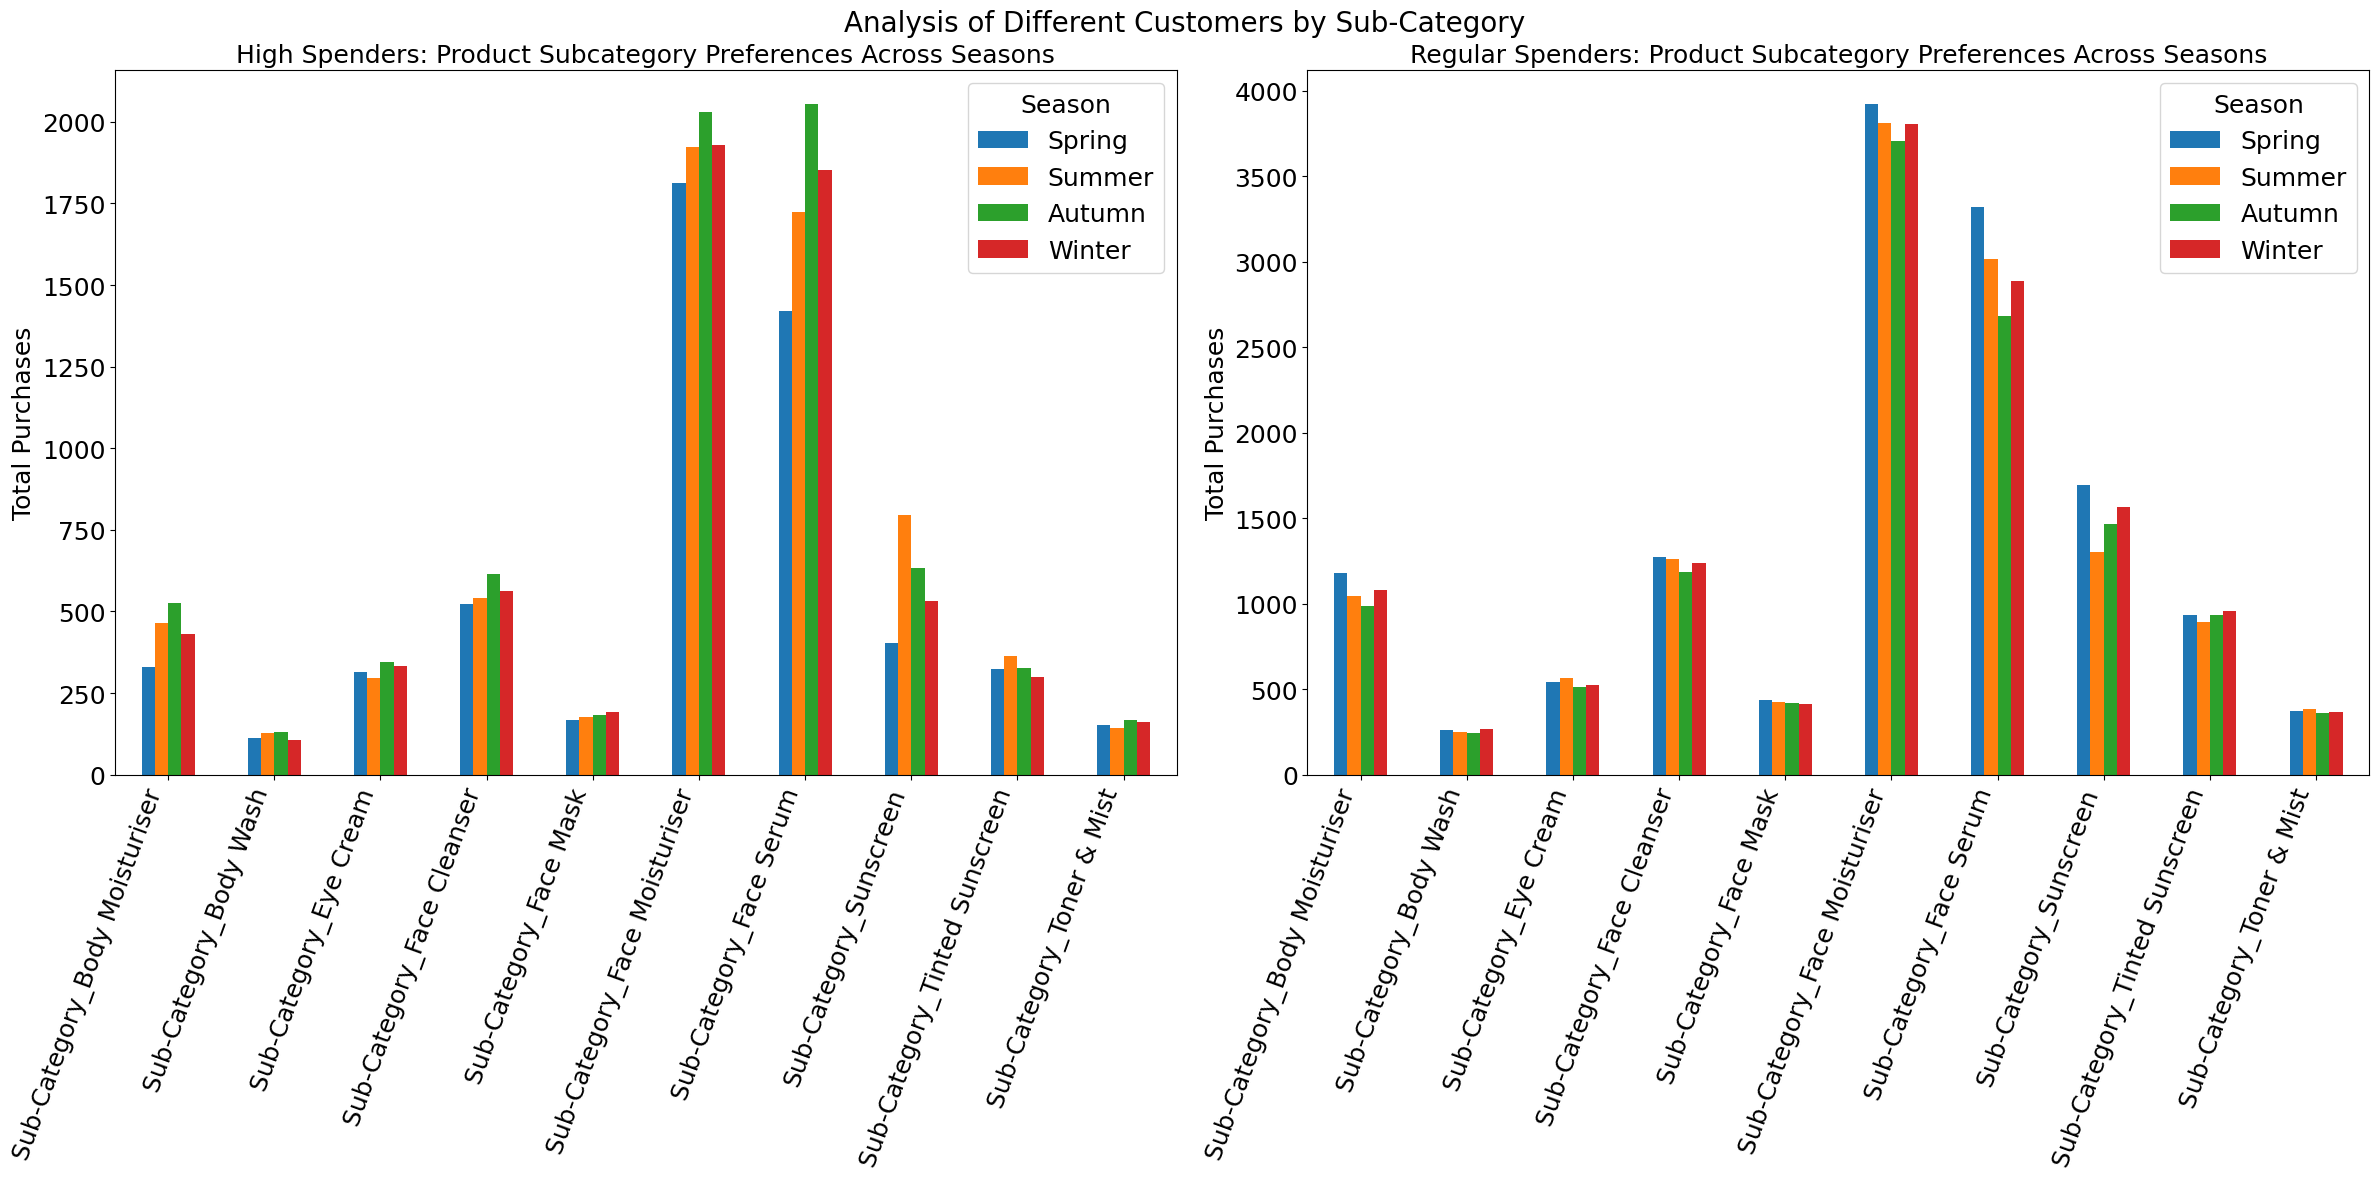

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

subcategories = [
    'Sub-Category_Body Moisturiser', 'Sub-Category_Body Wash', 
    'Sub-Category_Eye Cream', 'Sub-Category_Face Cleanser',
    'Sub-Category_Face Mask', 'Sub-Category_Face Moisturiser',
    'Sub-Category_Face Serum', 'Sub-Category_Sunscreen',
    'Sub-Category_Tinted Sunscreen', 'Sub-Category_Toner & Mist'
]

def prepare_spending_data(data_train, average_spent_column, threshold):
    high_spent = data_train[data_train[average_spent_column] > threshold]
    low_spent = data_train[data_train[average_spent_column] <= threshold]
    high_spent_counts = high_spent[subcategories].sum()
    low_spent_counts = low_spent[subcategories].sum()
    
    comparison_df = pd.DataFrame({
        'High Spender': high_spent_counts,
        'Regular Spender': low_spent_counts
    })
    
    return comparison_df

spring_df = prepare_spending_data(data_train, 'average_spent_inspring', 108)
summer_df = prepare_spending_data(data_train, 'average_spent_insummer', 60)
autumn_df = prepare_spending_data(data_train, 'average_spent_inautumn', 80)
winter_df = prepare_spending_data(data_train, 'average_spent_inwinter', 95)

fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# High Spenders across all seasons
high_spenders_df = pd.DataFrame({
    'Spring': spring_df['High Spender'],
    'Summer': summer_df['High Spender'],
    'Autumn': autumn_df['High Spender'],
    'Winter': winter_df['High Spender']
})
high_spenders_df.plot(kind='bar', ax=axes[0])
axes[0].set_title('High Spenders: Product Subcategory Preferences Across Seasons', fontsize=18)
axes[0].set_ylabel('Total Purchases',fontsize=18)
axes[0].set_xticklabels(high_spenders_df.index, rotation=70, ha='right',fontsize=18)
axes[0].tick_params(axis='y', labelsize=18)
axes[0].legend(title='Season', loc='upper right', title_fontsize=18, prop={'size': 18})

# Regular Spenders across all seasons
regular_spenders_df = pd.DataFrame({
    'Spring': spring_df['Regular Spender'],
    'Summer': summer_df['Regular Spender'],
    'Autumn': autumn_df['Regular Spender'],
    'Winter': winter_df['Regular Spender']
})
regular_spenders_df.plot(kind='bar', ax=axes[1])
axes[1].set_title('Regular Spenders: Product Subcategory Preferences Across Seasons',fontsize=18)
axes[1].set_ylabel('Total Purchases',fontsize=18)
axes[1].set_xticklabels(regular_spenders_df.index, rotation=70, ha='right',fontsize=18)
axes[1].tick_params(axis='y', labelsize=18)
axes[1].legend(title='Season', loc='upper right',title_fontsize=18, prop={'size': 18})

plt.suptitle('Analysis of Different Customers by Sub-Category', size=20)
plt.tight_layout()
plt.savefig('Different Customers by Sub-Catgeory.png')

plt.show()

Product Preferences: High vs Low Spent By Season

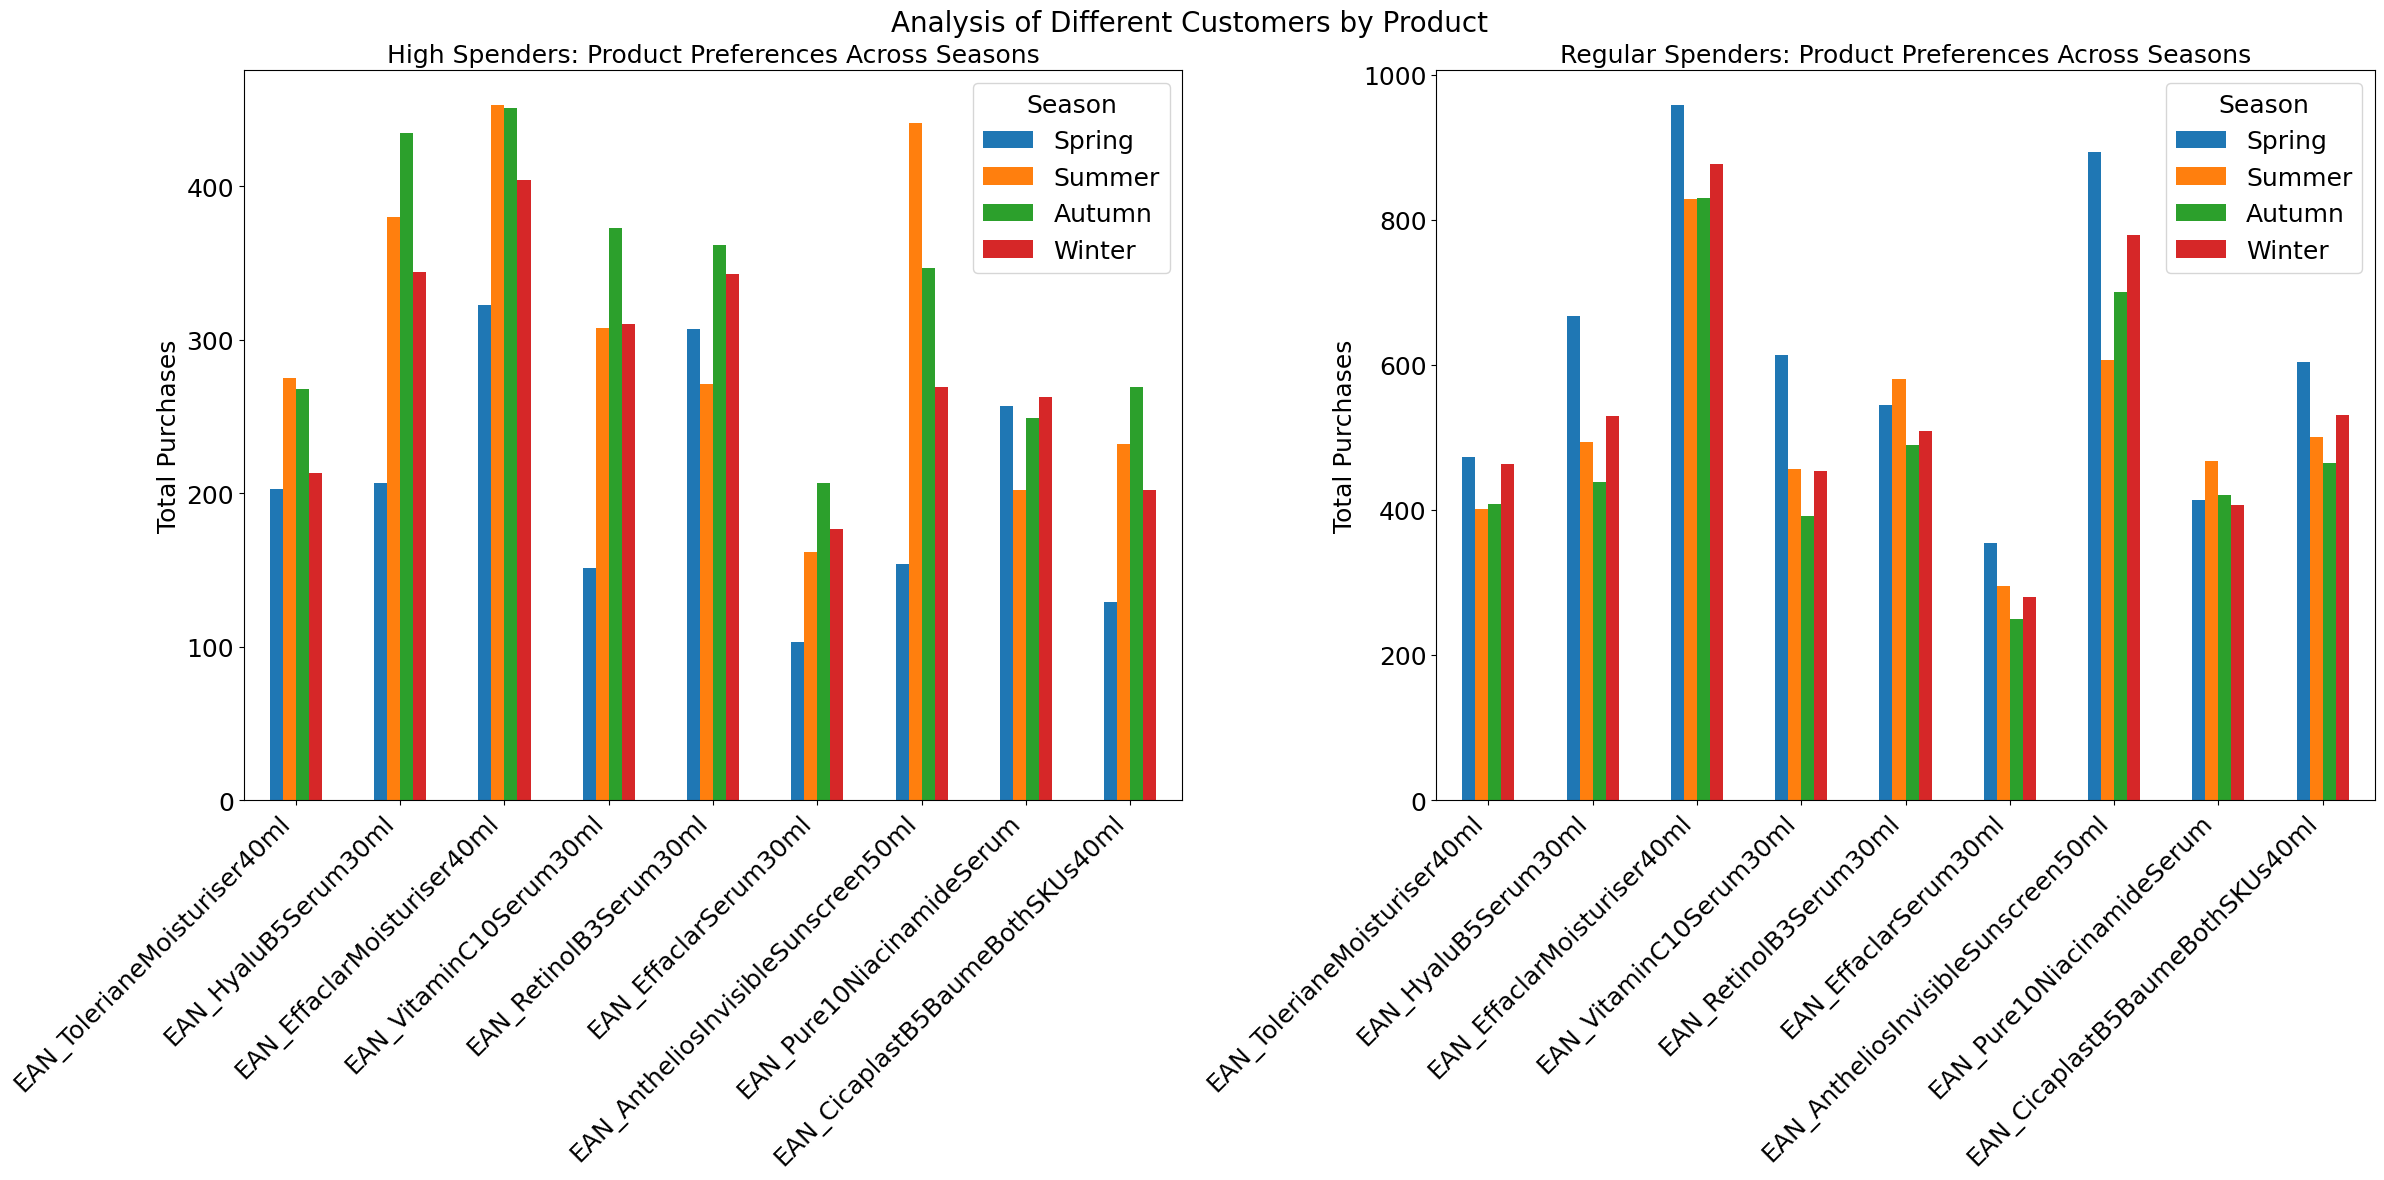

In [30]:
product = [
    'EAN_TolerianeMoisturiser40ml',
    'EAN_HyaluB5Serum30ml', 'EAN_EffaclarMoisturiser40ml',
    'EAN_VitaminC10Serum30ml', 'EAN_RetinolB3Serum30ml',
    'EAN_EffaclarSerum30ml', 'EAN_AntheliosInvisibleSunscreen50ml',
    'EAN_Pure10NiacinamideSerum', 'EAN_CicaplastB5BaumeBothSKUs40ml'
]

def prepare_spending_data(data_train, average_spent_column, threshold):
    high_spent = data_train[data_train[average_spent_column] > threshold]
    low_spent = data_train[data_train[average_spent_column] <= threshold]
    high_spent_counts = high_spent[product].sum()
    low_spent_counts = low_spent[product].sum()
    
    comparison_df = pd.DataFrame({
        'High Spender': high_spent_counts,
        'Regular Spender': low_spent_counts
    })
    
    return comparison_df

spring_df = prepare_spending_data(data_train, 'average_spent_inspring', 108)
summer_df = prepare_spending_data(data_train, 'average_spent_insummer', 60)
autumn_df = prepare_spending_data(data_train, 'average_spent_inautumn', 80)
winter_df = prepare_spending_data(data_train, 'average_spent_inwinter', 95)

high_spenders_df = pd.DataFrame({
    'Spring': spring_df['High Spender'],
    'Summer': summer_df['High Spender'],
    'Autumn': autumn_df['High Spender'],
    'Winter': winter_df['High Spender']
})

regular_spenders_df = pd.DataFrame({
    'Spring': spring_df['Regular Spender'],
    'Summer': summer_df['Regular Spender'],
    'Autumn': autumn_df['Regular Spender'],
    'Winter': winter_df['Regular Spender']
})

fig, axes = plt.subplots(1, 2, figsize=(24, 12))

high_spenders_df.plot(kind='bar', ax=axes[0])
axes[0].set_title('High Spenders: Product Preferences Across Seasons',fontsize=18)
axes[0].set_ylabel('Total Purchases',fontsize=18)
axes[0].set_xticklabels(high_spenders_df.index, rotation=45, ha='right',fontsize=18)
axes[0].tick_params(axis='y', labelsize=18)
axes[0].legend(title='Season', loc='upper right', title_fontsize=18, prop={'size': 18})

regular_spenders_df.plot(kind='bar', ax=axes[1])
axes[1].set_title('Regular Spenders: Product Preferences Across Seasons',fontsize=18)
axes[1].set_ylabel('Total Purchases',fontsize=18)
axes[1].set_xticklabels(regular_spenders_df.index, rotation=45, ha='right',fontsize=18)
axes[1].tick_params(axis='y', labelsize=18)
axes[1].legend(title='Season', loc='upper right', title_fontsize=18, prop={'size': 18})

plt.suptitle('Analysis of Different Customers by Product', size=20)
plt.tight_layout()
plt.savefig('Different Customers by Product.png')

plt.show()

In [31]:
drop_columns=['Spent_Change_6M_to_3M',
       'Spent_Change_9M_to_6M', 'Spent_Change_12M_to_9M',
       'Count_Change_6M_to_3M', 'Count_Change_9M_to_6M',
       'Count_Change_12M_to_9M', 'average_spent_inspring',
       'average_spent_insummer', 'average_spent_inautumn',
       'average_spent_inwinter']
data_train.drop(columns=drop_columns, inplace=True)

#### 5.3 Correlation Analysis

In [32]:
data_train.corr()['Total_Spent_Nov23_May24'].sort_values(ascending=False)

Total_Spent_Nov23_May24                     1.000000
transformed_target_variable                 0.866199
Total_Spent_12M                             0.398356
Total_Spent_AllTime                         0.394057
Total_Spent_9M                              0.383272
Total_Spent_6M                              0.356885
Category_Face Care                          0.304873
Total_Spent_3M                              0.271136
Skin Concern_Anti-Ageing                    0.270194
Transaction_Count_12M                       0.264188
Transaction_Count_AllTime                   0.263852
Sub-Category_Face Serum                     0.261821
Transaction_Count_9M                        0.246318
Class Description_Anti-Ageing               0.241334
Transaction_Count_6M                        0.237153
Brand Description_Hyalu B5                  0.234712
Class Description_Face Care                 0.223622
Total_Spent_1M                              0.213541
Sub-Category_Face Moisturiser               0.

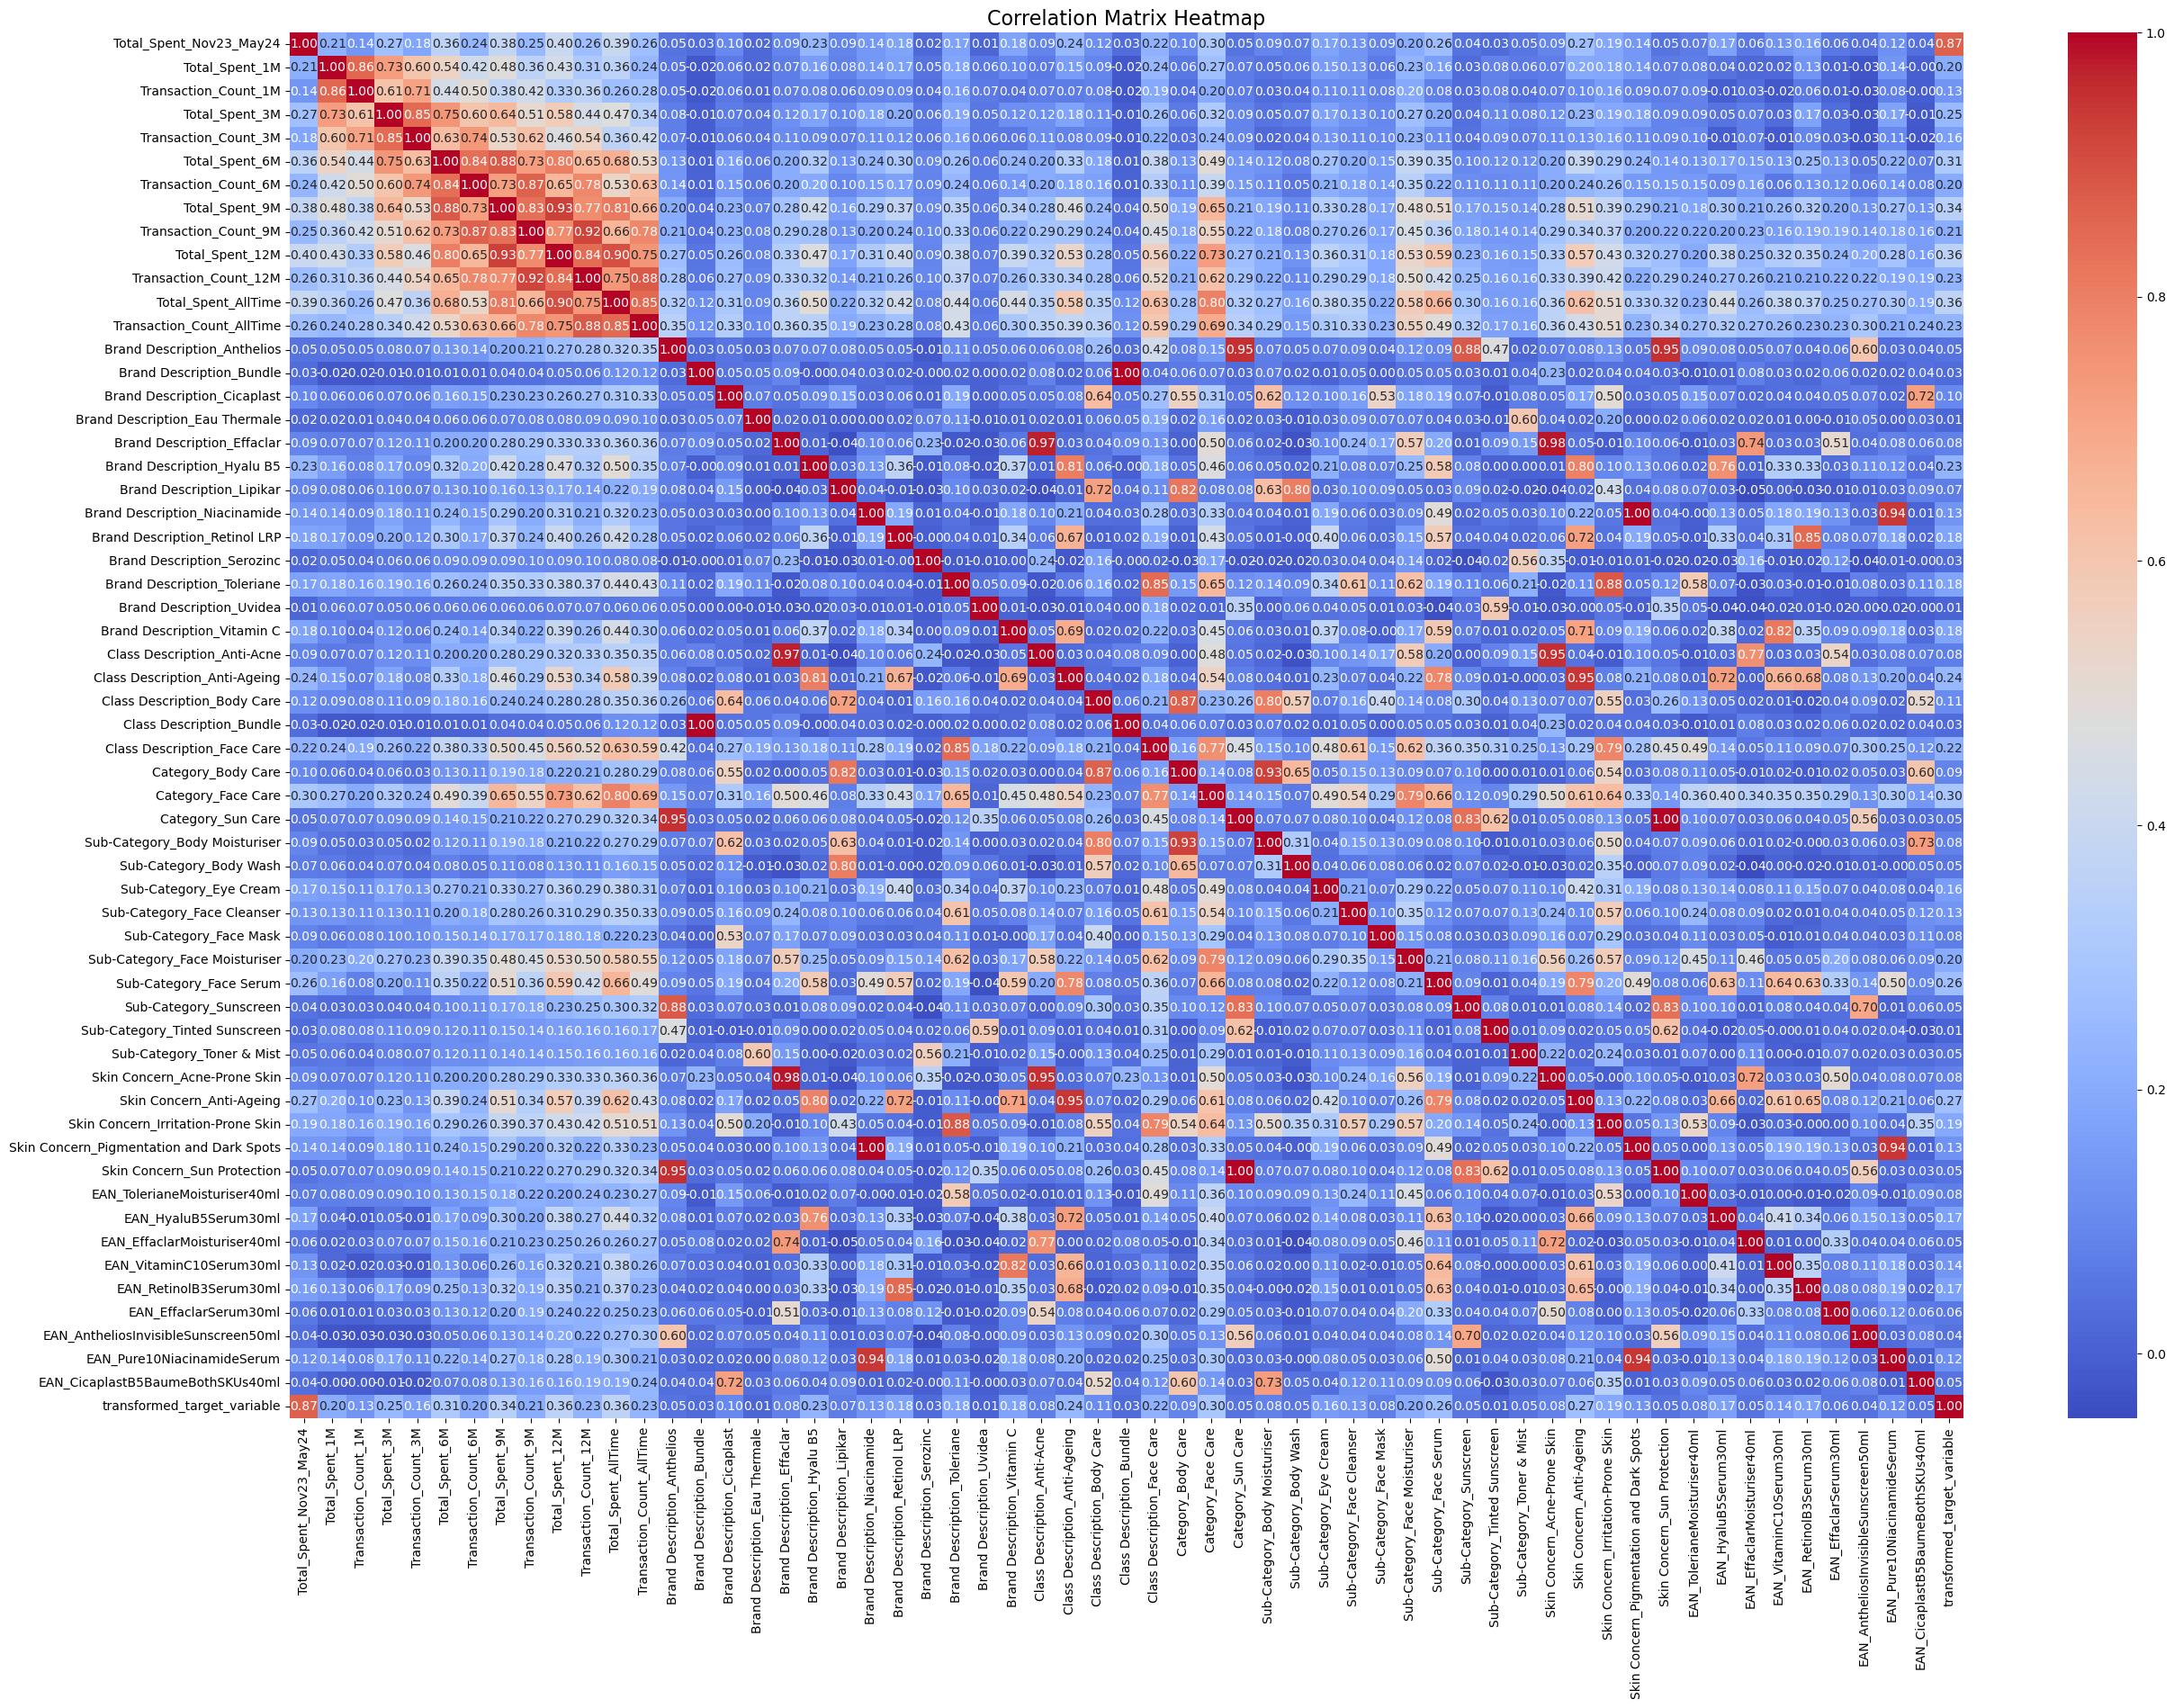

In [33]:
corr_matrix = data_train.corr()
plt.figure(figsize=(30, 20))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)


plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.savefig("Appendix D. Correlation Matrix Heatmap.png")

plt.show()

#### 5.4 Hierarchical customer analysis

In [34]:
def calculate_r_score(row):
    if row['Transaction_Count_1M'] > 0:
        return 5  
    elif row['Transaction_Count_3M'] > 0 and row['Transaction_Count_1M'] == 0:
        return 4  
    elif row['Transaction_Count_6M'] > 0 and row['Transaction_Count_3M'] == 0 and row['Transaction_Count_1M'] == 0:
        return 3  
    elif row['Transaction_Count_9M'] > 0 and row['Transaction_Count_6M'] == 0 and row['Transaction_Count_3M'] == 0 and row['Transaction_Count_1M'] == 0:
        return 2  
    elif (row['Transaction_Count_12M'] > 0 or row['Transaction_Count_AllTime'] > 0) and row['Transaction_Count_9M'] == 0 and row['Transaction_Count_6M'] == 0 and row['Transaction_Count_3M'] == 0 and row['Transaction_Count_1M'] == 0:
        return 1  
    else:
        return 0  

data_rfm_train['R_Score'] = data_rfm_train.apply(calculate_r_score, axis=1)
data_rfm_test['R_Score'] = data_rfm_test.apply(calculate_r_score, axis=1)

In [35]:
data_rfm_train['R_Score'].value_counts()

5    1342
3    1221
1     950
4     883
2     724
Name: R_Score, dtype: int64

In [36]:
def calculate_f_score(row):
    if row['Transaction_Count_9M'] == 0:
        return 1  
    elif row['Transaction_Count_9M'] == 1:
        return 2  
    elif row['Transaction_Count_9M'] == 2:
        return 3  
    elif 3 <= row['Transaction_Count_9M'] <= 4:
        return 4  
    elif row['Transaction_Count_9M'] >= 5:
        return 5  
    else:
        return 0  

data_rfm_train['F_Score'] = data_rfm_train.apply(calculate_f_score, axis=1)
data_rfm_test['F_Score'] = data_rfm_test.apply(calculate_f_score, axis=1)

In [37]:
data_rfm_train['M'] = data_rfm_train.apply(
    lambda row: row['Total_Spent_9M'] / row['Transaction_Count_9M'] if row['Transaction_Count_9M'] > 0 else 0, 
    axis=1
)
data_rfm_test['M'] = data_rfm_test.apply(
    lambda row: row['Total_Spent_9M'] / row['Transaction_Count_9M'] if row['Transaction_Count_9M'] > 0 else 0, 
    axis=1
)


In [38]:
def calculate_m_score(row):
    if row['M'] < 50:
        return 1  
    elif 50 <= row['M'] < 75:
        return 2  
    elif 75 <= row['M'] < 100:
        return 3  
    elif 100 <= row['M'] < 140:
        return 4  
    elif row['M'] >= 140:
        return 5  
    else:
        return 0  

data_rfm_train['M_Score'] = data_rfm_train.apply(calculate_m_score, axis=1)
data_rfm_test['M_Score'] = data_rfm_test.apply(calculate_m_score, axis=1)

In [39]:
rfm_df_train = data_rfm_train[['CustomerID','R_Score','F_Score','M_Score']]
rfm_df_train.loc[:,'Is R greater than mean'] =(rfm_df_train['R_Score'] > rfm_df_train['R_Score'].mean()) * 1
rfm_df_train.loc[:,'Is F greater than mean'] = (rfm_df_train['F_Score'] >rfm_df_train['F_Score'].mean()) * 1
rfm_df_train.loc[:,'Is M greater than mean'] = (rfm_df_train['M_Score'] >rfm_df_train['M_Score'].mean()) * 1

rfm_df_test = data_rfm_test[['CustomerID','R_Score','F_Score','M_Score']]
rfm_df_test.loc[:,'Is R greater than mean'] =(rfm_df_test['R_Score'] > rfm_df_test['R_Score'].mean()) * 1
rfm_df_test.loc[:,'Is F greater than mean'] = (rfm_df_test['F_Score'] >rfm_df_test['F_Score'].mean()) * 1
rfm_df_test.loc[:,'Is M greater than mean'] = (rfm_df_test['M_Score'] >rfm_df_test['M_Score'].mean()) * 1

In [40]:
rfm_df_train['M_Score'].mean()

2.9947265625

Label the customer

In [41]:
rfm_df_train.loc[:,'RFM'] =(rfm_df_train['Is R greater than mean'] * 100) + (rfm_df_train['Is F greater than mean'] * 10) + (rfm_df_train['Is M greater than mean'] * 1)
rfm_df_test.loc[:,'RFM'] =(rfm_df_test['Is R greater than mean'] * 100) + (rfm_df_test['Is F greater than mean'] * 10) + (rfm_df_test['Is M greater than mean'] * 1)

def transform_label(x):
    if x == 111:
        label = 'Best Customer'
    elif x == 110:
        label = 'High-Potential Customer'
    elif x == 101:
        label = 'Big Spender'
    elif x == 100:
        label = 'New Customer'
    elif x == 11:
        label = 'High-Value at Risk'
    elif x == 10:
        label = 'Regular Customer'
    elif x == 1:
        label = 'High-Value Reactivation'
    elif x == 0:
        label = 'Churned'
    return label
rfm_df_train.loc[:,'Customer_Segments'] = rfm_df_train['RFM'].apply(transform_label)
rfm_df_test.loc[:,'Customer_Segments'] = rfm_df_test['RFM'].apply(transform_label)

In [42]:
rfm_df_test

CustomerID  R_Score  F_Score  M_Score  Is R greater than mean  \
6277   LRP52840        1        1        1                       0   
3013   LRP14002        3        2        5                       0   
5434   LRP38887        5        2        2                       1   
4910   LRP34168        5        3        3                       1   
2709   LRP12735        5        3        2                       1   
...         ...      ...      ...      ...                     ...   
189    LRP00774        5        3        5                       1   
5361   LRP38220        1        1        1                       0   
2038   LRP09721        2        2        4                       0   
2443   LRP11758        5        2        2                       1   
5747   LRP46235        1        1        1                       0   

      Is F greater than mean  Is M greater than mean  RFM  \
6277                       0                       0    0   
3013                       0                       1    1   
5434                       0                       0  100   
4910                       1                       0  110   
2709                       1                       0  110   
...                      ...                     ...  ...   
189                        1                       1  111   
5361                       0                       0    0   
2038                       0                       1    1   
2443                       0                       0  100   
5747                       0                       0    0   

            Customer_Segments  
6277                  Churned  
3013  High-Value Reactivation  
5434             New Customer  
4910  High-Potential Customer  
2709  High-Potential Customer  
...                       ...  
189             Best Customer  
5361                  Churned  
2038  High-Value Reactivation  
2443             New Customer  
5747                  Churned  

[1280 rows x 9 columns]

Proportion of number of different customer types & proportion of their consumption contribution

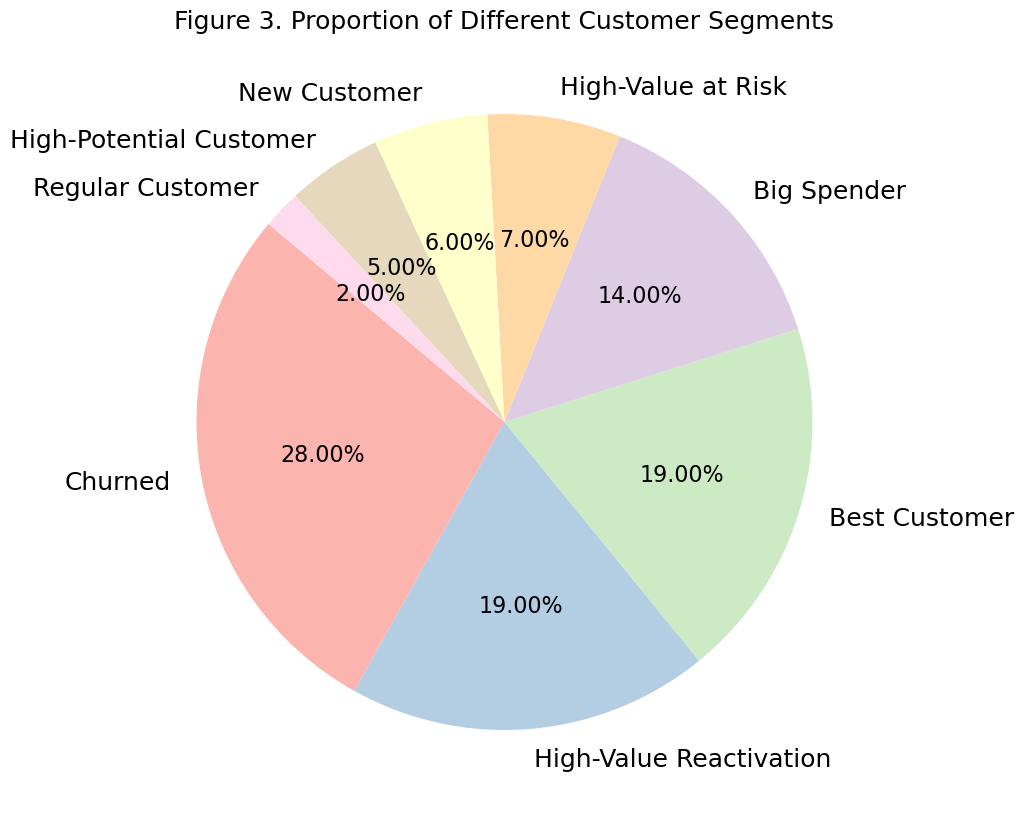

In [43]:
count = rfm_df_train['Customer_Segments'].value_counts().reset_index()

count.columns = ['Customer_Segments','Counts']
count['Proportion'] = (count['Counts'] /count['Counts'].sum()).round(2)
plt.figure(figsize=(12, 10))

colors = plt.get_cmap('Pastel1').colors

plt.pie(count['Proportion'], labels=count['Customer_Segments'], autopct='%1.2f%%', startangle=140, colors=colors, textprops={'fontsize': 16})
for text in plt.gca().texts:
    if text.get_text() in count['Customer_Segments'].values:
        text.set_fontsize(18)
plt.title('Figure 3. Proportion of Different Customer Segments', fontsize=18)
plt.savefig('Figure 3. Proportion of Different Customer Segments.png')
plt.show()

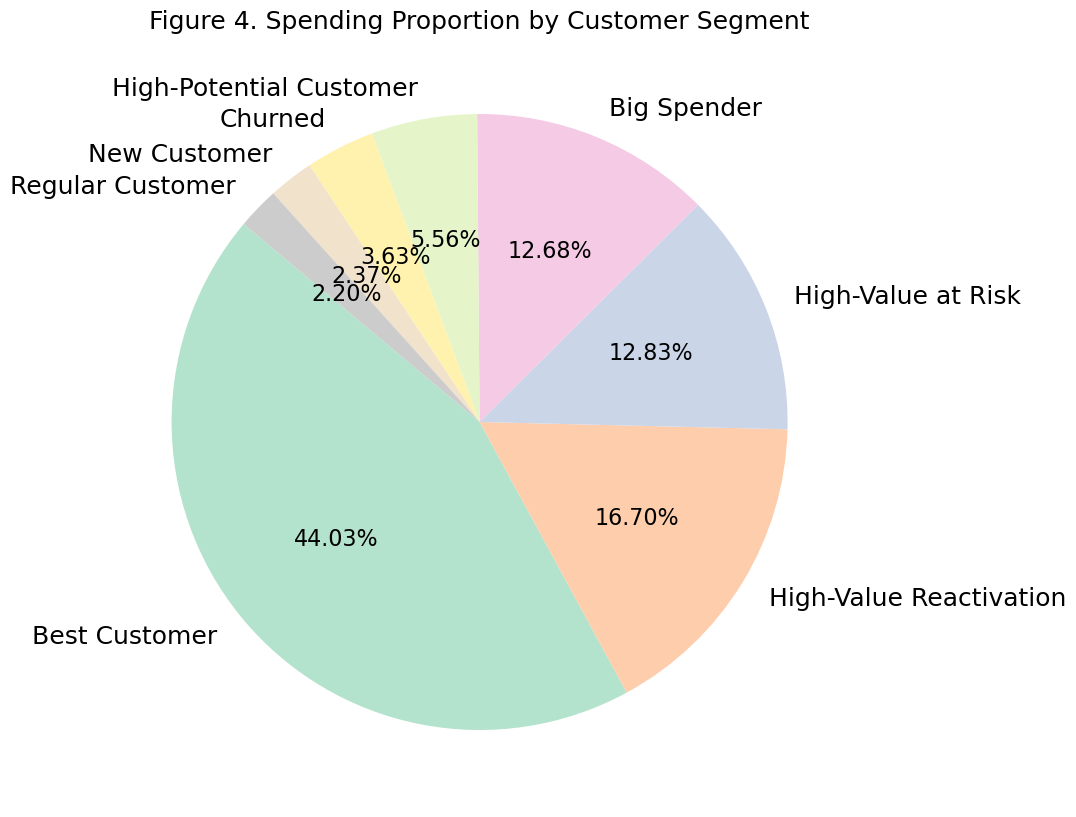

In [44]:
rfm_df_train['Total_Spent']=data_rfm_train['M']*data_rfm_train['Transaction_Count_9M']
mon = rfm_df_train.groupby('Customer_Segments')['Total_Spent'].sum().reset_index()
mon.columns = ['Customer_Segments','Total_Spending']
mon['Spending_Proportion'] = mon['Total_Spending'] /   mon['Total_Spending'].sum()
mon_sorted = mon.sort_values(by='Spending_Proportion', ascending=False)
plt.figure(figsize=(12, 10))

colors = plt.get_cmap('Pastel2').colors

plt.pie(mon_sorted['Spending_Proportion'], labels=mon_sorted['Customer_Segments'], autopct='%1.2f%%', startangle=140, colors=colors, textprops={'fontsize': 16})
for text in plt.gca().texts:
    if text.get_text() in count['Customer_Segments'].values:
        text.set_fontsize(18)  
plt.title('Figure 4. Spending Proportion by Customer Segment', fontsize=18)
plt.savefig('Figure 4. Spending Proportion by Customer Segment.png')
plt.show()

In [45]:
data_rfm_train.columns

Index(['CustomerID', 'Total_Spent_Nov23_May24', 'Total_Spent_1M',
       'Transaction_Count_1M', 'Total_Spent_3M', 'Transaction_Count_3M',
       'Total_Spent_6M', 'Transaction_Count_6M', 'Total_Spent_9M',
       'Transaction_Count_9M', 'Total_Spent_12M', 'Transaction_Count_12M',
       'Total_Spent_AllTime', 'Transaction_Count_AllTime',
       'Brand Description_Anthelios', 'Brand Description_Bundle',
       'Brand Description_Cicaplast', 'Brand Description_Eau Thermale',
       'Brand Description_Effaclar', 'Brand Description_Hyalu B5',
       'Brand Description_Lipikar', 'Brand Description_Niacinamide',
       'Brand Description_Retinol LRP', 'Brand Description_Serozinc',
       'Brand Description_Toleriane', 'Brand Description_Uvidea',
       'Brand Description_Vitamin C', 'Class Description_Anti-Acne',
       'Class Description_Anti-Ageing', 'Class Description_Body Care',
       'Class Description_Bundle', 'Class Description_Face Care',
       'Category_Body Care', 'Category_Face 

Behaviour analysis of different customer types

In [46]:
rfm_df_train.set_index('CustomerID', inplace=True)
rfm_df_test.set_index('CustomerID', inplace=True)
data_rfm_train.set_index('CustomerID', inplace=True)
data_rfm_test.set_index('CustomerID', inplace=True)
columns_to_add = ['Brand Description_Anthelios','Brand Description_Cicaplast', 'Brand Description_Effaclar',
       'Brand Description_Hyalu B5', 'Brand Description_Lipikar',
       'Brand Description_Niacinamide', 'Brand Description_Retinol LRP',
       'Brand Description_Toleriane', 'Brand Description_Uvidea',
       'Brand Description_Vitamin C','Class Description_Anti-Acne',
       'Class Description_Anti-Ageing', 'Class Description_Body Care',
       'Class Description_Face Care', 'EAN_TolerianeMoisturiser40ml',
        'EAN_HyaluB5Serum30ml', 'EAN_EffaclarMoisturiser40ml',
       'EAN_VitaminC10Serum30ml', 'EAN_RetinolB3Serum30ml',
       'EAN_EffaclarSerum30ml', 'EAN_AntheliosInvisibleSunscreen50ml',
       'EAN_Pure10NiacinamideSerum', 'EAN_CicaplastB5BaumeBothSKUs40ml',
        'Skin Concern_Acne-Prone Skin', 'Skin Concern_Anti-Ageing',
       'Skin Concern_Irritation-Prone Skin',
       'Skin Concern_Pigmentation and Dark Spots',
       'Skin Concern_Sun Protection']
rfm_df_train_merge = rfm_df_train.merge(data_rfm_train[columns_to_add], on='CustomerID', how='left')
rfm_df_test_merge = rfm_df_test.merge(data_rfm_test[columns_to_add], on='CustomerID', how='left')

<Figure size 2000x1400 with 0 Axes>

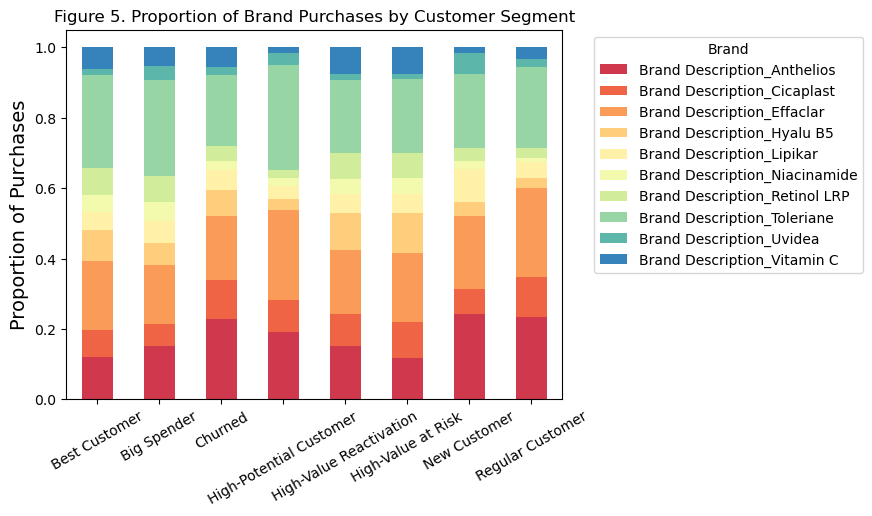

In [47]:
brands = ['Brand Description_Anthelios',
    'Brand Description_Cicaplast', 'Brand Description_Effaclar', 'Brand Description_Hyalu B5', 
    'Brand Description_Lipikar', 'Brand Description_Niacinamide', 
    'Brand Description_Retinol LRP', 'Brand Description_Toleriane', 
    'Brand Description_Uvidea', 'Brand Description_Vitamin C'
]
brand_totals = rfm_df_train_merge.groupby('Customer_Segments')[brands].sum()


brand_proportions = brand_totals.div(brand_totals.sum(axis=1), axis=0)
colors = sns.color_palette("Spectral", len(brands))
plt.figure(figsize=(20, 14))  
brand_proportions.plot(kind='bar', stacked=True, color=colors)

plt.title('Figure 5. Proportion of Brand Purchases by Customer Segment', fontsize=12)
plt.xlabel('')
plt.ylabel('Proportion of Purchases', fontsize=14)
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=30)

plt.savefig('Figure 5. Proportion of Brand Purchases by Customer Segment.png', bbox_inches='tight')
plt.show()

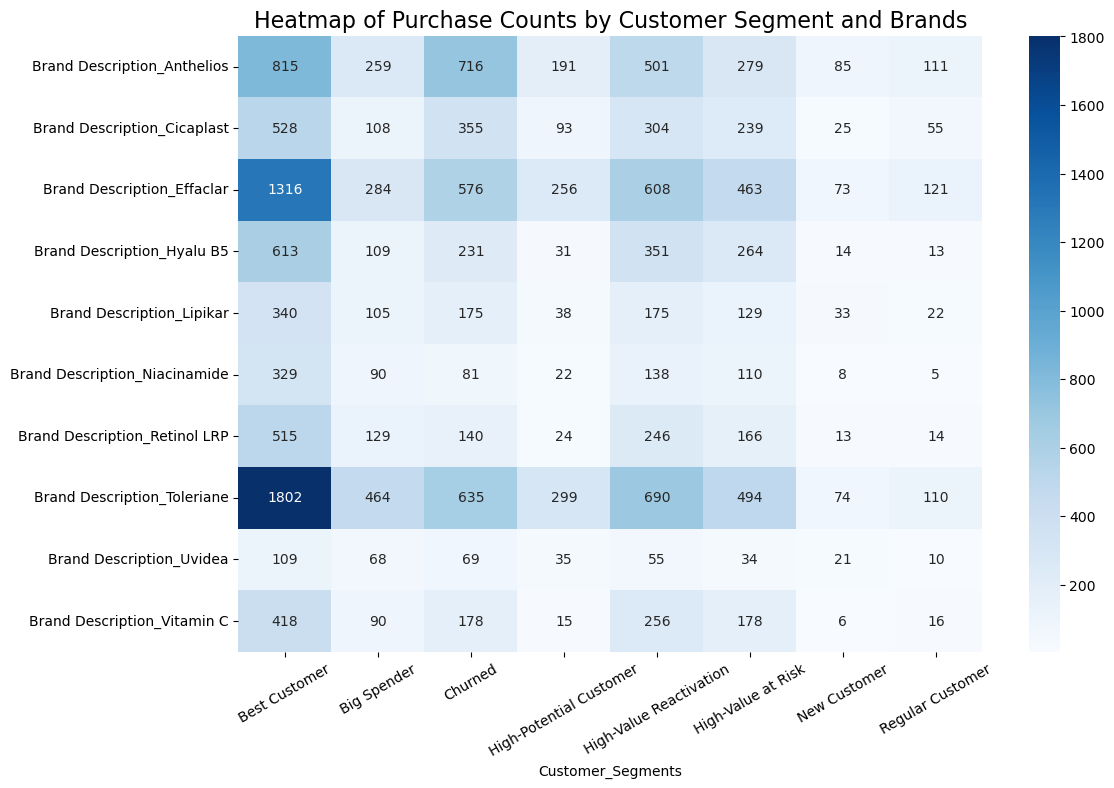

In [48]:
brands_counts = rfm_df_train_merge.groupby('Customer_Segments')[brands].sum().reset_index()
plt.figure(figsize=(12, 8))
sns.heatmap(brands_counts.set_index('Customer_Segments').T, annot=True, cmap='Blues', fmt='g')

plt.title('Heatmap of Purchase Counts by Customer Segment and Brands', fontsize=16)
plt.xticks(rotation=30)
plt.show()

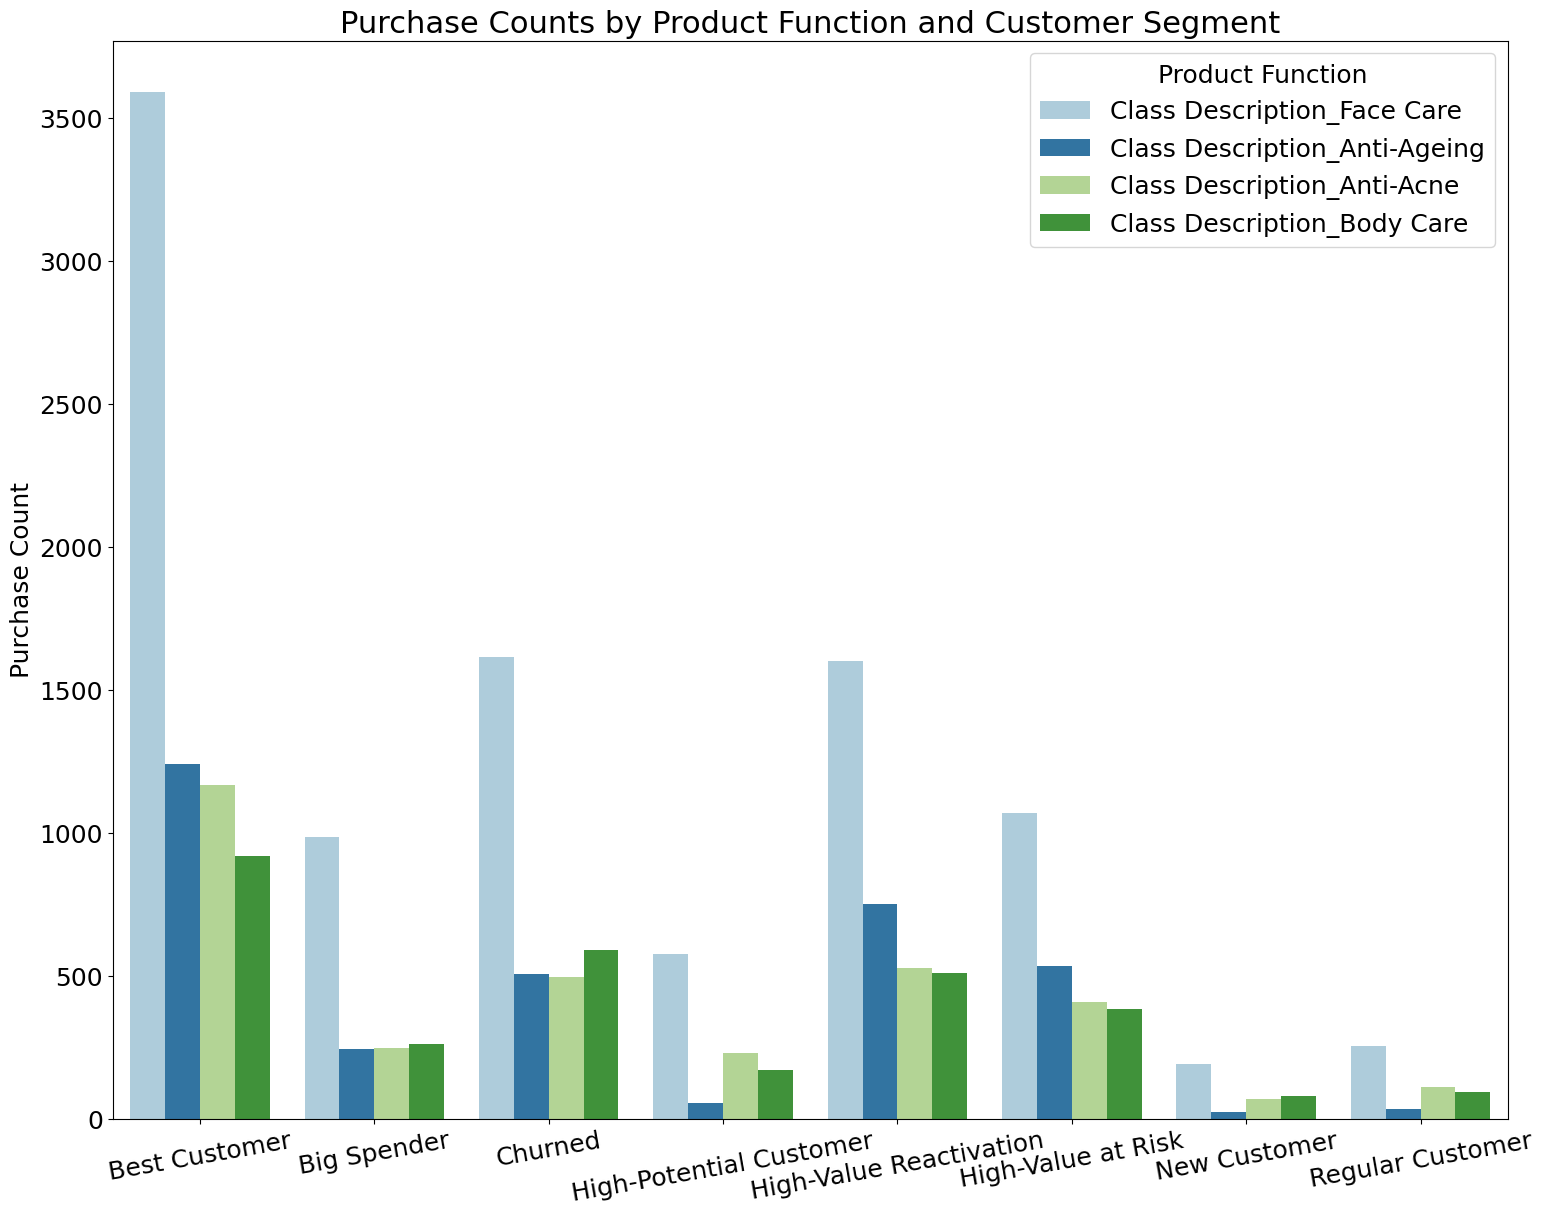

In [49]:
product_function = ['Class Description_Anti-Acne', 'Class Description_Anti-Ageing',
                    'Class Description_Body Care', 'Class Description_Face Care']
customer_segments = 'Customer_Segments'

product_counts = rfm_df_train_merge.groupby(customer_segments)[product_function].sum().reset_index()
product_counts_melted = pd.melt(product_counts, id_vars=customer_segments, var_name='Product Function', value_name='Purchase Count')
product_counts_melted = product_counts_melted.sort_values(by=['Customer_Segments', 'Purchase Count'], ascending=[True, False])

custom_palette = sns.color_palette("Paired", len(product_function))

plt.figure(figsize=(18, 14))
sns.barplot(x='Customer_Segments', y='Purchase Count', hue='Product Function', 
            data=product_counts_melted, palette=custom_palette)

plt.title('Purchase Counts by Product Function and Customer Segment', fontsize=22)
plt.ylabel('Purchase Count',fontsize=18)
plt.xlabel('')
plt.xticks(rotation=10, fontsize=18)
plt.legend(title='Product Function', loc='upper right', title_fontsize=18,bbox_to_anchor=(1, 1),prop={'size': 18})
plt.yticks(fontsize=18)
plt.savefig('Purchase Counts by Product Function and Customer Segment.png', bbox_inches='tight')
plt.show()

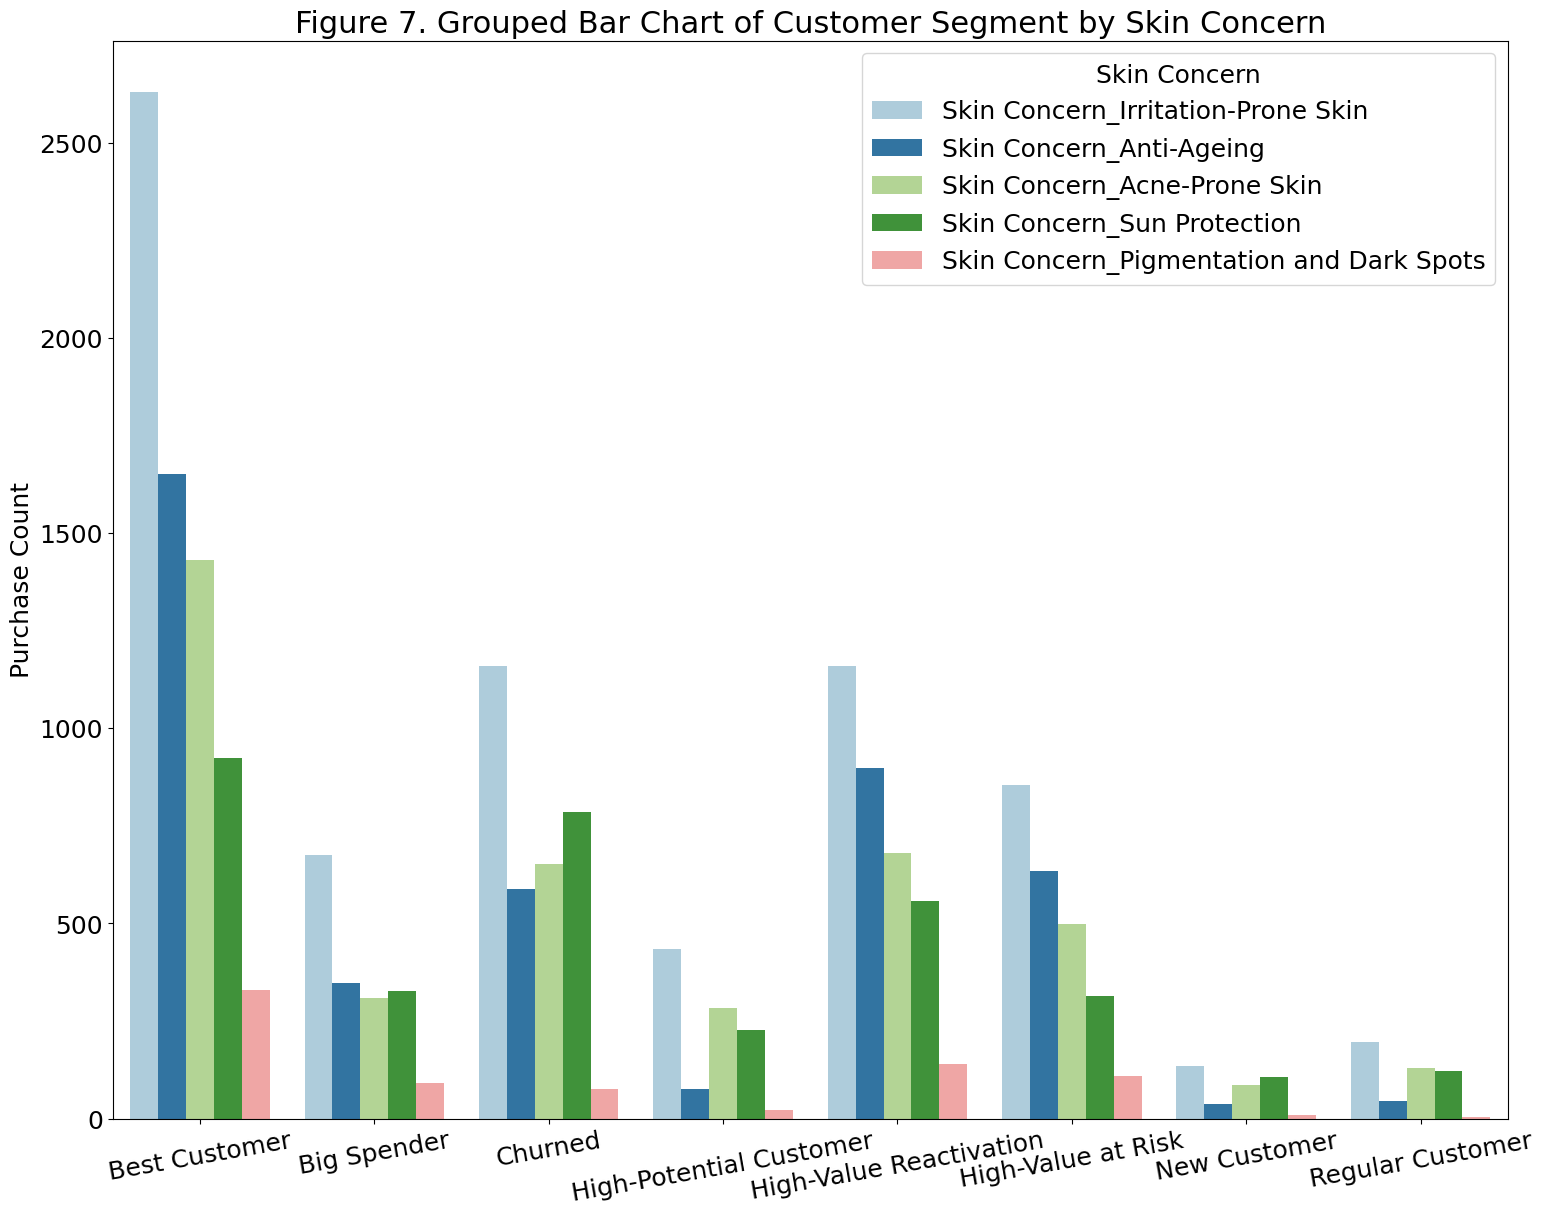

In [50]:
skin_concern = ['Skin Concern_Acne-Prone Skin', 'Skin Concern_Anti-Ageing',
                'Skin Concern_Irritation-Prone Skin', 
                'Skin Concern_Pigmentation and Dark Spots', 
                'Skin Concern_Sun Protection']
skin_concern_counts = rfm_df_train_merge.groupby('Customer_Segments')[skin_concern].sum().reset_index()
skin_concern_melted = pd.melt(skin_concern_counts, id_vars='Customer_Segments', var_name='Skin Concern', value_name='Purchase Count')
skin_concern_melted = skin_concern_melted.sort_values(['Customer_Segments', 'Purchase Count'], ascending=[True, False])

custom_palette = sns.color_palette("Paired")

plt.figure(figsize=(18, 14))
sns.barplot(x='Customer_Segments', y='Purchase Count', hue='Skin Concern', data=skin_concern_melted, palette=custom_palette)

plt.title('Figure 7. Grouped Bar Chart of Customer Segment by Skin Concern', fontsize=22)
plt.ylabel('Purchase Count',fontsize=18)
plt.xlabel('')
plt.legend(title='Skin Concern', loc='upper right', title_fontsize=18,bbox_to_anchor=(1, 1),prop={'size': 18})
plt.xticks(rotation=10, fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('Figure 7. Grouped Bar Chart of Customer Segment by Skin Concern.png')
plt.show()

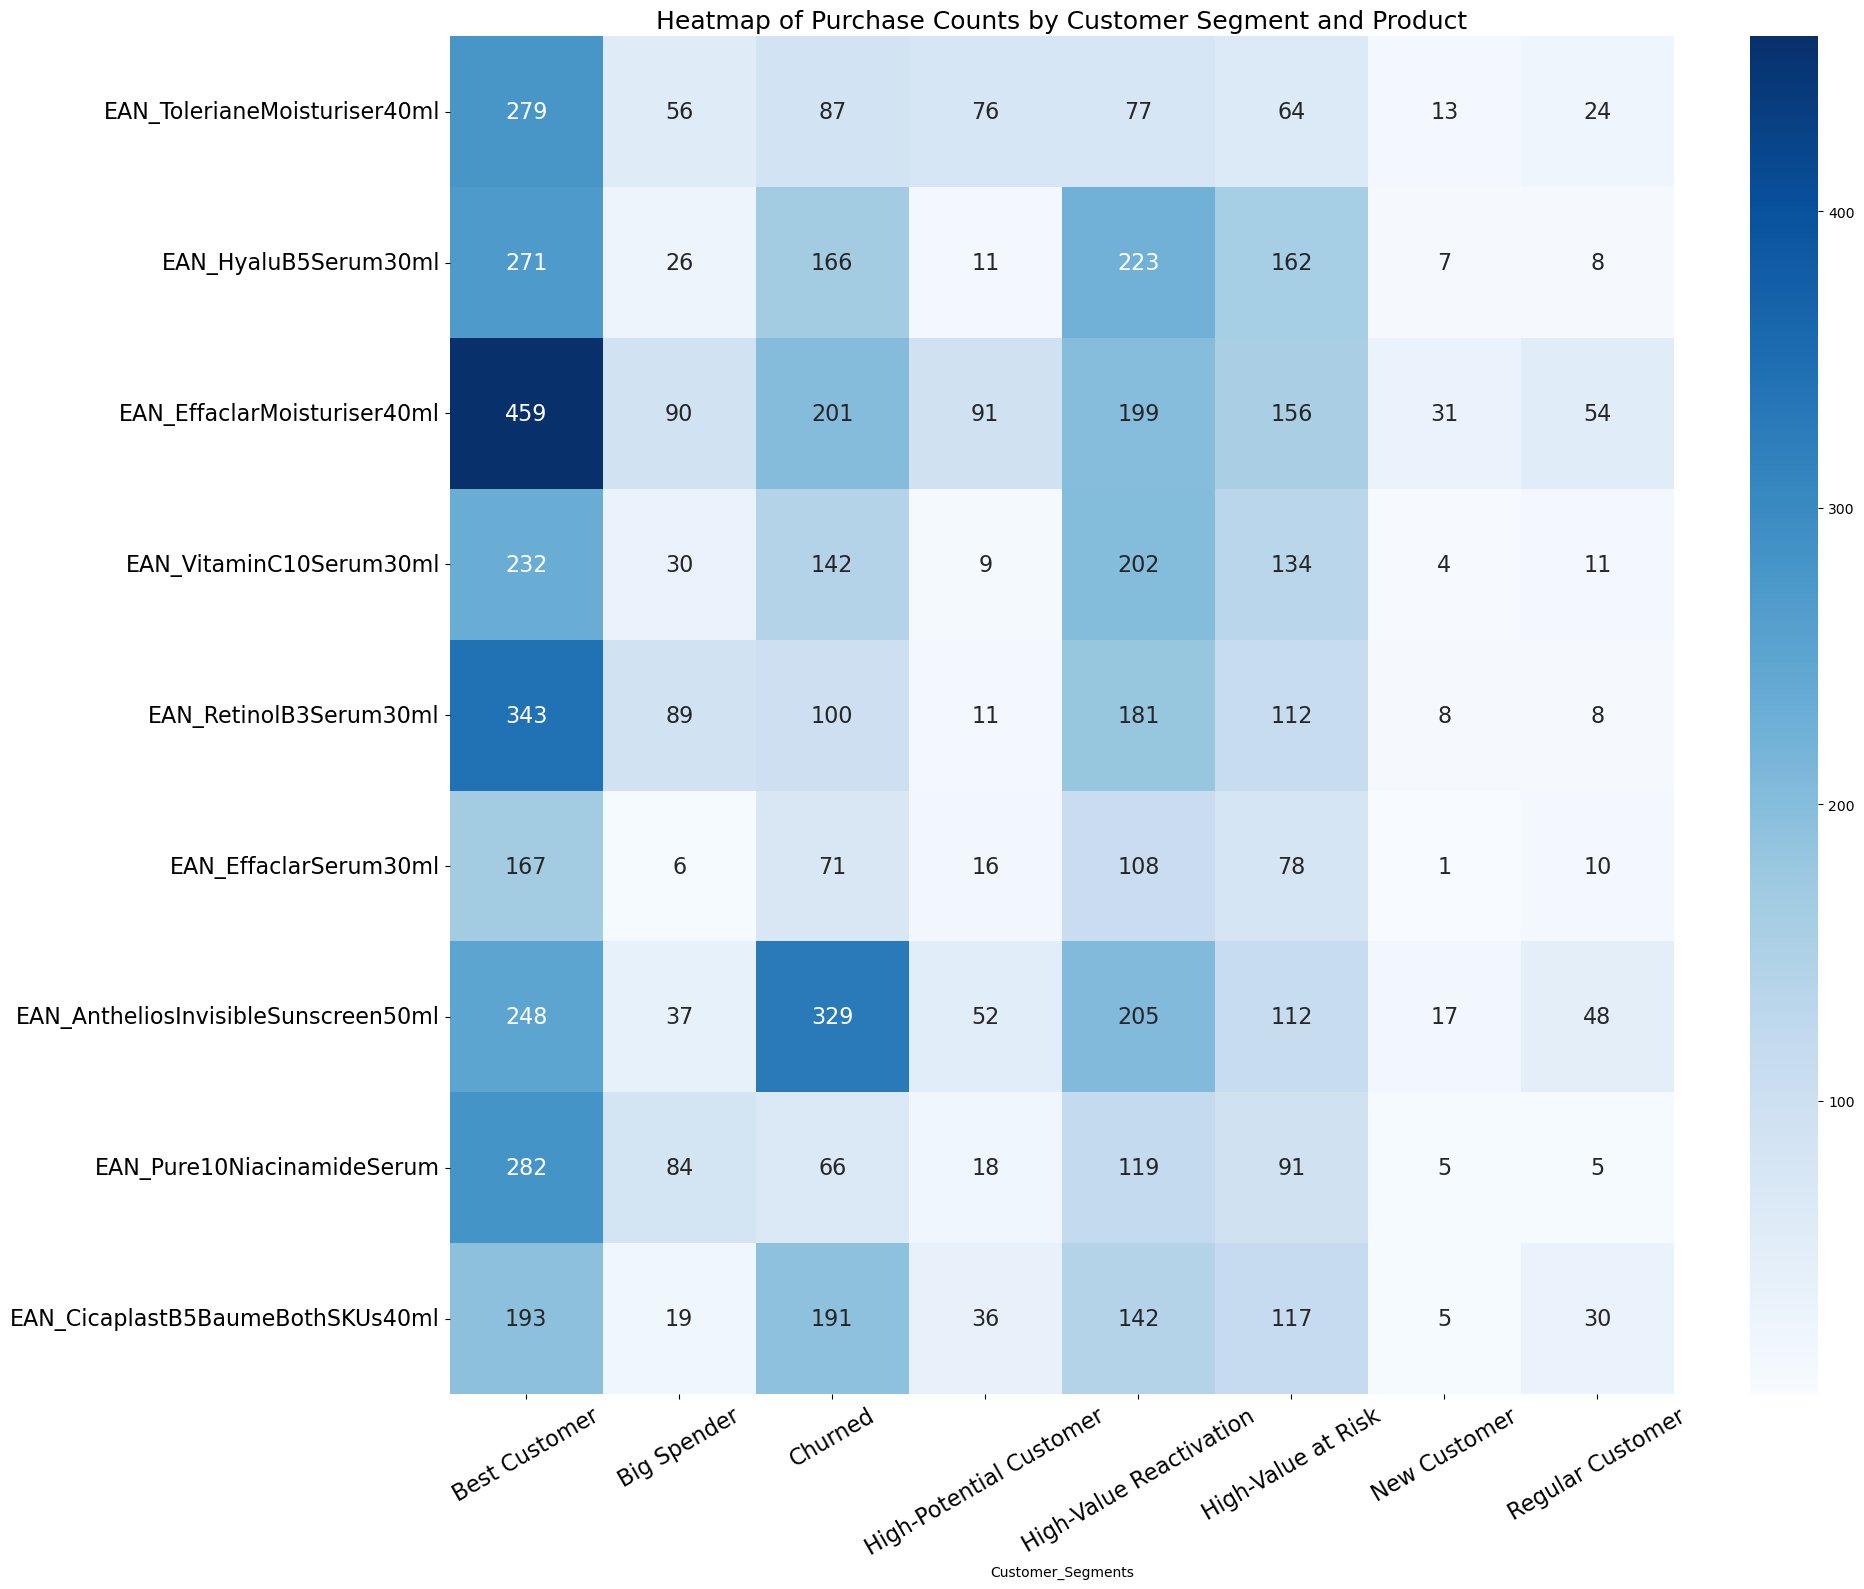

In [51]:
products = ['EAN_TolerianeMoisturiser40ml', 'EAN_HyaluB5Serum30ml', 'EAN_EffaclarMoisturiser40ml',
           'EAN_VitaminC10Serum30ml', 'EAN_RetinolB3Serum30ml', 'EAN_EffaclarSerum30ml',
           'EAN_AntheliosInvisibleSunscreen50ml', 'EAN_Pure10NiacinamideSerum', 
           'EAN_CicaplastB5BaumeBothSKUs40ml']

product_counts = rfm_df_train_merge.groupby('Customer_Segments')[products].sum().reset_index()
plt.figure(figsize=(20, 16))
sns.heatmap(product_counts.set_index('Customer_Segments').T, annot=True, cmap='Blues', fmt='g', 
            annot_kws={"size": 16})

plt.title('Heatmap of Purchase Counts by Customer Segment and Product', fontsize=18)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.savefig('Appendix L. Heatmap of Purchase Counts by Customer Segment and Product.png')
plt.show()

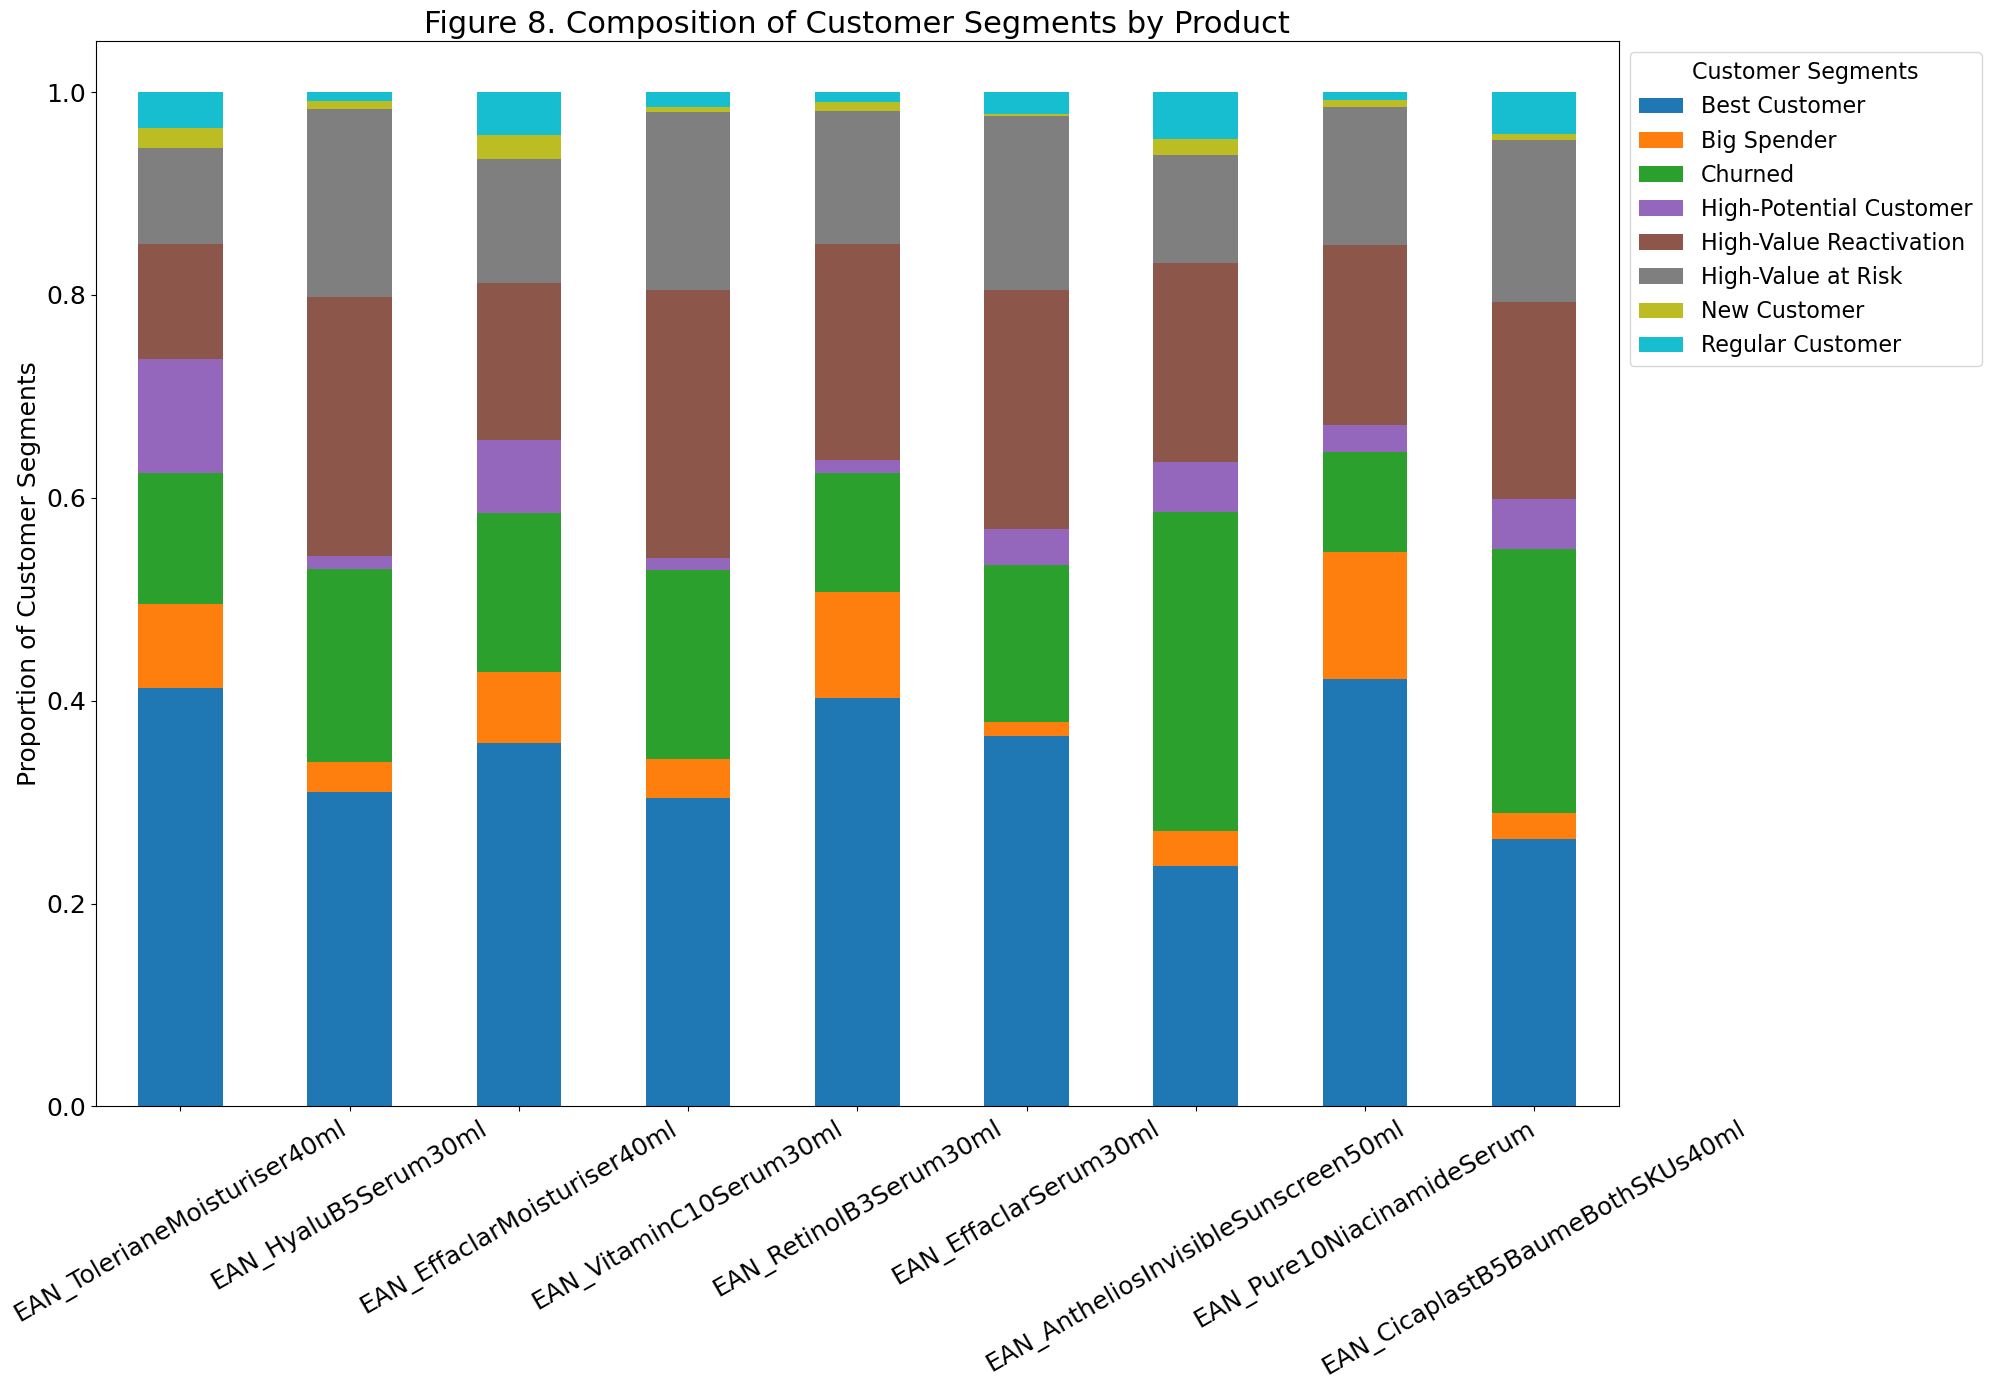

In [52]:
customer_totals = rfm_df_train_merge.groupby('Customer_Segments')[products].sum().T
customer_proportions = customer_totals.div(customer_totals.sum(axis=1), axis=0)

customer_proportions.plot(kind='bar', stacked=True, figsize=(20, 14), colormap='tab10')

plt.title('Figure 8. Composition of Customer Segments by Product', fontsize=22)
plt.xlabel('')
plt.ylabel('Proportion of Customer Segments', fontsize=18)
plt.legend(title='Customer Segments', bbox_to_anchor=(1, 1), title_fontsize=16,loc='upper left',prop={'size': 16})
plt.xticks(fontsize=18,rotation=30,position=(2, 0))
plt.yticks(fontsize=18)
plt.tight_layout()

plt.savefig('Figure 8. Composition of Customer Segments by Product.png')
plt.show()

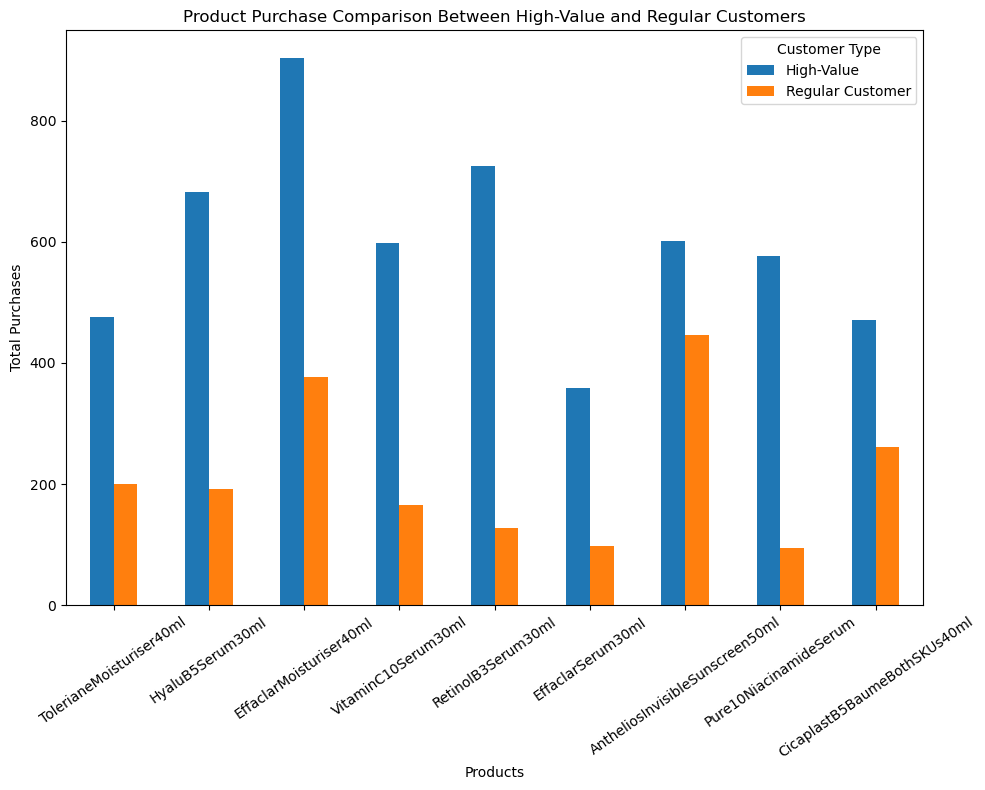

In [53]:
high_value_customers = ['Best Customer', 'Big Spender', 'High-Value Reactivation', 'High-Value at Risk']
rfm_df_train_merge['Customer_Type'] = rfm_df_train_merge['Customer_Segments'].apply(lambda x: 'High-Value' if x in high_value_customers else 'Regular Customer')

# 按Customer_Type分组，计算每个产品的总购买次数
product_columns = [
    'EAN_TolerianeMoisturiser40ml', 'EAN_HyaluB5Serum30ml', 'EAN_EffaclarMoisturiser40ml',
    'EAN_VitaminC10Serum30ml', 'EAN_RetinolB3Serum30ml', 'EAN_EffaclarSerum30ml',
    'EAN_AntheliosInvisibleSunscreen50ml', 'EAN_Pure10NiacinamideSerum', 'EAN_CicaplastB5BaumeBothSKUs40ml'
]
grouped_df = rfm_df_train_merge.groupby('Customer_Type')[product_columns].sum().T

grouped_df.index = grouped_df.index.str.replace('EAN_', '')

# 绘制柱状图
grouped_df.plot(kind='bar', figsize=(10, 8))
plt.title('Product Purchase Comparison Between High-Value and Regular Customers')
plt.ylabel('Total Purchases')
plt.xlabel('Products')
plt.xticks(rotation=35)
plt.legend(title='Customer Type')
plt.tight_layout()

# 显示图表
plt.show()

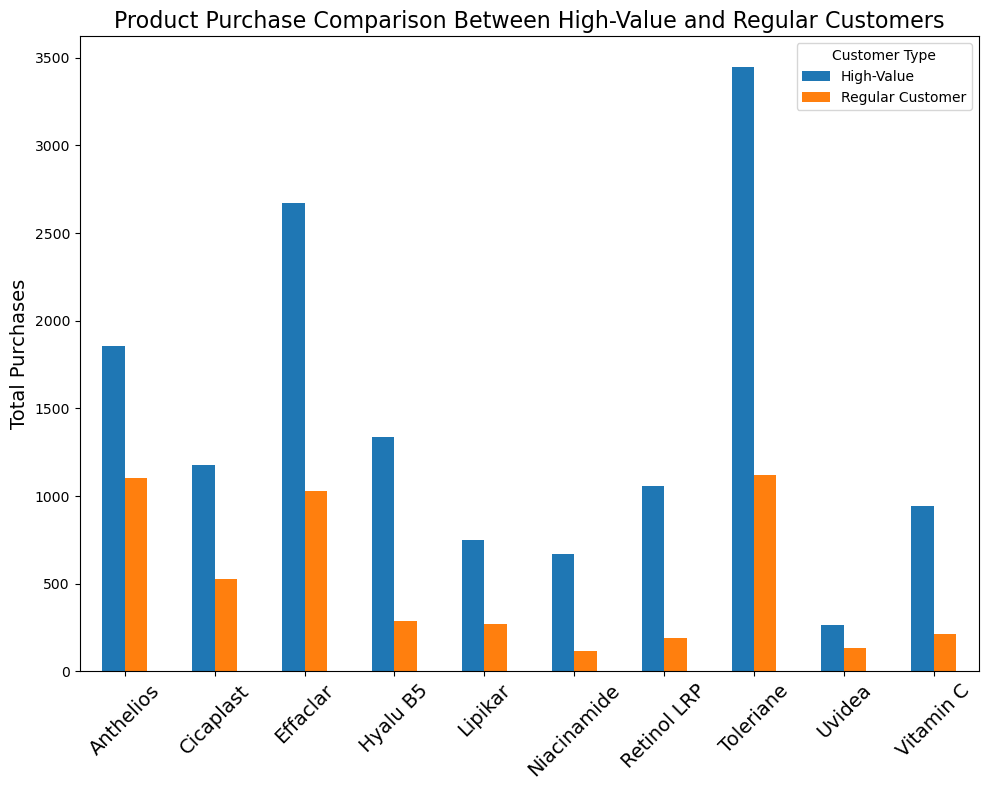

In [54]:
brands = ['Brand Description_Anthelios',
    'Brand Description_Cicaplast', 'Brand Description_Effaclar', 'Brand Description_Hyalu B5', 
    'Brand Description_Lipikar', 'Brand Description_Niacinamide', 
    'Brand Description_Retinol LRP', 'Brand Description_Toleriane', 
    'Brand Description_Uvidea', 'Brand Description_Vitamin C'
]

grouped_df = rfm_df_train_merge.groupby('Customer_Type')[brands].sum().T

grouped_df.index = grouped_df.index.str.replace('Brand Description_', '')

# 绘制柱状图
grouped_df.plot(kind='bar', figsize=(10, 8))
plt.title('Product Purchase Comparison Between High-Value and Regular Customers',fontsize=16)
plt.ylabel('Total Purchases',fontsize=14)
plt.xlabel('')
plt.xticks(rotation=45,fontsize=14)
plt.legend(title='Customer Type')
plt.tight_layout()

# 显示图表
plt.show()

## Feature Engineering

In [55]:
data_train2=data_train.copy()
data_test2=data_test.copy()

data_train3=data_train.copy()
data_test3=data_test.copy()

data_train3 = data_train3.merge(rfm_df_train_merge[['Customer_Segments']], on='CustomerID', how='left')
data_test3 = data_test3.merge(rfm_df_test_merge[['Customer_Segments']], on='CustomerID', how='left')

In [56]:
data_test3.columns

Index(['CustomerID', 'Total_Spent_Nov23_May24', 'Total_Spent_1M',
       'Transaction_Count_1M', 'Total_Spent_3M', 'Transaction_Count_3M',
       'Total_Spent_6M', 'Transaction_Count_6M', 'Total_Spent_9M',
       'Transaction_Count_9M', 'Total_Spent_12M', 'Transaction_Count_12M',
       'Total_Spent_AllTime', 'Transaction_Count_AllTime',
       'Brand Description_Anthelios', 'Brand Description_Bundle',
       'Brand Description_Cicaplast', 'Brand Description_Eau Thermale',
       'Brand Description_Effaclar', 'Brand Description_Hyalu B5',
       'Brand Description_Lipikar', 'Brand Description_Niacinamide',
       'Brand Description_Retinol LRP', 'Brand Description_Serozinc',
       'Brand Description_Toleriane', 'Brand Description_Uvidea',
       'Brand Description_Vitamin C', 'Class Description_Anti-Acne',
       'Class Description_Anti-Ageing', 'Class Description_Body Care',
       'Class Description_Bundle', 'Class Description_Face Care',
       'Category_Body Care', 'Category_Face 

In [57]:
# data_train3.to_excel('C:/Users/11053/QBUS6600/data_train3.xlsx', index=False)
# data_test3.to_excel('C:/Users/11053/QBUS6600/data_test3.xlsx', index=False)

#### Target Variable with Log and quantile transformation

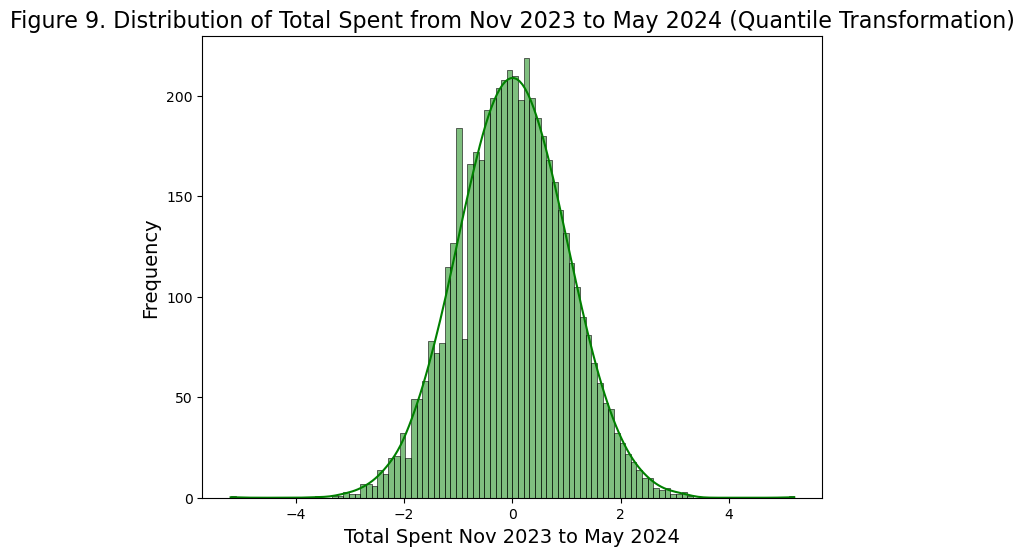

In [58]:
plt.figure(figsize=(8, 6))
sns.histplot(data=data_train, x='transformed_target_variable', bins=100, kde=True, color='g')
plt.title('Figure 9. Distribution of Total Spent from Nov 2023 to May 2024 (Quantile Transformation)', fontsize=16)
plt.xlabel('Total Spent Nov 2023 to May 2024', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.savefig('Figure 9. Distribution of Total Spent from Nov 2023 to May 2024 (Quantile Transformation).png')
plt.show()

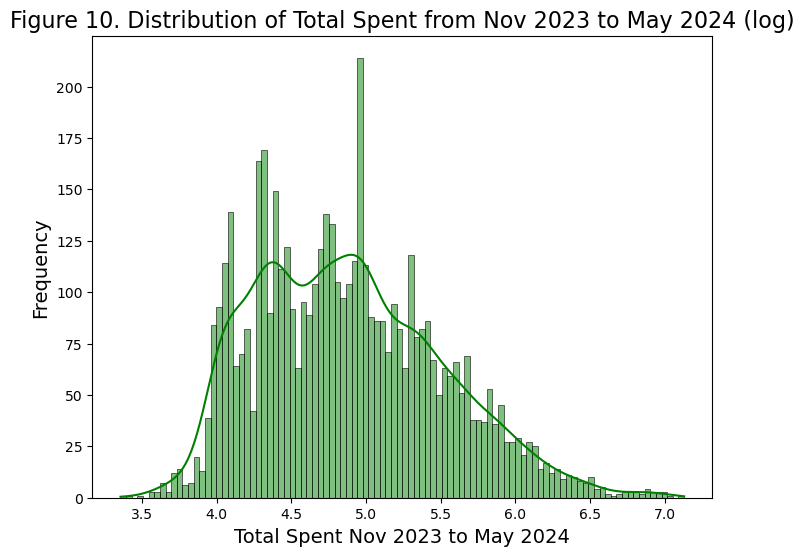

In [59]:
data_train['log_Total_Spent_Nov23_May24'] = np.log(data_train['Total_Spent_Nov23_May24'])

plt.figure(figsize=(8, 6))
sns.histplot(data=data_train, x='log_Total_Spent_Nov23_May24', bins=100, kde=True, color='g')
plt.title('Figure 10. Distribution of Total Spent from Nov 2023 to May 2024 (log)', fontsize=16)
plt.xlabel('Total Spent Nov 2023 to May 2024', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.savefig('Figure 10. Distribution of Total Spent from Nov 2023 to May 2024 (log).png')
plt.show()

#### 1. New featrues with time-related variabels

In [60]:
data_train2['spent_12plus'] = data_train2['Total_Spent_AllTime'] - data_train2['Total_Spent_12M'] 
data_train2['spent_9to12'] = data_train2['Total_Spent_12M'] - data_train2['Total_Spent_9M'] 
data_train2['spent_6to9'] = data_train2['Total_Spent_9M'] - data_train2['Total_Spent_6M'] 
data_train2['spent_3to6'] = data_train2['Total_Spent_6M'] - data_train2['Total_Spent_3M'] 

data_train2['count_12plus'] = data_train2['Transaction_Count_AllTime'] - data_train2['Transaction_Count_12M'] 
data_train2['count_9to12'] = data_train2['Transaction_Count_12M'] - data_train2['Transaction_Count_9M'] 
data_train2['count_6to9'] = data_train2['Transaction_Count_9M'] - data_train2['Transaction_Count_6M'] 
data_train2['count_3to6'] = data_train2['Transaction_Count_6M'] - data_train2['Transaction_Count_3M'] 

data_test2['spent_12plus'] = data_test2['Total_Spent_AllTime'] - data_test2['Total_Spent_12M'] 
data_test2['spent_9to12'] = data_test2['Total_Spent_12M'] - data_test2['Total_Spent_9M'] 
data_test2['spent_6to9'] = data_test2['Total_Spent_9M'] - data_test2['Total_Spent_6M'] 
data_test2['spent_3to6'] = data_test2['Total_Spent_6M'] - data_test2['Total_Spent_3M'] 

data_test2['count_12plus'] = data_test2['Transaction_Count_AllTime'] - data_test2['Transaction_Count_12M'] 
data_test2['count_9to12'] = data_test2['Transaction_Count_12M'] - data_test2['Transaction_Count_9M'] 
data_test2['count_6to9'] = data_test2['Transaction_Count_9M'] - data_test2['Transaction_Count_6M'] 
data_test2['count_3to6'] = data_test2['Transaction_Count_6M'] - data_test2['Transaction_Count_3M'] 

In [61]:
columns_to_drop = [
        'Total_Spent_1M', 'Transaction_Count_1M',
       'Total_Spent_6M',
       'Transaction_Count_6M', 'Total_Spent_9M', 'Transaction_Count_9M',
       'Total_Spent_12M', 'Transaction_Count_12M', 'Total_Spent_AllTime',
       'Transaction_Count_AllTime'
    ]
    
data_train2.drop(columns=columns_to_drop, inplace=True)
data_test2.drop(columns=columns_to_drop, inplace=True)

#### 2. New features with products

In [62]:
def create_and_remove_old_variables(data):
    data['Sunscreen'] = (data['Brand Description_Anthelios'] + 
                         data['Brand Description_Uvidea'] + 
                         data['Category_Sun Care'] + 
                         data['Skin Concern_Sun Protection'])

    data['Basic_Cleaning_Moisturizing'] = (data['Brand Description_Cicaplast'] + 
                                           data['Brand Description_Lipikar'] + 
                                           data['Brand Description_Eau Thermale'] + 
                                           data['Brand Description_Serozinc'] + 
                                           data['Brand Description_Toleriane'] + 
                                           data['Class Description_Body Care'] + 
                                           data['Category_Body Care'] + 
                                           data['Skin Concern_Irritation-Prone Skin'])

    data['Anti_Ageing_Antioxidation'] = (data['Brand Description_Hyalu B5'] + 
                                         data['Brand Description_Retinol LRP'] + 
                                         data['Brand Description_Vitamin C'] + 
                                         data['Class Description_Anti-Ageing'] + 
                                         data['Skin Concern_Anti-Ageing'])


    data['Anti_Acne'] = (data['Brand Description_Effaclar'] + 
                         data['Class Description_Anti-Acne'] + 
                         data['Skin Concern_Acne-Prone Skin'])


    data['Spot_Correction_Pigmentation'] = (data['Brand Description_Niacinamide'] + 
                                            data['Skin Concern_Pigmentation and Dark Spots'])

    data['Bundle'] = (data['Brand Description_Bundle'] + 
                      data['Class Description_Bundle'])

    data['Face_Care'] = (data['Class Description_Face Care'] + 
                         data['Category_Face Care'])

    columns_to_drop = [
        'Brand Description_Anthelios', 'Brand Description_Uvidea',
        'Category_Sun Care', 'Sub-Category_Sunscreen', 'Sub-Category_Tinted Sunscreen', 'Skin Concern_Sun Protection',
        'Brand Description_Cicaplast', 'Brand Description_Lipikar', 'Brand Description_Eau Thermale', 'Brand Description_Serozinc', 'Brand Description_Toleriane',
        'Class Description_Body Care', 'Category_Body Care', 'Sub-Category_Body Moisturiser', 'Sub-Category_Body Wash', 'Sub-Category_Face Cleanser',
        'Sub-Category_Face Moisturiser', 'Sub-Category_Toner & Mist', 'Skin Concern_Irritation-Prone Skin',
        'Brand Description_Hyalu B5', 'Brand Description_Retinol LRP', 'Brand Description_Vitamin C',
        'Class Description_Anti-Ageing', 'Skin Concern_Anti-Ageing',
        'Brand Description_Effaclar', 'Class Description_Anti-Acne', 'Skin Concern_Acne-Prone Skin',
        'Brand Description_Niacinamide', 'Skin Concern_Pigmentation and Dark Spots',
        'Brand Description_Bundle', 'Class Description_Bundle',
        'Class Description_Face Care', 'Category_Face Care', 'Sub-Category_Face Mask', 
        'Sub-Category_Face Serum', 'Sub-Category_Eye Cream'
    ]
    
    data.drop(columns=columns_to_drop, inplace=True)

    return data

data_train2 = create_and_remove_old_variables(data_train2)
data_test2 = create_and_remove_old_variables(data_test2)

In [63]:
predictors3=[ 'spent_12plus',
       'spent_9to12', 'spent_6to9', 'spent_3to6', 'count_12plus',
       'count_9to12', 'count_6to9', 'count_3to6','Total_Spent_3M','Transaction_Count_3M',
        'EAN_TolerianeMoisturiser40ml',
       'EAN_HyaluB5Serum30ml', 'EAN_EffaclarMoisturiser40ml',
       'EAN_VitaminC10Serum30ml', 'EAN_RetinolB3Serum30ml',
       'EAN_EffaclarSerum30ml', 'EAN_AntheliosInvisibleSunscreen50ml',
       'EAN_Pure10NiacinamideSerum', 'EAN_CicaplastB5BaumeBothSKUs40ml','Sunscreen',
       'Basic_Cleaning_Moisturizing', 'Anti_Ageing_Antioxidation', 'Anti_Acne',
       'Spot_Correction_Pigmentation', 'Bundle', 'Face_Care']

In [64]:
train_transformed_target_variable=data_train2['transformed_target_variable']
test_transformed_target_variable=data_test2['transformed_target_variable']
no_transformed_target_variable=['Total_Spent_Nov23_May24']

In [65]:
data_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5120 entries, 3074 to 2732
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   CustomerID                           5120 non-null   object 
 1   Total_Spent_Nov23_May24              5120 non-null   float64
 2   Total_Spent_3M                       5120 non-null   float64
 3   Transaction_Count_3M                 5120 non-null   int64  
 4   EAN_TolerianeMoisturiser40ml         5120 non-null   int64  
 5   EAN_HyaluB5Serum30ml                 5120 non-null   int64  
 6   EAN_EffaclarMoisturiser40ml          5120 non-null   int64  
 7   EAN_VitaminC10Serum30ml              5120 non-null   int64  
 8   EAN_RetinolB3Serum30ml               5120 non-null   int64  
 9   EAN_EffaclarSerum30ml                5120 non-null   int64  
 10  EAN_AntheliosInvisibleSunscreen50ml  5120 non-null   int64  
 11  EAN_Pure10NiacinamideSerum 

In [66]:
data_train2.to_excel('data_train2.xlsx', index=False)
data_test2.to_excel('data_test2.xlsx', index=False)

#### 3. Standardization

In [67]:
X_train_Linear=data_train2[predictors3].values
X_test_Linear=data_test2[predictors3].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled_linear = scaler.fit_transform(X_train_Linear)
X_test_scaled_linear = scaler.transform(X_test_Linear)

## Modeling

### 1. Baseline Model (OLS/Lasso/Ridge/Elastic Net)

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

#ols
X_train_Linear=data_train2[predictors3].values
X_test_Linear=data_test2[predictors3].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled_linear = scaler.fit_transform(X_train_Linear)
X_test_scaled_linear = scaler.transform(X_test_Linear)


reg = LinearRegression()
reg.fit(X_train_scaled_linear,transformed_target_variable_train)
y_pred_selected = reg.predict(X_test_scaled_linear)


ols_rmse_inv = np.sqrt(mean_squared_error(y_test_nolog, transformer.inverse_transform(y_pred_selected.reshape(-1, 1)).flatten()))
r2_ols_inv = r2_score(y_test_nolog, transformer.inverse_transform(y_pred_selected.reshape(-1, 1)).flatten())

print(f'OLS RMSE after inverse transformation: {ols_rmse_inv:.3f}')
print(f'OLS R-squared after inverse transformation: {r2_ols_inv:.3f}')

OLS RMSE after inverse transformation: 126.328
OLS R-squared after inverse transformation: 0.110


In [69]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

lasso = Lasso()

grid_search = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error')

grid_search.fit(X_train_scaled_linear, transformed_target_variable_train)

best_alpha = grid_search.best_params_['alpha']
print(f"best alpha: {best_alpha}")

best_lasso = Lasso(alpha=best_alpha)

best_lasso.fit(X_train_scaled_linear, transformed_target_variable_train)

y_pred_test = best_lasso.predict(X_test_scaled_linear)
lasso_rmse_inv = np.sqrt(mean_squared_error(y_test_nolog, transformer.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()))
r2_lasso_inv = r2_score(y_test_nolog, transformer.inverse_transform(y_pred_test.reshape(-1, 1)).flatten())

print(f'Lasso RMSE after inverse transformation: {lasso_rmse_inv:.3f}')
print(f'Lasso R-squared after inverse transformation: {r2_lasso_inv:.3f}')

best alpha: 0.01
Lasso RMSE after inverse transformation: 124.347
Lasso R-squared after inverse transformation: 0.138


In [70]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1]  
}

elastic_net = ElasticNet()

grid_search_en = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_en.fit(X_train_scaled_linear, transformed_target_variable_train)


best_alpha = grid_search_en.best_params_['alpha']
best_l1_ratio = grid_search_en.best_params_['l1_ratio']
print(f"best alpha: {best_alpha}")
print(f"best l1_ratio: {best_l1_ratio}")


best_elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)

best_elastic_net.fit(X_train_scaled_linear, transformed_target_variable_train)

y_pred_test_en = best_elastic_net.predict(X_test_scaled_linear)
elastic_rmse_inv = np.sqrt(mean_squared_error(y_test_nolog, transformer.inverse_transform(y_pred_test_en.reshape(-1, 1)).flatten()))
r2_elastic_inv = r2_score(y_test_nolog, transformer.inverse_transform(y_pred_test_en.reshape(-1, 1)).flatten())

print(f'Elastic Net RMSE after inverse transformation: {elastic_rmse_inv:.3f}')
print(f'Elastic Net R-squared after inverse transformation: {r2_elastic_inv:.3f}')

best alpha: 0.01
best l1_ratio: 0.5
Elastic Net RMSE after inverse transformation: 125.403
Elastic Net R-squared after inverse transformation: 0.123


#### 1.1 Check the Assumption of linear model

1. Multicollinearity (VIF method)

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_train_sm = sm.add_constant(X_train_scaled_linear)
X_check_multicollinearity = X_train_sm


vif_data = pd.DataFrame()
vif_data["feature"] = ['constant']+predictors3
vif_data["VIF"] = [variance_inflation_factor(X_check_multicollinearity, i) for i in range(X_check_multicollinearity.shape[1])]

print(vif_data)

                                feature       VIF
0                              constant  1.000000
1                          spent_12plus  5.941093
2                           spent_9to12  6.999084
3                            spent_6to9  5.053157
4                            spent_3to6  4.784464
5                          count_12plus  5.339889
6                           count_9to12  6.412929
7                            count_6to9  4.346098
8                            count_3to6  4.278475
9                        Total_Spent_3M  4.270931
10                 Transaction_Count_3M  3.803147
11         EAN_TolerianeMoisturiser40ml  1.478417
12                 EAN_HyaluB5Serum30ml  2.237860
13          EAN_EffaclarMoisturiser40ml  2.359765
14              EAN_VitaminC10Serum30ml  1.839666
15               EAN_RetinolB3Serum30ml  2.008845
16                EAN_EffaclarSerum30ml  1.433680
17  EAN_AntheliosInvisibleSunscreen50ml  1.597068
18           EAN_Pure10NiacinamideSerum  9.349040


2. Normality and homoscedasticity of errors

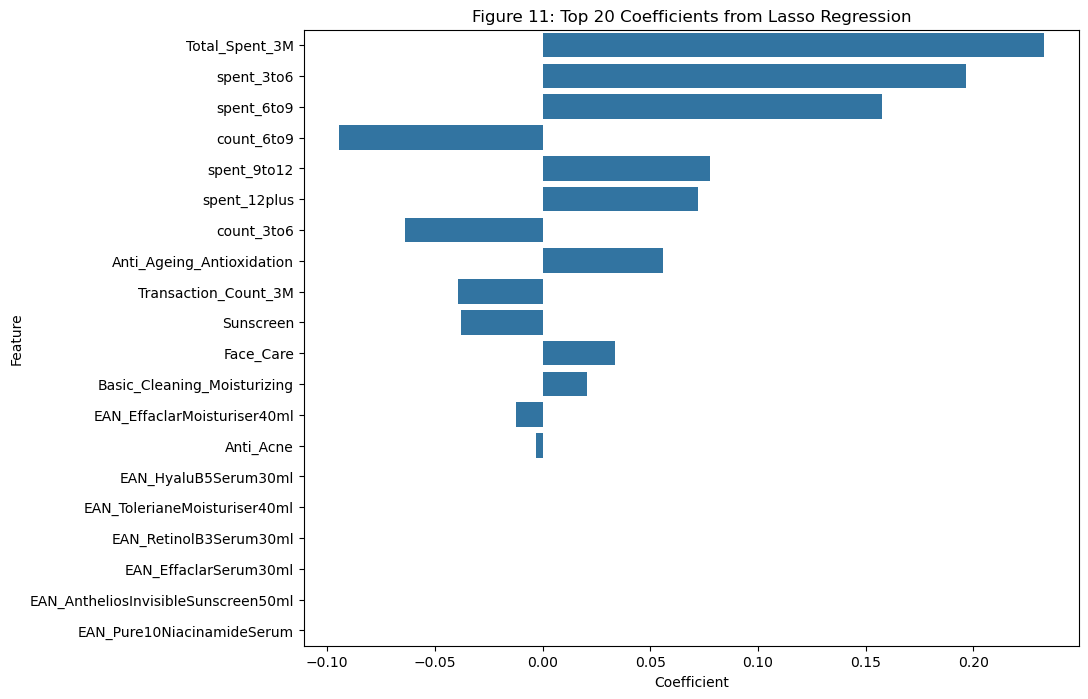

In [72]:
coefficients = pd.DataFrame({'Feature': predictors3, 'Coefficient': best_lasso.coef_.flatten()})
coefficients = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Figure 11: Top 20 Coefficients from Lasso Regression')
plt.savefig('Figure 11: Top 20 Coefficients from Lasso Regression.png')
plt.show()

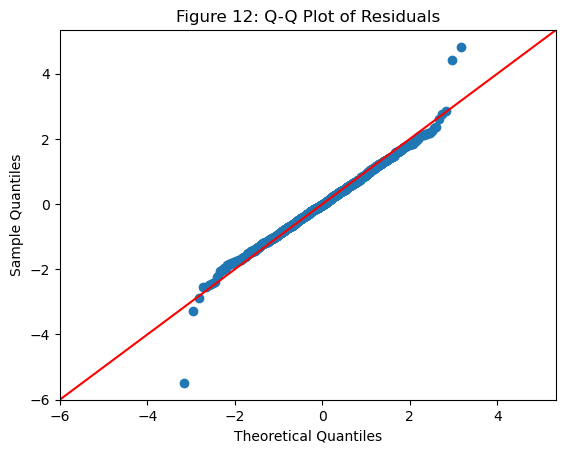

In [73]:
transformed_target_variable_test = transformed_target_variable_test.flatten()
residuals = transformed_target_variable_test - y_pred_test

sm.qqplot(residuals, line='45')
plt.title('Figure 12: Q-Q Plot of Residuals')
plt.savefig('Figure 12: Q-Q Plot of Residuals.png')
plt.show()

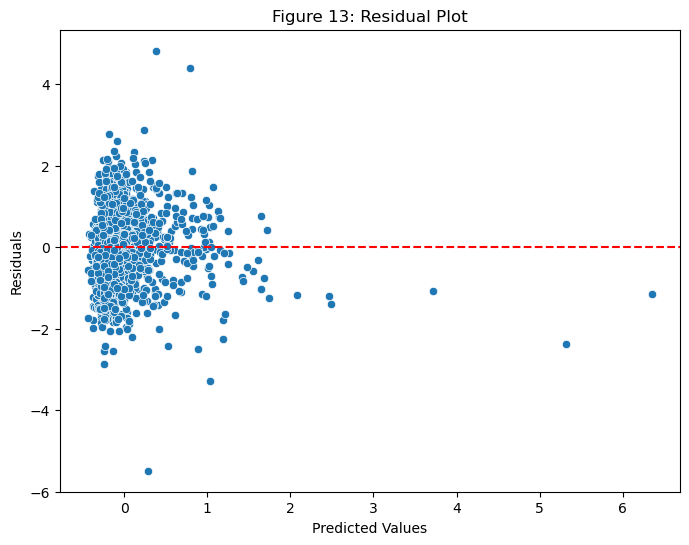

In [74]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Figure 13: Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.savefig('Figure 13: Residual Plot.png')
plt.show()

### 2. Decision Tree

In [75]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import graphviz

#### Search for best parameters

In [76]:
min_samples_split = [2, 5, 8, 10]


min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 60, num = 30)]

model = DecisionTreeRegressor(random_state = 0)


parameters = {
    'max_depth': range(10),
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'ccp_alpha': [0, 0.0001, 0.001, 0.01],
    'splitter': ['best', 'random']
}



In [77]:
grid_search = GridSearchCV(model, parameters, cv=10)
grid_search.fit(data_train2[predictors3], data_train2[no_transformed_target_variable])
print(f"Best parameters: {grid_search.best_params_}, Best score: {grid_search.best_score_}")


Best parameters: {'ccp_alpha': 0, 'max_depth': 6, 'min_samples_leaf': 44, 'min_samples_split': 2, 'splitter': 'best'}, Best score: 0.138486732988858


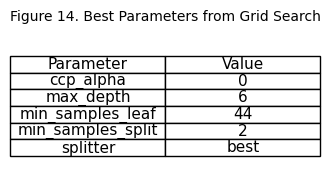

In [78]:
best_params_df = pd.DataFrame(list(grid_search.best_params_.items()), columns=['Parameter', 'Value'])
fig, ax = plt.subplots(figsize=(4, 2))  # Adjust the size as needed


ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=best_params_df.values,
                 colLabels=best_params_df.columns,
                 cellLoc='center', 
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
plt.title('Figure 14. Best Parameters from Grid Search', fontsize=10)
plt.savefig('Figure 14. best_parameters_table.png', bbox_inches='tight', dpi=300)

plt.show()

#### Decision tree plot

In [79]:
best_param = grid_search.best_params_
dt = DecisionTreeRegressor(random_state = 0, **best_param)
dt.fit(data_train2[predictors3],data_train2[no_transformed_target_variable])

print(dt.score(data_train2[predictors3],data_train2[no_transformed_target_variable]))

export_graphviz(dt, out_file = 'regress_tree.dot',
                feature_names = predictors3)

0.20024814471831154


In [80]:
with open('regress_tree.dot') as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)
graph.render('regress_tree')

'regress_tree.pdf'

#### Decision tree result

In [81]:
dt_pred = dt.predict(data_test2[predictors3])


dt_rmse = np.sqrt(mean_squared_error(data_test2[no_transformed_target_variable], dt_pred))
r2_dt = r2_score(data_test2[no_transformed_target_variable], dt_pred)

print('--DECISION TREE REGRESSION MODEL PERFORMANCE--')
print(f'RMSE: {dt_rmse:.3f}')
print(f'R-squared: {r2_dt:.3f}')
print('-----------------------------')

--DECISION TREE REGRESSION MODEL PERFORMANCE--
RMSE: 123.734
R-squared: 0.146
-----------------------------


#### quantile transfered variable check

In [82]:

grid_search_inv = GridSearchCV(model, parameters, cv=5)
grid_search_inv.fit(data_train2[predictors3], data_train2['transformed_target_variable'])
print(f"Best parameters: {grid_search_inv.best_params_}, Best score: {grid_search_inv.best_score_}")

Best parameters: {'ccp_alpha': 0, 'max_depth': 4, 'min_samples_leaf': 52, 'min_samples_split': 2, 'splitter': 'best'}, Best score: 0.13484566272589601


In [83]:
best_param_inv = grid_search_inv.best_params_
dt_inv = DecisionTreeRegressor(random_state = 0, **best_param_inv)
dt_inv.fit(data_train2[predictors3],data_train2['transformed_target_variable'])

print(dt_inv.score(data_train2[predictors3],data_train2['transformed_target_variable']))

export_graphviz(dt_inv, out_file = 'regress_tree_inv.dot',
                feature_names = predictors3)

0.16092925603133001


In [84]:
with open('regress_tree_inv.dot') as f:
    dot_graph_inv = f.read()
graph_inv = graphviz.Source(dot_graph_inv)
graph_inv.render('regress_tree_inv')

'regress_tree_inv.pdf'

In [85]:
dt_inv_pred = dt_inv.predict(data_test2[predictors3])


dt_inv_rmse = np.sqrt(mean_squared_error(data_test2['transformed_target_variable'], dt_inv_pred))
r2_inv_dt = r2_score(data_test2['transformed_target_variable'], dt_inv_pred)
dt_rmse_inv = np.sqrt(mean_squared_error(data_test2[no_transformed_target_variable], transformer.inverse_transform(dt_inv_pred.reshape(-1, 1)).flatten()))
r2_dt_inv = r2_score(data_test2[no_transformed_target_variable], transformer.inverse_transform(dt_inv_pred.reshape(-1, 1)).flatten())

print('--DECISION TREE REGRESSION MODEL PERFORMANCE--')
print(f'RMSE: {dt_inv_rmse:.3f}')
print(f'R-squared: {r2_inv_dt:.3f}')
print('-----------------------------')
print(f'RMSE after inverse transformation: {dt_rmse_inv:.3f}')
print(f'R-squared after inverse transformation: {r2_dt_inv:.3f}')

--DECISION TREE REGRESSION MODEL PERFORMANCE--
RMSE: 0.948
R-squared: 0.140
-----------------------------
RMSE after inverse transformation: 128.680
R-squared after inverse transformation: 0.077


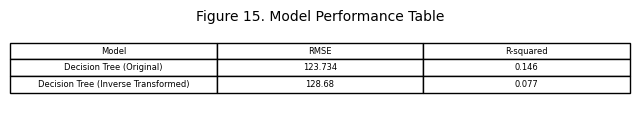

In [86]:
from pandas.plotting import table

results = {
    'Model': ['Decision Tree (Original)', 'Decision Tree (Inverse Transformed)'],
    'RMSE': [round(dt_rmse, 3), round(dt_rmse_inv, 3)],
    'R-squared': [round(r2_dt, 3), round(r2_dt_inv, 3)]
}

results_df = pd.DataFrame(results)

plt.figure(figsize=(8, 1))
plt.axis('tight')
plt.axis('off')
plt.table(cellText=results_df.values,
          colLabels=results_df.columns,
          cellLoc = 'center',
          loc='center')


plt.title('Figure 15. Model Performance Table', fontsize=10)
plt.savefig('Figure 15. model_performance.png', bbox_inches='tight')
plt.show()

#### Strategy Evaluation

In [97]:
updated_train = pd.read_excel('data_train2.xlsx')
updated_test = pd.read_excel('data_test2.xlsx')

In [98]:
model2 = DecisionTreeRegressor(random_state = 0)



parameters2 = {
    'max_depth': range(10),
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'ccp_alpha': [0, 0.0001, 0.001, 0.01],
    'splitter': ['best', 'random']
}

In [99]:
grid_search2 = GridSearchCV(model2, parameters2, cv=5)
grid_search2.fit(updated_train[predictors3], updated_train[no_transformed_target_variable])
print(f"Best parameters: {grid_search2.best_params_}, Best score: {grid_search2.best_score_}")

Best parameters: {'ccp_alpha': 0, 'max_depth': 9, 'min_samples_leaf': 24, 'min_samples_split': 2, 'splitter': 'best'}, Best score: 0.07903973415021356


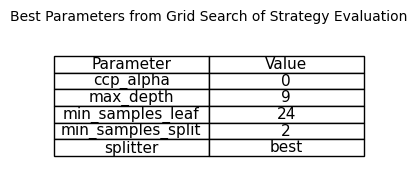

In [100]:
best_params_df2 = pd.DataFrame(list(grid_search2.best_params_.items()), columns=['Parameter', 'Value'])
fig, ax = plt.subplots(figsize=(4, 2))  # Adjust the size as needed


ax.axis('tight')
ax.axis('off')

table1 = ax.table(cellText=best_params_df2.values,
                 colLabels=best_params_df2.columns,
                 cellLoc='center', 
                 loc='center')
table1.auto_set_font_size(False)
table1.set_fontsize(11)
plt.title('Best Parameters from Grid Search of Strategy Evaluation', fontsize=10)

plt.show()

In [101]:
best_param2 = grid_search2.best_params_
dt2 = DecisionTreeRegressor(random_state = 0, **best_param2)
dt2.fit(updated_train[predictors3],updated_train[no_transformed_target_variable])

print(dt2.score(updated_train[predictors3],updated_train[no_transformed_target_variable]))

export_graphviz(dt2, out_file = 'regress_tree.dot',
                feature_names = predictors3)

0.1908495711084135


In [102]:
with open('regress_tree.dot') as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)
graph.render('regress_tree2')

'regress_tree2.pdf'

In [103]:
dt_pred2 = dt2.predict(updated_test[predictors3])

In [104]:
updated_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   CustomerID                           385 non-null    object 
 1   Total_Spent_Nov23_May24              385 non-null    float64
 2   Total_Spent_3M                       385 non-null    float64
 3   Transaction_Count_3M                 385 non-null    int64  
 4   EAN_TolerianeMoisturiser40ml         385 non-null    int64  
 5   EAN_HyaluB5Serum30ml                 385 non-null    int64  
 6   EAN_EffaclarMoisturiser40ml          385 non-null    int64  
 7   EAN_VitaminC10Serum30ml              385 non-null    int64  
 8   EAN_RetinolB3Serum30ml               385 non-null    int64  
 9   EAN_EffaclarSerum30ml                385 non-null    int64  
 10  EAN_AntheliosInvisibleSunscreen50ml  385 non-null    int64  
 11  EAN_Pure10NiacinamideSerum      

In [105]:
updated_test['Total_Spent_3M'] = updated_test['New_Total_Spent_3M']

In [106]:
dt_pred3 = dt2.predict(updated_test[predictors3])

In [107]:
print('The amount of sales increase after implementing the strategy is: ${:.3f}'.format((dt_pred3 - dt_pred2).sum()))

The amount of sales increase after implementing the strategy is: $3306.519


### 3. XGBoost

#### 3.1 XGBoost's feature selection

In [108]:
import xgboost as xgb
import optuna
from xgboost.sklearn import XGBRegressor
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [109]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

rfe = RFE(estimator=xgb_model)

param_grid = {'n_features_to_select': range(7, 21)} 

grid_search = GridSearchCV(estimator=rfe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

grid_search.fit(data_train2[predictors3], y_train_nolog)

print("Best n_features_to_select:", grid_search.best_params_)

Best n_features_to_select: {'n_features_to_select': 20}


In [110]:
rfe = RFE(estimator=xgb_model, n_features_to_select=20)

rfe.fit(data_train2[predictors3], y_train_nolog)
selected_features = data_train2[predictors3].columns[rfe.support_]
print("Selected feature names: ", selected_features)

Selected feature names:  Index(['spent_12plus', 'spent_9to12', 'spent_6to9', 'spent_3to6',
       'count_12plus', 'count_9to12', 'count_6to9', 'count_3to6',
       'Total_Spent_3M', 'Transaction_Count_3M', 'EAN_HyaluB5Serum30ml',
       'EAN_EffaclarMoisturiser40ml', 'EAN_RetinolB3Serum30ml',
       'EAN_AntheliosInvisibleSunscreen50ml', 'EAN_Pure10NiacinamideSerum',
       'Basic_Cleaning_Moisturizing', 'Anti_Ageing_Antioxidation', 'Anti_Acne',
       'Spot_Correction_Pigmentation', 'Face_Care'],
      dtype='object')


In [111]:
X_train_selected = rfe.transform(data_train2[predictors3])
X_test_selected = rfe.transform(data_test2[predictors3])

#### 3.2 XGBoost Hyperparameter Optimization

In [112]:
from sklearn.model_selection import cross_val_score
import numpy as np

def modelfit(alg, dtrain, dtrain_selected, y_train, feature_names, useTrainCV=True, cv_folds=5, early_stopping_rounds=60):
    if useTrainCV:

        xgb_param = alg.get_xgb_params()
        

        xgtrain = xgb.DMatrix(dtrain_selected, label=y_train)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds, metrics='rmse', early_stopping_rounds=early_stopping_rounds, 
                          as_pandas=True, seed=42)

        best_n_estimators = cvresult['test-rmse-mean'].idxmin() + 1  
        alg.set_params(n_estimators=best_n_estimators)
        print(f"Best n_estimators found: {best_n_estimators}")

    alg.fit(dtrain_selected, y_train)
    train_predictions = alg.predict(dtrain_selected)
    
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_predictions))
    print(f"Training RMSE: {train_rmse:.4g}")

    booster = alg.get_booster()
    importance = booster.get_score(importance_type='weight')
    importance_mapped = {
        feature_names[int(k[1:])]: v for k, v in importance.items() if k.startswith('f')
    }
    feat_imp = pd.Series(importance_mapped).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    
    return alg

Best n_estimators found: 29
Training RMSE: 102.3


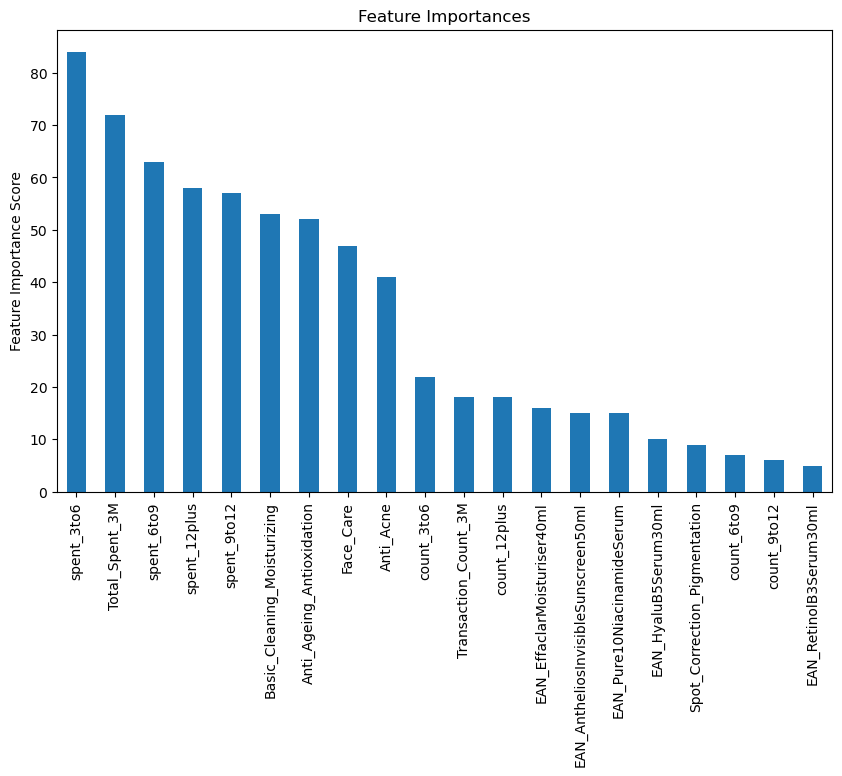

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=29, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [113]:
from sklearn import metrics
basic_xgb = XGBRegressor(
    learning_rate=0.1,
    n_estimators=100,  
    max_depth=5,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    reg_alpha=0,
    reg_lambda=1,
    random_state=42
)
selected_feature_names = data_train2[predictors3].columns[rfe.support_]
modelfit(basic_xgb,data_train2, X_train_selected, y_train_nolog, selected_feature_names, useTrainCV=True)

In [114]:
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
y_test_pred_xgb_basic = basic_xgb.predict(X_test_selected)
rmse_test_xgb_basic = np.sqrt(mean_squared_error(y_test_nolog, y_test_pred_xgb_basic))
r2_xgb_basic= r2_score(y_test_nolog, y_test_pred_xgb_basic)

print('--Basic XGBoost MODEL PERFORMANCE--')
print(f'RMSE: {rmse_test_xgb_basic:.3f}')
print(f'R-squared: {r2_xgb_basic:.3f}')

--Basic XGBoost MODEL PERFORMANCE--
RMSE: 123.429
R-squared: 0.151


#### 1. n_estimators

Best n_estimators found: 19
Training RMSE: 105.3


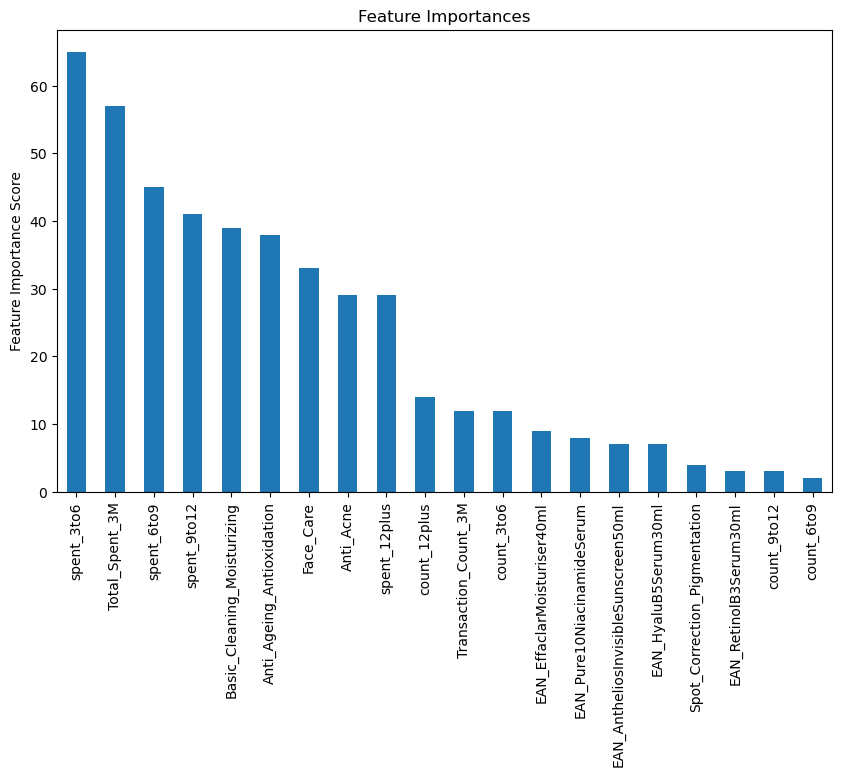

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=19, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [115]:
xgb1 = XGBRegressor(
    learning_rate=0.1,
    n_estimators=21,  
    max_depth=5,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)


selected_feature_names = data_train2[predictors3].columns[rfe.support_]
modelfit(xgb1,data_train2, X_train_selected, y_train_nolog, selected_feature_names, useTrainCV=True)

#### 2. max_depth & min_child_weight

In [116]:
from sklearn.model_selection import GridSearchCV
param_test1 = { 
  'max_depth': range(3,10,2),
  'min_child_weight': range(1,6,2)
 } 

gsearch1 = GridSearchCV(
    estimator=XGBRegressor(
        learning_rate=0.1,  
        n_estimators=21,  
        max_depth=5,  
        min_child_weight=3,  
        gamma=0,  
        subsample=0.8,  
        colsample_bytree=0.8,  
        objective='reg:squarederror',
        random_state=42
    ),
    param_grid=param_test1,  
    scoring='neg_mean_squared_error',   
    cv=5  
)

gsearch1.fit(X_train_selected, y_train_nolog)

print("Best Parameters:", gsearch1.best_params_)
print("Best Score (MSE):", gsearch1.best_score_)

Best Parameters: {'max_depth': 5, 'min_child_weight': 5}
Best Score (MSE): -13336.284941576563


In [117]:
param_test2 = { 
  'max_depth': [2,3,4],
  'min_child_weight': [4,5,6,7]
 } 
gsearch2 = GridSearchCV(
    estimator=XGBRegressor(
        learning_rate=0.1,  
        n_estimators=21,  
        max_depth=5,  
        min_child_weight=3,  
        gamma=0,  
        subsample=0.8,  
        colsample_bytree=0.8,  
        objective='reg:squarederror'  
    ),
    param_grid=param_test2,  
    scoring='neg_mean_squared_error',   
    cv=5  
)

gsearch2.fit(X_train_selected, y_train_nolog)

print("Best Parameters:", gsearch2.best_params_)
print("Best Score (MSE):", gsearch2.best_score_)

Best Parameters: {'max_depth': 4, 'min_child_weight': 5}
Best Score (MSE): -13280.023848536792


#### 3. Gamma

In [118]:
param_test3 = { 
  'gamma': [i/10.0 for i in range(0, 5)]  # [0.0, 0.1, 0.2, 0.3, 0.4]
}
gsearch3 = GridSearchCV(
    estimator=XGBRegressor(
        learning_rate=0.1,  
        n_estimators=21,  
        max_depth=3,  
        min_child_weight=4,  
        gamma=0,  
        subsample=0.8,  
        colsample_bytree=0.8,  
        objective='reg:squarederror',
        random_state=42
    ),
    param_grid=param_test3,  
    scoring='neg_mean_squared_error',   
    cv=5  # 5 折交叉验证
)

gsearch3.fit(X_train_selected, y_train_nolog)

print("Best Parameters:", gsearch3.best_params_)
print("Best Score (MSE):", gsearch3.best_score_)

Best Parameters: {'gamma': 0.0}
Best Score (MSE): -13381.7217932364


Best n_estimators found: 21
Training RMSE: 110.9


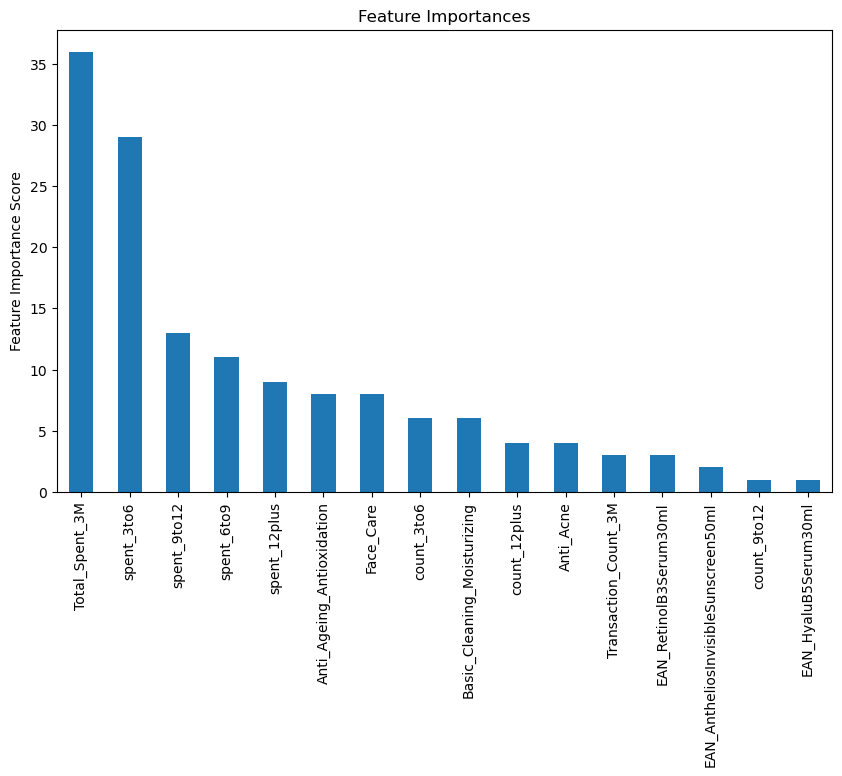

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=21, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [119]:
xgb2=XGBRegressor(
    learning_rate=0.1,
    n_estimators=21,
    max_depth=3,
    min_child_weight=4,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror')
modelfit(xgb2, data_train2, X_train_selected, y_train_nolog, selected_feature_names)

#### 4. subsample & colsample_bytree

In [120]:
param_test4 = { 
  'subsample': [i/10.0 for i in range(6, 10)],
    'colsample_bytree': [i/10.0 for i in range(6, 10)]
}
gsearch4 = GridSearchCV(
    estimator=XGBRegressor(
        learning_rate=0.1, 
        n_estimators=21,  
        max_depth=3,  
        min_child_weight=4,  
        gamma=0,  
        subsample=0.8,  
        colsample_bytree=0.8,  
        objective='reg:squarederror'  
    ),
    param_grid=param_test4,  
    scoring='neg_mean_squared_error',   
    cv=5  
)

gsearch4.fit(X_train_selected, y_train_nolog)

print("Best Parameters:", gsearch4.best_params_)
print("Best Score (MSE):", gsearch4.best_score_)

Best Parameters: {'colsample_bytree': 0.7, 'subsample': 0.6}
Best Score (MSE): -13220.46135711476


In [121]:
param_test4b = { 
  'subsample': [i/100.0 for i in range(55, 100,5)],
    'colsample_bytree': [i/100.0 for i in range(85, 100, 5)]
}
gsearch4b = GridSearchCV(
    estimator=XGBRegressor(
        learning_rate=0.1,  
        n_estimators=21,  
        max_depth=3,  
        min_child_weight=4,  
        gamma=0,  
        subsample=0.8,  
        colsample_bytree=0.8,  
        objective='reg:squarederror'  
    ),
    param_grid=param_test4b,  
    scoring='neg_mean_squared_error',   
    cv=5  
)

gsearch4b.fit(X_train_selected, y_train_nolog)

print("Best Parameters:", gsearch4b.best_params_)
print("Best Score (MSE):", gsearch4b.best_score_)

Best Parameters: {'colsample_bytree': 0.85, 'subsample': 0.6}
Best Score (MSE): -13198.617619520248


#### 5. Regularisation

In [122]:
param_test5 = { 
  'reg_alpha': [1e-8, 1e-2, 0.1, 1, 10,100],
    'reg_lambda': [1e-8, 1e-2, 0.1, 0.5, 1, 10,100]
}
gsearch5 = GridSearchCV(
    estimator=XGBRegressor(
        learning_rate=0.1,  
        n_estimators=21,  
        max_depth=3,  
        min_child_weight=4,  
        gamma=0,  
        subsample=0.6,  
        colsample_bytree=0.95,  
        objective='reg:squarederror',
        random_state=42
    ),
    param_grid=param_test5,  
    scoring='neg_mean_squared_error',   
    cv=5  
)

gsearch5.fit(X_train_selected, y_train_nolog)

print("Best Parameters:", gsearch5.best_params_)
print("Best Score (MSE):", gsearch5.best_score_)

Best Parameters: {'reg_alpha': 0.1, 'reg_lambda': 0.1}
Best Score (MSE): -13317.639496776046


Best n_estimators found: 21
Training RMSE: 110.6


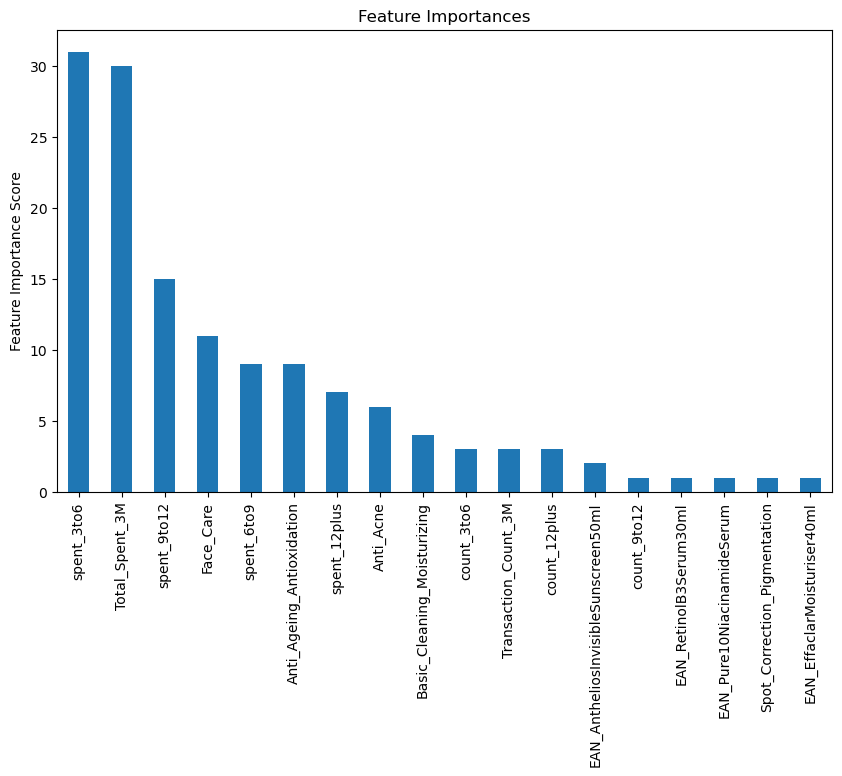

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=21, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [123]:
xgb3=XGBRegressor(
    learning_rate=0.1,
    n_estimators=21,
    max_depth=3,
    min_child_weight=4,
    gamma=0,
    subsample=0.6,
    colsample_bytree=0.95,
    objective='reg:squarederror',
    reg_alpha=100,
    reg_lambda=0.5)
modelfit(xgb3, data_train2, X_train_selected, y_train_nolog, selected_feature_names)

#### 6. Learning Rate

In [124]:
param_test6 = { 
  'learning_rate': np.arange(0.01, 0.21, 0.01)
}
gsearch6 = GridSearchCV(
    estimator=XGBRegressor(
        learning_rate=0.1,  
        n_estimators=21,  
        max_depth=3,  
        min_child_weight=4,  
        gamma=0,  
        subsample=0.6,  
        colsample_bytree=0.95,
        reg_alpha=100,
        reg_lambda= 0.5,
        objective='reg:squarederror',
        random_state=42
    ),
    param_grid=param_test6,  
    scoring='neg_mean_squared_error',   
    cv=5  
)

gsearch6.fit(X_train_selected, y_train_nolog)

print("Best Parameters:", gsearch6.best_params_)
print("Best Score (MSE):", gsearch6.best_score_)

Best Parameters: {'learning_rate': 0.12}
Best Score (MSE): -13306.965708493812


Best n_estimators found: 19
Training RMSE: 109.1


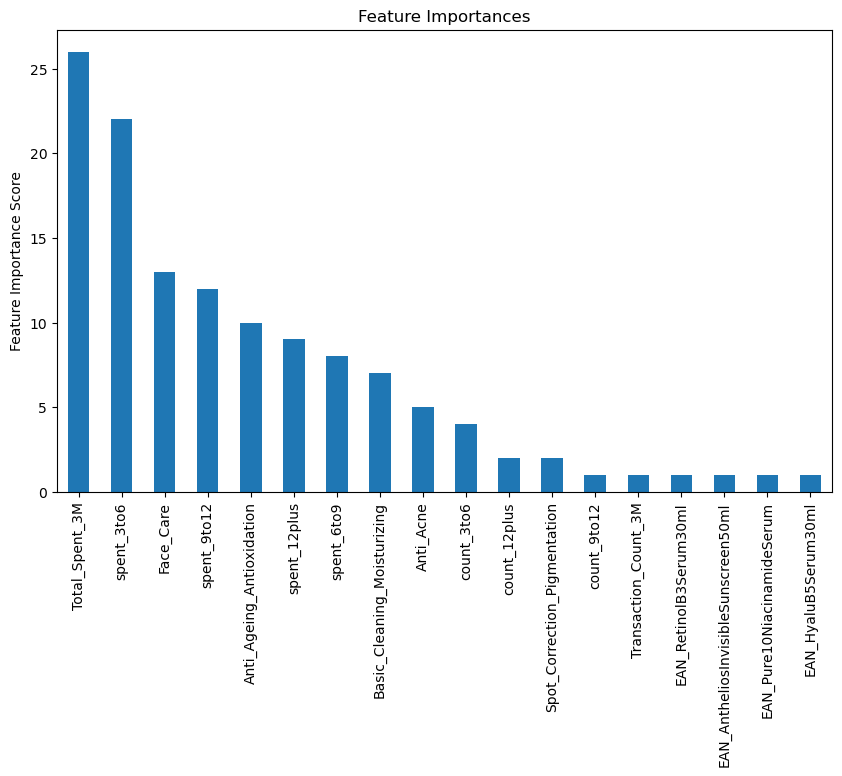

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.95, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.16, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=19, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [125]:
xgb4=XGBRegressor(
    learning_rate=0.16,
    n_estimators=21,
    max_depth=3,
    min_child_weight=4,
    gamma=0,
    subsample=0.6,
    colsample_bytree=0.95,
    objective='reg:squarederror',
    reg_alpha=100,
    reg_lambda=0.5)
modelfit(xgb4,data_train2, X_train_selected, y_train_nolog, selected_feature_names)

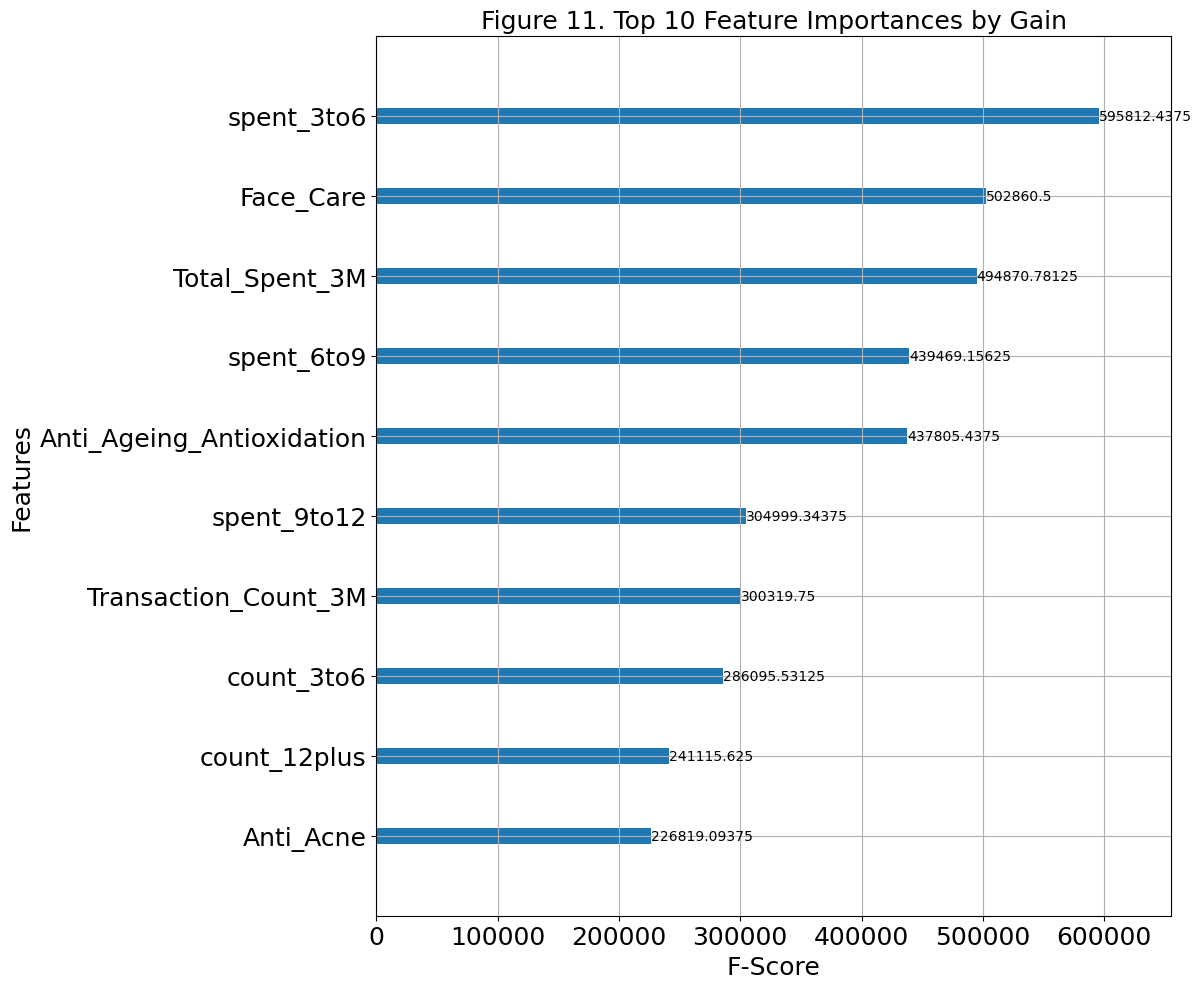

In [126]:
from xgboost import XGBRegressor, plot_importance
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)

xgb4.fit(X_train_selected_df, y_train_nolog)

fig, ax = plt.subplots(figsize=(12, 10))
plot_importance(xgb4, importance_type='gain', max_num_features=10, ax=ax)
plt.title('Figure 11. Top 10 Feature Importances by Gain',fontsize=18)
plt.xlabel('F-Score', fontsize=18)
plt.ylabel('Features', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
    
plt.tight_layout()
plt.savefig('Figure 11. Top 10 Feature Importances by Gain.png')

plt.show()

In [127]:
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
xgb4.fit(X_train_selected, y_train_nolog)
y_test_pred_xgb = xgb4.predict(X_test_selected)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test_nolog, y_test_pred_xgb))
r2_xgb= r2_score(y_test_nolog, y_test_pred_xgb)

print('--XGBoost MODEL PERFORMANCE--')
print(f'RMSE: {rmse_test_xgb:.3f}')
print(f'R-squared: {r2_xgb:.3f}')

--XGBoost MODEL PERFORMANCE--
RMSE: 120.620
R-squared: 0.189


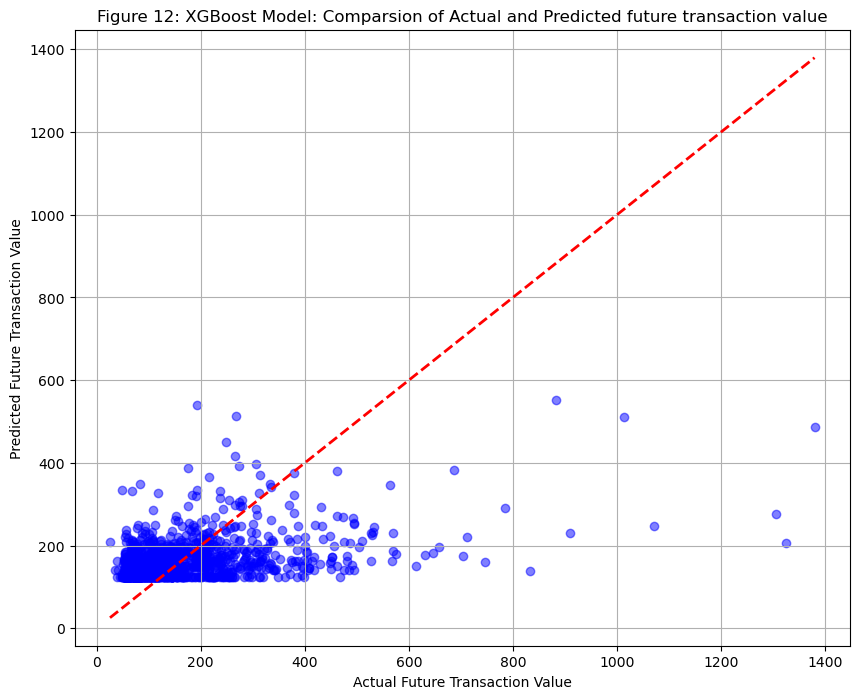

In [128]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test_nolog, y_test_pred_xgb, color='blue', alpha=0.5)
plt.plot([y_test_nolog.min(), y_test_nolog.max()], [y_test_nolog.min(), y_test_nolog.max()], 'r--', lw=2)  
plt.title("Figure 12: XGBoost Model: Comparsion of Actual and Predicted future transaction value")
plt.xlabel("Actual Future Transaction Value")
plt.ylabel("Predicted Future Transaction Value")
plt.grid(True)
plt.savefig("Figure 12 XGBoost Model: Comparsion of Actual and Predicted future transaction value.png")
plt.show()